In [8]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas pyarrow wandb plotly

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

In [47]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    #root = os.path.join("..","data", "ASL-ds")
    root = os.path.join(".")
    DATA_LIMIT = 2000
    BATCH_SIZE = 16
    VIDEO_LENGTH = 30
    TRAIN_VAL_SPLIT = 0.85
    WANDB_RUN = "mediapipe-asl-dataset"


In [48]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])
EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [49]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.io as pio

ids = None

order_global = {"pose" : 10000, "face" : 1000, "left_hand" : 100, "right_hand" : 10}

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()


def process_parquet(ds, idxes = None):
    ret = []
    frames_unique = sorted(np.unique(ds["frame"]))
    for i,frame in enumerate(frames_unique):
        frame_ds = ds[ds['frame'] == frame]
        
        order = []
        for el in frame_ds["row_id"]:
            _frame, part, keypoint = el.split("-")
            order.append(order_global[part] - int(keypoint))

        order = np.array(order)
        frame_ds.iloc[:, 1] = order
        frame_ds = frame_ds.sort_values(by="row_id", ascending=False)
    
        vals = np.array(frame_ds[["x", "y", "z"]])
        if idxes is not None:
            vals = vals[idxes]
    
        vals = vals.flatten()

        ret.append(vals)
        
    return np.array(ret)


def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]).flatten())
        
    return np.array(np.array(ret))

In [50]:
from sklearn.model_selection import train_test_split

#custom class to load data from Parquet files for training ML models.
class ParquetDatasetCached(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 preprocessing_func=None, frame_length :int = CONFIG.VIDEO_LENGTH,
                 split : str = "train", train_val_split : float = CONFIG.TRAIN_VAL_SPLIT,
                 sort_by_counts : bool = True, **kwargs
                ):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.preprocessing_func = preprocessing_func
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        
        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        self.cache_data()
                   

    def cache_data(self):
        self.cached_X, self.cached_Y = [], []
        
        pb = tqdm(range(len(self.dataset)), desc="Cacheing")

        for i in pb:
            
            path, label = self.dataset[i]
            df = pd.read_parquet(path)
                        
            one_hot_encoded_label = np.zeros(len(self.unique_labels))
            one_hot_encoded_label[self.label_2_id[label]] = 1

            self.cached_X.append(process_parquet2(df)) 
            self.cached_Y.append(one_hot_encoded_label)        

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.preprocessing_func(self.cached_X[idx]), self.cached_Y[idx]                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)


def preprocess(frames):
    current_length, num_features = frames.shape

    if current_length >= CONFIG.VIDEO_LENGTH:
            # TODO: a better than uniform value ? Could place gaussian in the middle
            random_start = random.randint(0, current_length - CONFIG.VIDEO_LENGTH)
            return np.nan_to_num(frames[random_start : (random_start + CONFIG.VIDEO_LENGTH)])
        
    # padd the video to contain zeros 
    return np.concatenate([np.nan_to_num(frames), np.zeros((CONFIG.VIDEO_LENGTH - current_length, num_features))], axis=0)

    
# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 preprocessing_func=preprocess,
                                check_if_file_exists = True,
                                split="train")

val_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 preprocessing_func=preprocess,
                                 check_if_file_exists= True,
                                 split="val")

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

Cacheing: 100%|██████████| 300/300 [00:07<00:00, 40.66it/s]

cardinality of train : 1700, cardinality of validation : 300


In [51]:
X_shape = train_dataset_parquet[0][0].shape
Y_shape = train_dataset_parquet[0][1].shape
print(f"X_shape = {X_shape}, Y_shape = {Y_shape}")

X_shape = (30, 1629), Y_shape = (5,)


In [52]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_dataset_parquet)):
        X_batch, Y_batch = train_dataset_parquet[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_dataset_parquet)):
        X_batch, Y_batch = val_dataset_parquet[i]
        yield X_batch, Y_batch        


train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

In [56]:
start = time.time()
isnans =False

f = True
labels_batches = []
labels = []

for el in tqdm(train_dataset):
    if f:
        print(el[0].shape, el[1].shape)
        f = False
    for l in el[1]:
        labels.append(np.argmax(l))
    
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break


print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")

12it [00:00, 56.07it/s]

(16, 30, 1629) (16, 5)


107it [00:01, 72.41it/s]

Iterating through dataset took : 1.483s


[]

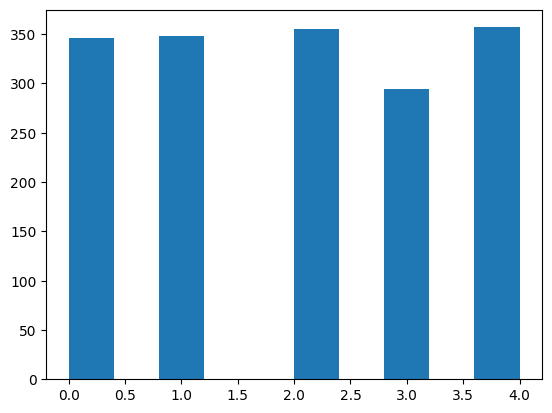

In [59]:
plt.hist(labels)
plt.plot()

# Train experiment

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 2.5e-5, T_max=101, epochs=200, run_name="",
                mediapipe_features = "all", USE_WANDB=True,
               verbose="auto"): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    
    history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset, callbacks=callbacks, verbose=verbose)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

In [61]:
print(train_dataset_parquet.label_2_id, len(train_dataset_parquet.label_2_id))

{'donkey': 0, 'listen': 1, 'look': 2, 'mouse': 3, 'shhh': 4} 5


## LSTM

In [11]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(16, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM16-LR-Dense256-fs=15-cls=13.tf"),
            run_name="AK-LSTM16-LR-Dense256-fs=15-cls=13",
            USE_WANDB=True)

2024-04-22 14:23:08.803673: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


Epoch 1/200


2024-04-22 14:23:15.048353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-22 14:23:16.483057: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f696c1c6fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 14:23:16.483083: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-22 14:23:16.486915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 14:23:16.591539: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    264/Unknown - 7s 7ms/step - loss: 2.5640 - categorical_accuracy: 0.0784

2024-04-22 14:23:18.938155: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 14:23:18.938198: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 14:23:18.938216: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14443695947898943194
2024-04-22 14:23:19.906567: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12692634430066471295
2024-04-22 14:23:19.906605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157
2024-04-22 14:23:19.906615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12587358524500767224
2024-04-22 14:23:19.906631: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 15s 36ms/step - loss: 2.5638 - categorical_accuracy: 0.0786 - val_loss: 2.5520 - val_categorical_accuracy: 0.0587
Epoch 2/200
266/266 [==============================] - ETA: 0s - loss: 2.5415 - categorical_accuracy: 0.1059INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.5415 - categorical_accuracy: 0.1059 - val_loss: 2.5201 - val_categorical_accuracy: 0.1453
Epoch 3/200
266/266 [==============================] - 2s 9ms/step - loss: 2.4889 - categorical_accuracy: 0.1645 - val_loss: 2.4555 - val_categorical_accuracy: 0.1440
Epoch 4/200
262/266 [============================>.] - ETA: 0s - loss: 2.4262 - categorical_accuracy: 0.1596INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.4254 - categorical_accuracy: 0.1593 - val_loss: 2.3823 - val_categorical_accuracy: 0.1507
Epoch 5/200
266/266 [==============================] - ETA: 0s - loss: 2.3614 - categorical_accuracy: 0.1680INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.3614 - categorical_accuracy: 0.1680 - val_loss: 2.3256 - val_categorical_accuracy: 0.1653
Epoch 6/200
263/266 [============================>.] - ETA: 0s - loss: 2.3182 - categorical_accuracy: 0.1663INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.3171 - categorical_accuracy: 0.1656 - val_loss: 2.2463 - val_categorical_accuracy: 0.1760
Epoch 7/200
264/266 [============================>.] - ETA: 0s - loss: 2.2443 - categorical_accuracy: 0.1733INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.2447 - categorical_accuracy: 0.1729 - val_loss: 2.1883 - val_categorical_accuracy: 0.1987
Epoch 8/200
266/266 [==============================] - 2s 8ms/step - loss: 2.2065 - categorical_accuracy: 0.1824 - val_loss: 2.1979 - val_categorical_accuracy: 0.1973
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1519 - categorical_accuracy: 0.1948 - val_loss: 2.2802 - val_categorical_accuracy: 0.1933
Epoch 10/200
264/266 [============================>.] - ETA: 0s - loss: 2.1342 - categorical_accuracy: 0.2121INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.1344 - categorical_accuracy: 0.2118 - val_loss: 2.1354 - val_categorical_accuracy: 0.2200
Epoch 11/200
265/266 [============================>.] - ETA: 0s - loss: 2.0931 - categorical_accuracy: 0.2085INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.0926 - categorical_accuracy: 0.2087 - val_loss: 2.0765 - val_categorical_accuracy: 0.2307
Epoch 12/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0952 - categorical_accuracy: 0.2134 - val_loss: 2.0677 - val_categorical_accuracy: 0.2267
Epoch 13/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0709 - categorical_accuracy: 0.2235 - val_loss: 2.0659 - val_categorical_accuracy: 0.2120
Epoch 14/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0563 - categorical_accuracy: 0.2273 - val_loss: 2.1203 - val_categorical_accuracy: 0.2080
Epoch 15/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0506 - categorical_accuracy: 0.2289 - val_loss: 2.0088 - val_categorical_accuracy: 0.2240
Epoch 16/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0401 - categorical_accuracy: 0.2355 - val_loss: 2.1397 - val_categorical_accuracy: 0.2093
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0313 - categorical_accuracy: 0.2327 - val_loss: 2.0296 - val_categorical_accuracy: 0.2347
Epoch 18/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0169 - categorical_accuracy: 0.2464 - val_loss: 2.0101 - val_categorical_accuracy: 0.2320
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0192 - categorical_accuracy: 0.2433 - val_loss: 2.0175 - val_categorical_accuracy: 0.2147
Epoch 20/200
264/266 [============================>.] - ETA: 0s - loss: 1.9966 - categorical_accuracy: 0.2481INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.9959 - categorical_accuracy: 0.2482 - val_loss: 1.9871 - val_categorical_accuracy: 0.2573
Epoch 21/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9831 - categorical_accuracy: 0.2492 - val_loss: 1.9746 - val_categorical_accuracy: 0.2573
Epoch 22/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9805 - categorical_accuracy: 0.2544 - val_loss: 2.0208 - val_categorical_accuracy: 0.2547
Epoch 23/200
260/266 [============================>.] - ETA: 0s - loss: 1.9717 - categorical_accuracy: 0.2642INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.9738 - categorical_accuracy: 0.2631 - val_loss: 1.9649 - val_categorical_accuracy: 0.2613
Epoch 24/200
265/266 [============================>.] - ETA: 0s - loss: 1.9399 - categorical_accuracy: 0.2717INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.9397 - categorical_accuracy: 0.2718 - val_loss: 1.9561 - val_categorical_accuracy: 0.2680
Epoch 25/200
259/266 [============================>.] - ETA: 0s - loss: 1.9463 - categorical_accuracy: 0.2683INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.9460 - categorical_accuracy: 0.2694 - val_loss: 1.9625 - val_categorical_accuracy: 0.2720
Epoch 26/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9232 - categorical_accuracy: 0.2845 - val_loss: 2.0038 - val_categorical_accuracy: 0.2627
Epoch 27/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9357 - categorical_accuracy: 0.2753 - val_loss: 1.8989 - val_categorical_accuracy: 0.2720
Epoch 28/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9198 - categorical_accuracy: 0.2795 - val_loss: 1.9127 - val_categorical_accuracy: 0.2533
Epoch 29/200
263/266 [============================>.] - ETA: 0s - loss: 1.9092 - categorical_accuracy: 0.2795INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.9092 - categorical_accuracy: 0.2802 - val_loss: 1.9547 - val_categorical_accuracy: 0.2787
Epoch 30/200
263/266 [============================>.] - ETA: 0s - loss: 1.9024 - categorical_accuracy: 0.2864INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.9033 - categorical_accuracy: 0.2859 - val_loss: 1.9239 - val_categorical_accuracy: 0.2800
Epoch 31/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9087 - categorical_accuracy: 0.2911 - val_loss: 1.9153 - val_categorical_accuracy: 0.2760
Epoch 32/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8923 - categorical_accuracy: 0.2856 - val_loss: 1.9108 - val_categorical_accuracy: 0.2800
Epoch 33/200
263/266 [============================>.] - ETA: 0s - loss: 1.8876 - categorical_accuracy: 0.2873INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8871 - categorical_accuracy: 0.2882 - val_loss: 1.8694 - val_categorical_accuracy: 0.2960
Epoch 34/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8805 - categorical_accuracy: 0.2981 - val_loss: 1.9118 - val_categorical_accuracy: 0.2907
Epoch 35/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8743 - categorical_accuracy: 0.2988 - val_loss: 1.8740 - val_categorical_accuracy: 0.2960
Epoch 36/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8801 - categorical_accuracy: 0.2967 - val_loss: 1.9447 - val_categorical_accuracy: 0.2627
Epoch 37/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8431 - categorical_accuracy: 0.3054 - val_loss: 1.8662 - val_categorical_accuracy: 0.2947
Epoch 38/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8587 - categorical_accuracy: 0.3040 - val_loss: 1.8777 - val_categorical_accuracy: 0.2733
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8553 - categorical_accuracy: 0.3064 - val_loss: 1.8288 - val_categorical_accuracy: 0.3107
Epoch 40/200
261/266 [============================>.] - ETA: 0s - loss: 1.8249 - categorical_accuracy: 0.3115INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8248 - categorical_accuracy: 0.3132 - val_loss: 1.7866 - val_categorical_accuracy: 0.3347
Epoch 41/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8262 - categorical_accuracy: 0.3078 - val_loss: 1.8271 - val_categorical_accuracy: 0.3173
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8159 - categorical_accuracy: 0.3184 - val_loss: 1.8254 - val_categorical_accuracy: 0.3120
Epoch 43/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8022 - categorical_accuracy: 0.3209 - val_loss: 1.8420 - val_categorical_accuracy: 0.2853
Epoch 44/200
265/266 [============================>.] - ETA: 0s - loss: 1.8107 - categorical_accuracy: 0.3191INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8098 - categorical_accuracy: 0.3193 - val_loss: 1.7561 - val_categorical_accuracy: 0.3400
Epoch 45/200
260/266 [============================>.] - ETA: 0s - loss: 1.7975 - categorical_accuracy: 0.3233INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7981 - categorical_accuracy: 0.3228 - val_loss: 1.7541 - val_categorical_accuracy: 0.3453
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7747 - categorical_accuracy: 0.3320 - val_loss: 1.7802 - val_categorical_accuracy: 0.3293
Epoch 47/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7857 - categorical_accuracy: 0.3207 - val_loss: 1.8072 - val_categorical_accuracy: 0.3360
Epoch 48/200
266/266 [==============================] - ETA: 0s - loss: 1.7606 - categorical_accuracy: 0.3360INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7606 - categorical_accuracy: 0.3360 - val_loss: 1.7324 - val_categorical_accuracy: 0.3520
Epoch 49/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7698 - categorical_accuracy: 0.3306 - val_loss: 1.7659 - val_categorical_accuracy: 0.3360
Epoch 50/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7682 - categorical_accuracy: 0.3245 - val_loss: 1.7507 - val_categorical_accuracy: 0.3293
Epoch 51/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7716 - categorical_accuracy: 0.3407 - val_loss: 1.7726 - val_categorical_accuracy: 0.3173
Epoch 52/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7748 - categorical_accuracy: 0.3304 - val_loss: 1.8231 - val_categorical_accuracy: 0.2893
Epoch 53/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7457 - categorical_accuracy: 0.3407 - val_loss: 1.8271 - val_categorical_accuracy: 0.3173
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7503 - categorical_accuracy: 0.3339 - val_loss: 1.6920 - val_categorical_accuracy: 0.3560
Epoch 55/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7450 - categorical_accuracy: 0.3414 - val_loss: 1.7322 - val_categorical_accuracy: 0.3213
Epoch 56/200
260/266 [============================>.] - ETA: 0s - loss: 1.7257 - categorical_accuracy: 0.3500INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.7273 - categorical_accuracy: 0.3485 - val_loss: 1.7081 - val_categorical_accuracy: 0.3627
Epoch 57/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7241 - categorical_accuracy: 0.3494 - val_loss: 1.7268 - val_categorical_accuracy: 0.3520
Epoch 58/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7294 - categorical_accuracy: 0.3438 - val_loss: 1.7773 - val_categorical_accuracy: 0.3293
Epoch 59/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7329 - categorical_accuracy: 0.3454 - val_loss: 1.6977 - val_categorical_accuracy: 0.3387
Epoch 60/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7145 - categorical_accuracy: 0.3501 - val_loss: 1.7438 - val_categorical_accuracy: 0.3453
Epoch 61/200
261/266 [============================>.] - ETA: 0s - loss: 1.7068 - categorical_accuracy: 0.3575INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7060 - categorical_accuracy: 0.3581 - val_loss: 1.6680 - val_categorical_accuracy: 0.3693
Epoch 62/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6896 - categorical_accuracy: 0.3558 - val_loss: 1.7009 - val_categorical_accuracy: 0.3560
Epoch 63/200
260/266 [============================>.] - ETA: 0s - loss: 1.6983 - categorical_accuracy: 0.3548INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7030 - categorical_accuracy: 0.3539 - val_loss: 1.6416 - val_categorical_accuracy: 0.3893
Epoch 64/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6942 - categorical_accuracy: 0.3553 - val_loss: 1.6810 - val_categorical_accuracy: 0.3480
Epoch 65/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6964 - categorical_accuracy: 0.3642 - val_loss: 1.6658 - val_categorical_accuracy: 0.3627
Epoch 66/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6876 - categorical_accuracy: 0.3656 - val_loss: 1.6925 - val_categorical_accuracy: 0.3693
Epoch 67/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6922 - categorical_accuracy: 0.3602 - val_loss: 1.7263 - val_categorical_accuracy: 0.3533
Epoch 68/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6902 - categorical_accuracy: 0.3649 - val_loss: 1.6753 - val_categorical_accuracy: 0.3640
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6605 - categorical_accuracy: 0.3727 - val_loss: 1.6190 - val_categorical_accuracy: 0.3960
Epoch 75/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6475 - categorical_accuracy: 0.3774 - val_loss: 1.6248 - val_categorical_accuracy: 0.3800
Epoch 76/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6373 - categorical_accuracy: 0.3776 - val_loss: 1.6578 - val_categorical_accuracy: 0.3707
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6385 - categorical_accuracy: 0.3779 - val_loss: 1.6202 - val_categorical_accuracy: 0.3933
Epoch 78/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6291 - categorical_accuracy: 0.3833 - val_loss: 1.6335 - val_categorical_accuracy: 0.3733
Epoch 79/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6329 - categorical_accuracy: 0.3816 - val_loss: 1.6196 - val_categorical_accuracy: 0.3787
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.6202 - categorical_accuracy: 0.3896 - val_loss: 1.6120 - val_categorical_accuracy: 0.3987
Epoch 89/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6014 - categorical_accuracy: 0.3920 - val_loss: 1.6091 - val_categorical_accuracy: 0.3773
Epoch 90/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6059 - categorical_accuracy: 0.3988 - val_loss: 1.6447 - val_categorical_accuracy: 0.3773
Epoch 91/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5887 - categorical_accuracy: 0.3972 - val_loss: 1.5995 - val_categorical_accuracy: 0.3840
Epoch 92/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6012 - categorical_accuracy: 0.3894 - val_loss: 1.6607 - val_categorical_accuracy: 0.3813
Epoch 93/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5913 - categorical_accuracy: 0.4049 - val_loss: 1.6233 - val_categorical_accuracy: 0.3787
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.5946 - categorical_accuracy: 0.3915 - val_loss: 1.5965 - val_categorical_accuracy: 0.4040
Epoch 95/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5816 - categorical_accuracy: 0.3976 - val_loss: 1.6240 - val_categorical_accuracy: 0.3880
Epoch 96/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5826 - categorical_accuracy: 0.4071 - val_loss: 1.6332 - val_categorical_accuracy: 0.3840
Epoch 97/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5839 - categorical_accuracy: 0.3976 - val_loss: 1.5971 - val_categorical_accuracy: 0.3893
Epoch 98/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5851 - categorical_accuracy: 0.3918 - val_loss: 1.5875 - val_categorical_accuracy: 0.3920
Epoch 99/200
264/266 [============================>.] - ETA: 0s - loss: 1.5779 - categorical_accuracy: 0.3902INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.5763 - categorical_accuracy: 0.3908 - val_loss: 1.5608 - val_categorical_accuracy: 0.4133
Epoch 100/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5629 - categorical_accuracy: 0.4087 - val_loss: 1.5573 - val_categorical_accuracy: 0.4067
Epoch 101/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6403 - categorical_accuracy: 0.3739 - val_loss: 1.5879 - val_categorical_accuracy: 0.3920
Epoch 102/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6230 - categorical_accuracy: 0.3791 - val_loss: 1.6018 - val_categorical_accuracy: 0.3693
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6470 - categorical_accuracy: 0.3701 - val_loss: 1.6968 - val_categorical_accuracy: 0.3413
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6486 - categorical_accuracy: 0.3666 - val_loss: 1.6206 - val_categorical_accuracy: 0.3907

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.5899 - categorical_accuracy: 0.3920 - val_loss: 1.5812 - val_categorical_accuracy: 0.4173
Epoch 112/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5794 - categorical_accuracy: 0.3981 - val_loss: 1.6239 - val_categorical_accuracy: 0.3760
Epoch 113/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5854 - categorical_accuracy: 0.3932 - val_loss: 1.5274 - val_categorical_accuracy: 0.4133
Epoch 114/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5775 - categorical_accuracy: 0.3934 - val_loss: 1.6893 - val_categorical_accuracy: 0.3707
Epoch 115/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5660 - categorical_accuracy: 0.4078 - val_loss: 1.7205 - val_categorical_accuracy: 0.3627
Epoch 116/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5573 - categorical_accuracy: 0.4019 - val_loss: 1.5602 - val_categorical_accuracy: 0.3893

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.5202 - categorical_accuracy: 0.4200 - val_loss: 1.5635 - val_categorical_accuracy: 0.4227
Epoch 124/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5008 - categorical_accuracy: 0.4285 - val_loss: 1.5564 - val_categorical_accuracy: 0.4013
Epoch 125/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5323 - categorical_accuracy: 0.4181 - val_loss: 1.5460 - val_categorical_accuracy: 0.4200
Epoch 126/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4990 - categorical_accuracy: 0.4264 - val_loss: 1.5497 - val_categorical_accuracy: 0.4067
Epoch 127/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5128 - categorical_accuracy: 0.4268 - val_loss: 1.5929 - val_categorical_accuracy: 0.3853
Epoch 128/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5083 - categorical_accuracy: 0.4141 - val_loss: 1.5985 - val_categorical_accuracy: 0.3987

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4784 - categorical_accuracy: 0.4478 - val_loss: 1.4826 - val_categorical_accuracy: 0.4707
Epoch 132/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4626 - categorical_accuracy: 0.4541 - val_loss: 1.4431 - val_categorical_accuracy: 0.4613
Epoch 133/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4771 - categorical_accuracy: 0.4485 - val_loss: 1.6351 - val_categorical_accuracy: 0.3933
Epoch 134/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4624 - categorical_accuracy: 0.4452 - val_loss: 1.5904 - val_categorical_accuracy: 0.3920
Epoch 135/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4758 - categorical_accuracy: 0.4496 - val_loss: 1.4267 - val_categorical_accuracy: 0.4440
Epoch 136/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4735 - categorical_accuracy: 0.4513 - val_loss: 1.5878 - val_categorical_accuracy: 0.4013

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4398 - categorical_accuracy: 0.4654 - val_loss: 1.4323 - val_categorical_accuracy: 0.4733
Epoch 143/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4370 - categorical_accuracy: 0.4633 - val_loss: 1.4897 - val_categorical_accuracy: 0.4667
Epoch 144/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4142 - categorical_accuracy: 0.4652 - val_loss: 1.4786 - val_categorical_accuracy: 0.4453
Epoch 145/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4151 - categorical_accuracy: 0.4835 - val_loss: 1.5075 - val_categorical_accuracy: 0.4280
Epoch 146/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4127 - categorical_accuracy: 0.4736 - val_loss: 1.4341 - val_categorical_accuracy: 0.4440
Epoch 147/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3964 - categorical_accuracy: 0.4807 - val_loss: 1.4186 - val_categorical_accuracy: 0.4693

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3528 - categorical_accuracy: 0.5021 - val_loss: 1.4355 - val_categorical_accuracy: 0.4773
Epoch 161/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3606 - categorical_accuracy: 0.4955 - val_loss: 1.3966 - val_categorical_accuracy: 0.4480
Epoch 162/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3493 - categorical_accuracy: 0.4993 - val_loss: 1.5172 - val_categorical_accuracy: 0.4507
Epoch 163/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3395 - categorical_accuracy: 0.5085 - val_loss: 1.4346 - val_categorical_accuracy: 0.4720
Epoch 164/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3326 - categorical_accuracy: 0.5073 - val_loss: 1.3886 - val_categorical_accuracy: 0.4693
Epoch 165/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3464 - categorical_accuracy: 0.5035 - val_loss: 1.5036 - val_categorical_accuracy: 0.4467

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3475 - categorical_accuracy: 0.5002 - val_loss: 1.3513 - val_categorical_accuracy: 0.4827
Epoch 169/200
266/266 [==============================] - ETA: 0s - loss: 1.3159 - categorical_accuracy: 0.5259INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3159 - categorical_accuracy: 0.5259 - val_loss: 1.3828 - val_categorical_accuracy: 0.4893
Epoch 170/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3110 - categorical_accuracy: 0.5127 - val_loss: 1.4178 - val_categorical_accuracy: 0.4680
Epoch 171/200
265/266 [============================>.] - ETA: 0s - loss: 1.3107 - categorical_accuracy: 0.5083INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3092 - categorical_accuracy: 0.5092 - val_loss: 1.3311 - val_categorical_accuracy: 0.4907
Epoch 172/200
260/266 [============================>.] - ETA: 0s - loss: 1.3281 - categorical_accuracy: 0.5173INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3306 - categorical_accuracy: 0.5169 - val_loss: 1.3183 - val_categorical_accuracy: 0.4947
Epoch 173/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2975 - categorical_accuracy: 0.5169 - val_loss: 1.3655 - val_categorical_accuracy: 0.4947
Epoch 174/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3220 - categorical_accuracy: 0.5059 - val_loss: 1.3582 - val_categorical_accuracy: 0.4827
Epoch 175/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3072 - categorical_accuracy: 0.5122 - val_loss: 1.3502 - val_categorical_accuracy: 0.4893
Epoch 176/200
263/266 [============================>.] - ETA: 0s - loss: 1.3027 - categorical_accuracy: 0.5119INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3016 - categorical_accuracy: 0.5120 - val_loss: 1.3549 - val_categorical_accuracy: 0.5053
Epoch 177/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2983 - categorical_accuracy: 0.5151 - val_loss: 1.4481 - val_categorical_accuracy: 0.4773
Epoch 178/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2949 - categorical_accuracy: 0.5216 - val_loss: 1.3764 - val_categorical_accuracy: 0.4800
Epoch 179/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2894 - categorical_accuracy: 0.5200 - val_loss: 1.3253 - val_categorical_accuracy: 0.4827
Epoch 180/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3025 - categorical_accuracy: 0.5214 - val_loss: 1.3939 - val_categorical_accuracy: 0.5013
Epoch 181/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2834 - categorical_accuracy: 0.5264 - val_loss: 1.3730 - val_categorical_accuracy: 0.4733

INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.2680 - categorical_accuracy: 0.5299 - val_loss: 1.3497 - val_categorical_accuracy: 0.5080
Epoch 186/200
265/266 [============================>.] - ETA: 0s - loss: 1.2748 - categorical_accuracy: 0.5328INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM16-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2734 - categorical_accuracy: 0.5336 - val_loss: 1.3055 - val_categorical_accuracy: 0.5253
Epoch 187/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2918 - categorical_accuracy: 0.5273 - val_loss: 1.3617 - val_categorical_accuracy: 0.4880
Epoch 188/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2828 - categorical_accuracy: 0.5212 - val_loss: 1.2788 - val_categorical_accuracy: 0.5053
Epoch 189/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2629 - categorical_accuracy: 0.5320 - val_loss: 1.3447 - val_categorical_accuracy: 0.5000
Epoch 190/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2691 - categorical_accuracy: 0.5339 - val_loss: 1.3175 - val_categorical_accuracy: 0.5160
Epoch 191/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2655 - categorical_accuracy: 0.5320 - val_loss: 1.3206 - val_categorical_accuracy: 0.5240

epoch/categorical_accuracy,▁▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▂▃▃▄▃▄▄▄▅▅▅▅▅▅▆▅▆▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇███
epoch/val_loss,█▆▅▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁
epoch/categorical_accuracy,0.53835
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,1.2638
epoch/val_categorical_accuracy,0.52


In [12]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(32, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM32-LR-Dense256-fs=15-cls=13.tf"),
            run_name="AK-LSTM32-LR-Dense256-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    262/Unknown - 5s 7ms/step - loss: 2.5704 - categorical_accuracy: 0.0861

2024-04-22 14:35:34.558393: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 239070432806404247
2024-04-22 14:35:34.558480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18275834725140640809
2024-04-22 14:35:34.558505: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 14:35:34.558552: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 13s 37ms/step - loss: 2.5699 - categorical_accuracy: 0.0864 - val_loss: 2.5606 - val_categorical_accuracy: 0.0680
Epoch 2/200
264/266 [============================>.] - ETA: 0s - loss: 2.5273 - categorical_accuracy: 0.1155INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.5267 - categorical_accuracy: 0.1162 - val_loss: 2.4768 - val_categorical_accuracy: 0.1560
Epoch 3/200
265/266 [============================>.] - ETA: 0s - loss: 2.4089 - categorical_accuracy: 0.1623INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.4086 - categorical_accuracy: 0.1619 - val_loss: 2.3356 - val_categorical_accuracy: 0.1587
Epoch 4/200
262/266 [============================>.] - ETA: 0s - loss: 2.3147 - categorical_accuracy: 0.1770INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.3130 - categorical_accuracy: 0.1765 - val_loss: 2.2227 - val_categorical_accuracy: 0.1747
Epoch 5/200
265/266 [============================>.] - ETA: 0s - loss: 2.2259 - categorical_accuracy: 0.1866INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.2261 - categorical_accuracy: 0.1861 - val_loss: 2.1832 - val_categorical_accuracy: 0.1973
Epoch 6/200
262/266 [============================>.] - ETA: 0s - loss: 2.1682 - categorical_accuracy: 0.1992INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.1671 - categorical_accuracy: 0.1998 - val_loss: 2.1294 - val_categorical_accuracy: 0.2027
Epoch 7/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1340 - categorical_accuracy: 0.2167 - val_loss: 2.1504 - val_categorical_accuracy: 0.1840
Epoch 8/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1132 - categorical_accuracy: 0.2200 - val_loss: 2.1659 - val_categorical_accuracy: 0.2000
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0816 - categorical_accuracy: 0.2271 - val_loss: 2.2487 - val_categorical_accuracy: 0.1880
Epoch 10/200
263/266 [============================>.] - ETA: 0s - loss: 2.0682 - categorical_accuracy: 0.2293INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.0690 - categorical_accuracy: 0.2304 - val_loss: 2.0496 - val_categorical_accuracy: 0.2347
Epoch 11/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0348 - categorical_accuracy: 0.2367 - val_loss: 2.1432 - val_categorical_accuracy: 0.2093
Epoch 12/200
264/266 [============================>.] - ETA: 0s - loss: 2.0257 - categorical_accuracy: 0.2370INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0250 - categorical_accuracy: 0.2374 - val_loss: 1.9801 - val_categorical_accuracy: 0.2653
Epoch 13/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0096 - categorical_accuracy: 0.2480 - val_loss: 2.0213 - val_categorical_accuracy: 0.2253
Epoch 14/200
262/266 [============================>.] - ETA: 0s - loss: 1.9955 - categorical_accuracy: 0.2529INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.9939 - categorical_accuracy: 0.2548 - val_loss: 1.9281 - val_categorical_accuracy: 0.2773
Epoch 15/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9993 - categorical_accuracy: 0.2445 - val_loss: 2.0013 - val_categorical_accuracy: 0.2400
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9745 - categorical_accuracy: 0.2588 - val_loss: 1.9835 - val_categorical_accuracy: 0.2533
Epoch 17/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9664 - categorical_accuracy: 0.2640 - val_loss: 1.9916 - val_categorical_accuracy: 0.2587
Epoch 18/200
260/266 [============================>.] - ETA: 0s - loss: 1.9432 - categorical_accuracy: 0.2716INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.9420 - categorical_accuracy: 0.2732 - val_loss: 1.9103 - val_categorical_accuracy: 0.2960
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9211 - categorical_accuracy: 0.2751 - val_loss: 1.9218 - val_categorical_accuracy: 0.2560
Epoch 20/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9067 - categorical_accuracy: 0.2896 - val_loss: 1.9197 - val_categorical_accuracy: 0.2573
Epoch 21/200
259/266 [============================>.] - ETA: 0s - loss: 1.8898 - categorical_accuracy: 0.2840INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8899 - categorical_accuracy: 0.2838 - val_loss: 1.8881 - val_categorical_accuracy: 0.3040
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8894 - categorical_accuracy: 0.2911 - val_loss: 1.8878 - val_categorical_accuracy: 0.2840
Epoch 23/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8839 - categorical_accuracy: 0.2934 - val_loss: 2.0035 - val_categorical_accuracy: 0.2520
Epoch 24/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8733 - categorical_accuracy: 0.3028 - val_loss: 1.9084 - val_categorical_accuracy: 0.2773
Epoch 25/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8399 - categorical_accuracy: 0.3000 - val_loss: 1.8438 - val_categorical_accuracy: 0.3013
Epoch 26/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8535 - categorical_accuracy: 0.3099 - val_loss: 1.8566 - val_categorical_accuracy: 0.2947
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.8323 - categorical_accuracy: 0.3259 - val_loss: 1.8045 - val_categorical_accuracy: 0.3160
Epoch 29/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8081 - categorical_accuracy: 0.3245 - val_loss: 1.8113 - val_categorical_accuracy: 0.3107
Epoch 30/200
259/266 [============================>.] - ETA: 0s - loss: 1.8033 - categorical_accuracy: 0.3236INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.8040 - categorical_accuracy: 0.3242 - val_loss: 1.7832 - val_categorical_accuracy: 0.3173
Epoch 31/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7980 - categorical_accuracy: 0.3313 - val_loss: 1.8362 - val_categorical_accuracy: 0.2933
Epoch 32/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7930 - categorical_accuracy: 0.3362 - val_loss: 1.7541 - val_categorical_accuracy: 0.3133
Epoch 33/200
262/266 [============================>.] - ETA: 0s - loss: 1.7833 - categorical_accuracy: 0.3328INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7824 - categorical_accuracy: 0.3325 - val_loss: 1.7606 - val_categorical_accuracy: 0.3280
Epoch 34/200
262/266 [============================>.] - ETA: 0s - loss: 1.7674 - categorical_accuracy: 0.3406INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7684 - categorical_accuracy: 0.3412 - val_loss: 1.7698 - val_categorical_accuracy: 0.3333
Epoch 35/200
264/266 [============================>.] - ETA: 0s - loss: 1.7680 - categorical_accuracy: 0.3374INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7667 - categorical_accuracy: 0.3379 - val_loss: 1.7256 - val_categorical_accuracy: 0.3387
Epoch 36/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7676 - categorical_accuracy: 0.3332 - val_loss: 1.7682 - val_categorical_accuracy: 0.3147
Epoch 37/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7511 - categorical_accuracy: 0.3442 - val_loss: 1.8018 - val_categorical_accuracy: 0.3120
Epoch 38/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7345 - categorical_accuracy: 0.3574 - val_loss: 1.7452 - val_categorical_accuracy: 0.3213
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7232 - categorical_accuracy: 0.3558 - val_loss: 1.7744 - val_categorical_accuracy: 0.3160
Epoch 40/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7360 - categorical_accuracy: 0.3581 - val_loss: 1.7734 - val_categorical_accuracy: 0.3187
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.7244 - categorical_accuracy: 0.3633 - val_loss: 1.7210 - val_categorical_accuracy: 0.3467
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7102 - categorical_accuracy: 0.3633 - val_loss: 1.7309 - val_categorical_accuracy: 0.3280
Epoch 43/200
263/266 [============================>.] - ETA: 0s - loss: 1.7099 - categorical_accuracy: 0.3546INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.7079 - categorical_accuracy: 0.3555 - val_loss: 1.7218 - val_categorical_accuracy: 0.3533
Epoch 44/200
261/266 [============================>.] - ETA: 0s - loss: 1.7203 - categorical_accuracy: 0.3551INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7190 - categorical_accuracy: 0.3558 - val_loss: 1.6869 - val_categorical_accuracy: 0.3680
Epoch 45/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6853 - categorical_accuracy: 0.3678 - val_loss: 1.7411 - val_categorical_accuracy: 0.3453
Epoch 46/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7051 - categorical_accuracy: 0.3602 - val_loss: 1.6777 - val_categorical_accuracy: 0.3613
Epoch 47/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6941 - categorical_accuracy: 0.3558 - val_loss: 1.7172 - val_categorical_accuracy: 0.3493
Epoch 48/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6840 - categorical_accuracy: 0.3744 - val_loss: 1.6763 - val_categorical_accuracy: 0.3307
Epoch 49/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6650 - categorical_accuracy: 0.3696 - val_loss: 1.6789 - val_categorical_accuracy: 0.3640
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.6226 - categorical_accuracy: 0.3889 - val_loss: 1.6383 - val_categorical_accuracy: 0.3880
Epoch 56/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6309 - categorical_accuracy: 0.3904 - val_loss: 1.6424 - val_categorical_accuracy: 0.3747
Epoch 57/200
262/266 [============================>.] - ETA: 0s - loss: 1.6292 - categorical_accuracy: 0.3845INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.6274 - categorical_accuracy: 0.3854 - val_loss: 1.6108 - val_categorical_accuracy: 0.3987
Epoch 58/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6104 - categorical_accuracy: 0.3958 - val_loss: 1.6187 - val_categorical_accuracy: 0.3907
Epoch 59/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6188 - categorical_accuracy: 0.3927 - val_loss: 1.6599 - val_categorical_accuracy: 0.3667
Epoch 60/200
266/266 [==============================] - 3s 9ms/step - loss: 1.6031 - categorical_accuracy: 0.3972 - val_loss: 1.6123 - val_categorical_accuracy: 0.3760
Epoch 61/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6085 - categorical_accuracy: 0.3941 - val_loss: 1.6022 - val_categorical_accuracy: 0.3920
Epoch 62/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5885 - categorical_accuracy: 0.4054 - val_loss: 1.6215 - val_categorical_accuracy: 0.3827
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5669 - categorical_accuracy: 0.4193 - val_loss: 1.5777 - val_categorical_accuracy: 0.4027
Epoch 68/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5827 - categorical_accuracy: 0.4066 - val_loss: 1.5825 - val_categorical_accuracy: 0.3867
Epoch 69/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5714 - categorical_accuracy: 0.4052 - val_loss: 1.5765 - val_categorical_accuracy: 0.4000
Epoch 70/200
265/266 [============================>.] - ETA: 0s - loss: 1.5530 - categorical_accuracy: 0.4118INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5521 - categorical_accuracy: 0.4125 - val_loss: 1.5727 - val_categorical_accuracy: 0.4133
Epoch 71/200
263/266 [============================>.] - ETA: 0s - loss: 1.5559 - categorical_accuracy: 0.4166INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5537 - categorical_accuracy: 0.4176 - val_loss: 1.5534 - val_categorical_accuracy: 0.4200
Epoch 72/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5648 - categorical_accuracy: 0.4214 - val_loss: 1.5871 - val_categorical_accuracy: 0.4120
Epoch 73/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5510 - categorical_accuracy: 0.4228 - val_loss: 1.5993 - val_categorical_accuracy: 0.3947
Epoch 74/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5302 - categorical_accuracy: 0.4233 - val_loss: 1.5573 - val_categorical_accuracy: 0.4053
Epoch 75/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5326 - categorical_accuracy: 0.4261 - val_loss: 1.5667 - val_categorical_accuracy: 0.3960
Epoch 76/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5391 - categorical_accuracy: 0.4195 - val_loss: 1.5631 - val_categorical_accuracy: 0.4133
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.5260 - categorical_accuracy: 0.4264 - val_loss: 1.5139 - val_categorical_accuracy: 0.4240
Epoch 80/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5281 - categorical_accuracy: 0.4280 - val_loss: 1.5568 - val_categorical_accuracy: 0.4147
Epoch 81/200
265/266 [============================>.] - ETA: 0s - loss: 1.5349 - categorical_accuracy: 0.4224INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5336 - categorical_accuracy: 0.4233 - val_loss: 1.5166 - val_categorical_accuracy: 0.4333
Epoch 82/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5047 - categorical_accuracy: 0.4369 - val_loss: 1.5458 - val_categorical_accuracy: 0.4160
Epoch 83/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5012 - categorical_accuracy: 0.4468 - val_loss: 1.5452 - val_categorical_accuracy: 0.4227
Epoch 84/200
261/266 [============================>.] - ETA: 0s - loss: 1.5121 - categorical_accuracy: 0.4401INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5109 - categorical_accuracy: 0.4407 - val_loss: 1.5374 - val_categorical_accuracy: 0.4413
Epoch 85/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4897 - categorical_accuracy: 0.4379 - val_loss: 1.5335 - val_categorical_accuracy: 0.4280
Epoch 86/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4956 - categorical_accuracy: 0.4391 - val_loss: 1.5694 - val_categorical_accuracy: 0.4347
Epoch 87/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4979 - categorical_accuracy: 0.4362 - val_loss: 1.4866 - val_categorical_accuracy: 0.4400
Epoch 88/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4906 - categorical_accuracy: 0.4435 - val_loss: 1.4998 - val_categorical_accuracy: 0.4413
Epoch 89/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5045 - categorical_accuracy: 0.4395 - val_loss: 1.5263 - val_categorical_accuracy: 0.4333
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4812 - categorical_accuracy: 0.4499 - val_loss: 1.5013 - val_categorical_accuracy: 0.4480
Epoch 92/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4803 - categorical_accuracy: 0.4449 - val_loss: 1.5228 - val_categorical_accuracy: 0.4453
Epoch 93/200
265/266 [============================>.] - ETA: 0s - loss: 1.4825 - categorical_accuracy: 0.4436INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4812 - categorical_accuracy: 0.4445 - val_loss: 1.4696 - val_categorical_accuracy: 0.4573
Epoch 94/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4758 - categorical_accuracy: 0.4464 - val_loss: 1.5278 - val_categorical_accuracy: 0.4227
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4796 - categorical_accuracy: 0.4412 - val_loss: 1.5196 - val_categorical_accuracy: 0.4320
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4692 - categorical_accuracy: 0.4464 - val_loss: 1.4876 - val_categorical_accuracy: 0.4467
Epoch 97/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4797 - categorical_accuracy: 0.4536 - val_loss: 1.5019 - val_categorical_accuracy: 0.4413
Epoch 98/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4548 - categorical_accuracy: 0.4586 - val_loss: 1.5138 - val_categorical_accuracy: 0.4373
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4672 - categorical_accuracy: 0.4414 - val_loss: 1.4199 - val_categorical_accuracy: 0.4787
Epoch 117/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4520 - categorical_accuracy: 0.4431 - val_loss: 1.4838 - val_categorical_accuracy: 0.4347
Epoch 118/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4521 - categorical_accuracy: 0.4492 - val_loss: 1.5229 - val_categorical_accuracy: 0.4213
Epoch 119/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4498 - categorical_accuracy: 0.4499 - val_loss: 1.4963 - val_categorical_accuracy: 0.4333
Epoch 120/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4370 - categorical_accuracy: 0.4598 - val_loss: 1.4415 - val_categorical_accuracy: 0.4627
Epoch 121/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4545 - categorical_accuracy: 0.4569 - val_loss: 1.4314 - val_categorical_accuracy: 0.4573

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4025 - categorical_accuracy: 0.4736 - val_loss: 1.4359 - val_categorical_accuracy: 0.4840
Epoch 126/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4050 - categorical_accuracy: 0.4692 - val_loss: 1.4811 - val_categorical_accuracy: 0.4600
Epoch 127/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4014 - categorical_accuracy: 0.4696 - val_loss: 1.4358 - val_categorical_accuracy: 0.4720
Epoch 128/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3929 - categorical_accuracy: 0.4762 - val_loss: 1.5661 - val_categorical_accuracy: 0.4187
Epoch 129/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4016 - categorical_accuracy: 0.4678 - val_loss: 1.4118 - val_categorical_accuracy: 0.4840
Epoch 130/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3812 - categorical_accuracy: 0.4824 - val_loss: 1.4311 - val_categorical_accuracy: 0.4493

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3715 - categorical_accuracy: 0.4852 - val_loss: 1.3611 - val_categorical_accuracy: 0.4880
Epoch 134/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3589 - categorical_accuracy: 0.4944 - val_loss: 1.3928 - val_categorical_accuracy: 0.4693
Epoch 135/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3506 - categorical_accuracy: 0.4854 - val_loss: 1.4221 - val_categorical_accuracy: 0.4560
Epoch 136/200
263/266 [============================>.] - ETA: 0s - loss: 1.3813 - categorical_accuracy: 0.4819INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3791 - categorical_accuracy: 0.4826 - val_loss: 1.3731 - val_categorical_accuracy: 0.5013
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3736 - categorical_accuracy: 0.4854 - val_loss: 1.4185 - val_categorical_accuracy: 0.4680
Epoch 138/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3235 - categorical_accuracy: 0.4955 - val_loss: 1.3651 - val_categorical_accuracy: 0.4760
Epoch 139/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3318 - categorical_accuracy: 0.5052 - val_loss: 1.4010 - val_categorical_accuracy: 0.5013
Epoch 140/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3417 - categorical_accuracy: 0.4915 - val_loss: 1.4065 - val_categorical_accuracy: 0.4627
Epoch 141/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3249 - categorical_accuracy: 0.4995 - val_loss: 1.4103 - val_categorical_accuracy: 0.4813

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2993 - categorical_accuracy: 0.5115 - val_loss: 1.3454 - val_categorical_accuracy: 0.5053
Epoch 149/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3036 - categorical_accuracy: 0.5195 - val_loss: 1.3399 - val_categorical_accuracy: 0.4987
Epoch 150/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2963 - categorical_accuracy: 0.5205 - val_loss: 1.3070 - val_categorical_accuracy: 0.4880
Epoch 151/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2711 - categorical_accuracy: 0.5245 - val_loss: 1.3347 - val_categorical_accuracy: 0.4960
Epoch 152/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2745 - categorical_accuracy: 0.5327 - val_loss: 1.3670 - val_categorical_accuracy: 0.4853
Epoch 153/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2661 - categorical_accuracy: 0.5306 - val_loss: 1.4054 - val_categorical_accuracy: 0.4853

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2745 - categorical_accuracy: 0.5207 - val_loss: 1.3406 - val_categorical_accuracy: 0.5133
Epoch 155/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2658 - categorical_accuracy: 0.5289 - val_loss: 1.3372 - val_categorical_accuracy: 0.4907
Epoch 156/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2680 - categorical_accuracy: 0.5228 - val_loss: 1.3118 - val_categorical_accuracy: 0.5040
Epoch 157/200
263/266 [============================>.] - ETA: 0s - loss: 1.2701 - categorical_accuracy: 0.5288INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2687 - categorical_accuracy: 0.5292 - val_loss: 1.3134 - val_categorical_accuracy: 0.5160
Epoch 158/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2649 - categorical_accuracy: 0.5318 - val_loss: 1.3568 - val_categorical_accuracy: 0.4933
Epoch 159/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2421 - categorical_accuracy: 0.5355 - val_loss: 1.3116 - val_categorical_accuracy: 0.5000
Epoch 160/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2487 - categorical_accuracy: 0.5388 - val_loss: 1.2829 - val_categorical_accuracy: 0.4920
Epoch 161/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2415 - categorical_accuracy: 0.5431 - val_loss: 1.3036 - val_categorical_accuracy: 0.4787
Epoch 162/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2391 - categorical_accuracy: 0.5351 - val_loss: 1.2878 - val_categorical_accuracy: 0.5053

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2440 - categorical_accuracy: 0.5508 - val_loss: 1.2585 - val_categorical_accuracy: 0.5213
Epoch 170/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1936 - categorical_accuracy: 0.5485 - val_loss: 1.2834 - val_categorical_accuracy: 0.5040
Epoch 171/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2173 - categorical_accuracy: 0.5541 - val_loss: 1.2682 - val_categorical_accuracy: 0.5080
Epoch 172/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2111 - categorical_accuracy: 0.5555 - val_loss: 1.2619 - val_categorical_accuracy: 0.5120
Epoch 173/200
264/266 [============================>.] - ETA: 0s - loss: 1.2025 - categorical_accuracy: 0.5573INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2007 - categorical_accuracy: 0.5576 - val_loss: 1.2573 - val_categorical_accuracy: 0.5293
Epoch 174/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1820 - categorical_accuracy: 0.5725 - val_loss: 1.2918 - val_categorical_accuracy: 0.5013
Epoch 175/200
262/266 [============================>.] - ETA: 0s - loss: 1.1910 - categorical_accuracy: 0.5649INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.1920 - categorical_accuracy: 0.5635 - val_loss: 1.2362 - val_categorical_accuracy: 0.5360
Epoch 176/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1927 - categorical_accuracy: 0.5562 - val_loss: 1.2514 - val_categorical_accuracy: 0.5173
Epoch 177/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2038 - categorical_accuracy: 0.5602 - val_loss: 1.2576 - val_categorical_accuracy: 0.5280
Epoch 178/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1853 - categorical_accuracy: 0.5635 - val_loss: 1.2838 - val_categorical_accuracy: 0.5053
Epoch 179/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1896 - categorical_accuracy: 0.5614 - val_loss: 1.2439 - val_categorical_accuracy: 0.5227
Epoch 180/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1720 - categorical_accuracy: 0.5654 - val_loss: 1.2665 - val_categorical_accuracy: 0.5187

INFO:tensorflow:Assets written to: models/AK-LSTM32-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.1802 - categorical_accuracy: 0.5671 - val_loss: 1.2075 - val_categorical_accuracy: 0.5440
Epoch 183/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1689 - categorical_accuracy: 0.5739 - val_loss: 1.2193 - val_categorical_accuracy: 0.5347
Epoch 184/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1746 - categorical_accuracy: 0.5682 - val_loss: 1.2376 - val_categorical_accuracy: 0.5373
Epoch 185/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1713 - categorical_accuracy: 0.5739 - val_loss: 1.2366 - val_categorical_accuracy: 0.5333
Epoch 186/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1608 - categorical_accuracy: 0.5779 - val_loss: 1.2573 - val_categorical_accuracy: 0.5200
Epoch 187/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1647 - categorical_accuracy: 0.5762 - val_loss: 1.2090 - val_categorical_accuracy: 0.5360

epoch/categorical_accuracy,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▃▃▄▄▄▄▅▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█▇▇▇▇▇████
epoch/val_loss,█▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/categorical_accuracy,0.58447
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,1.14169
epoch/val_categorical_accuracy,0.532


In [13]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM64-LR-Dense256-fs=15-cls=13.tf"),
            run_name="AK-LSTM64-LR-Dense256-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    263/Unknown - 5s 7ms/step - loss: 2.5841 - categorical_accuracy: 0.0851

2024-04-22 14:47:55.655958: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 239070432806404247
2024-04-22 14:47:55.656026: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1847792737413153794
2024-04-22 14:47:55.656040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 14:47:55.656078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 14:47:56.573648: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 12s 36ms/step - loss: 2.5835 - categorical_accuracy: 0.0861 - val_loss: 2.5642 - val_categorical_accuracy: 0.0867
Epoch 2/200
262/266 [============================>.] - ETA: 0s - loss: 2.5090 - categorical_accuracy: 0.1310INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.5074 - categorical_accuracy: 0.1311 - val_loss: 2.4178 - val_categorical_accuracy: 0.1653
Epoch 3/200
264/266 [============================>.] - ETA: 0s - loss: 2.3472 - categorical_accuracy: 0.1764INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.3456 - categorical_accuracy: 0.1762 - val_loss: 2.2835 - val_categorical_accuracy: 0.1773
Epoch 4/200
266/266 [==============================] - 2s 9ms/step - loss: 2.2553 - categorical_accuracy: 0.1892 - val_loss: 2.2770 - val_categorical_accuracy: 0.1640
Epoch 5/200
261/266 [============================>.] - ETA: 0s - loss: 2.1908 - categorical_accuracy: 0.1952INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.1922 - categorical_accuracy: 0.1960 - val_loss: 2.1206 - val_categorical_accuracy: 0.2160
Epoch 6/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1423 - categorical_accuracy: 0.2186 - val_loss: 2.1083 - val_categorical_accuracy: 0.2107
Epoch 7/200
261/266 [============================>.] - ETA: 0s - loss: 2.0936 - categorical_accuracy: 0.2325INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.0957 - categorical_accuracy: 0.2332 - val_loss: 2.0887 - val_categorical_accuracy: 0.2240
Epoch 8/200
259/266 [============================>.] - ETA: 0s - loss: 2.0659 - categorical_accuracy: 0.2336INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.0669 - categorical_accuracy: 0.2332 - val_loss: 2.0130 - val_categorical_accuracy: 0.2520
Epoch 9/200
263/266 [============================>.] - ETA: 0s - loss: 2.0477 - categorical_accuracy: 0.2464INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.0474 - categorical_accuracy: 0.2466 - val_loss: 2.0100 - val_categorical_accuracy: 0.2800
Epoch 10/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0390 - categorical_accuracy: 0.2607 - val_loss: 1.9726 - val_categorical_accuracy: 0.2720
Epoch 11/200
261/266 [============================>.] - ETA: 0s - loss: 2.0026 - categorical_accuracy: 0.2735INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.0037 - categorical_accuracy: 0.2741 - val_loss: 1.9925 - val_categorical_accuracy: 0.2813
Epoch 12/200
260/266 [============================>.] - ETA: 0s - loss: 1.9693 - categorical_accuracy: 0.2688INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.9702 - categorical_accuracy: 0.2682 - val_loss: 1.9330 - val_categorical_accuracy: 0.2853
Epoch 13/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9644 - categorical_accuracy: 0.2767 - val_loss: 1.9455 - val_categorical_accuracy: 0.2840
Epoch 14/200
264/266 [============================>.] - ETA: 0s - loss: 1.9485 - categorical_accuracy: 0.2827INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.9474 - categorical_accuracy: 0.2835 - val_loss: 1.9239 - val_categorical_accuracy: 0.3120
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9439 - categorical_accuracy: 0.2847 - val_loss: 2.0060 - val_categorical_accuracy: 0.2573
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9164 - categorical_accuracy: 0.2814 - val_loss: 1.8598 - val_categorical_accuracy: 0.3053
Epoch 17/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9142 - categorical_accuracy: 0.2927 - val_loss: 1.9111 - val_categorical_accuracy: 0.2893
Epoch 18/200
262/266 [============================>.] - ETA: 0s - loss: 1.8694 - categorical_accuracy: 0.3027INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.8689 - categorical_accuracy: 0.3040 - val_loss: 1.8214 - val_categorical_accuracy: 0.3227
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8640 - categorical_accuracy: 0.3174 - val_loss: 1.9183 - val_categorical_accuracy: 0.2800
Epoch 20/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8468 - categorical_accuracy: 0.3193 - val_loss: 1.8462 - val_categorical_accuracy: 0.3147
Epoch 21/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8229 - categorical_accuracy: 0.3193 - val_loss: 1.8401 - val_categorical_accuracy: 0.3040
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7972 - categorical_accuracy: 0.3259 - val_loss: 1.8283 - val_categorical_accuracy: 0.2987
Epoch 23/200
261/266 [============================>.] - ETA: 0s - loss: 1.7931 - categorical_accuracy: 0.3357INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7951 - categorical_accuracy: 0.3346 - val_loss: 1.8062 - val_categorical_accuracy: 0.3253
Epoch 24/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7636 - categorical_accuracy: 0.3508 - val_loss: 1.8506 - val_categorical_accuracy: 0.2720
Epoch 25/200
259/266 [============================>.] - ETA: 0s - loss: 1.7688 - categorical_accuracy: 0.3439INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.7697 - categorical_accuracy: 0.3435 - val_loss: 1.7125 - val_categorical_accuracy: 0.3427
Epoch 26/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7562 - categorical_accuracy: 0.3496 - val_loss: 1.7638 - val_categorical_accuracy: 0.3307
Epoch 27/200
259/266 [============================>.] - ETA: 0s - loss: 1.7385 - categorical_accuracy: 0.3620INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.7393 - categorical_accuracy: 0.3628 - val_loss: 1.7210 - val_categorical_accuracy: 0.3560
Epoch 28/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7100 - categorical_accuracy: 0.3659 - val_loss: 1.7864 - val_categorical_accuracy: 0.2987
Epoch 29/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6983 - categorical_accuracy: 0.3692 - val_loss: 1.7337 - val_categorical_accuracy: 0.3427
Epoch 30/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7112 - categorical_accuracy: 0.3647 - val_loss: 1.7564 - val_categorical_accuracy: 0.3200
Epoch 31/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6935 - categorical_accuracy: 0.3682 - val_loss: 1.6673 - val_categorical_accuracy: 0.3493
Epoch 32/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6836 - categorical_accuracy: 0.3718 - val_loss: 1.7288 - val_categorical_accuracy: 0.3160
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.6543 - categorical_accuracy: 0.3828 - val_loss: 1.6388 - val_categorical_accuracy: 0.3653
Epoch 36/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6302 - categorical_accuracy: 0.3962 - val_loss: 1.7682 - val_categorical_accuracy: 0.3320
Epoch 37/200
263/266 [============================>.] - ETA: 0s - loss: 1.6236 - categorical_accuracy: 0.4019INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6229 - categorical_accuracy: 0.4024 - val_loss: 1.6573 - val_categorical_accuracy: 0.3827
Epoch 38/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5904 - categorical_accuracy: 0.4127 - val_loss: 1.6574 - val_categorical_accuracy: 0.3827
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5819 - categorical_accuracy: 0.4136 - val_loss: 1.6873 - val_categorical_accuracy: 0.3747
Epoch 40/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5914 - categorical_accuracy: 0.4099 - val_loss: 1.6085 - val_categorical_accuracy: 0.3827
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5624 - categorical_accuracy: 0.4240 - val_loss: 1.6974 - val_categorical_accuracy: 0.3440
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5332 - categorical_accuracy: 0.4353 - val_loss: 1.6372 - val_categorical_accuracy: 0.3627
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.5385 - categorical_accuracy: 0.4395 - val_loss: 1.5911 - val_categorical_accuracy: 0.3867
Epoch 44/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5296 - categorical_accuracy: 0.4315 - val_loss: 1.6778 - val_categorical_accuracy: 0.3680
Epoch 45/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5314 - categorical_accuracy: 0.4259 - val_loss: 1.5787 - val_categorical_accuracy: 0.3813
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5149 - categorical_accuracy: 0.4398 - val_loss: 1.7380 - val_categorical_accuracy: 0.3480
Epoch 47/200
266/266 [==============================] - ETA: 0s - loss: 1.5122 - categorical_accuracy: 0.4407INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.5122 - categorical_accuracy: 0.4407 - val_loss: 1.5756 - val_categorical_accuracy: 0.3880
Epoch 48/200
260/266 [============================>.] - ETA: 0s - loss: 1.4784 - categorical_accuracy: 0.4459INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.4811 - categorical_accuracy: 0.4445 - val_loss: 1.5700 - val_categorical_accuracy: 0.3960
Epoch 49/200
262/266 [============================>.] - ETA: 0s - loss: 1.4887 - categorical_accuracy: 0.4470INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4913 - categorical_accuracy: 0.4466 - val_loss: 1.6037 - val_categorical_accuracy: 0.3973
Epoch 50/200
266/266 [==============================] - ETA: 0s - loss: 1.4747 - categorical_accuracy: 0.4522INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.4747 - categorical_accuracy: 0.4522 - val_loss: 1.5390 - val_categorical_accuracy: 0.4147
Epoch 51/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4815 - categorical_accuracy: 0.4506 - val_loss: 1.5694 - val_categorical_accuracy: 0.4013
Epoch 52/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4633 - categorical_accuracy: 0.4586 - val_loss: 1.5311 - val_categorical_accuracy: 0.4093
Epoch 53/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4464 - categorical_accuracy: 0.4586 - val_loss: 1.5438 - val_categorical_accuracy: 0.4080
Epoch 54/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4421 - categorical_accuracy: 0.4628 - val_loss: 1.5924 - val_categorical_accuracy: 0.4013
Epoch 55/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4296 - categorical_accuracy: 0.4699 - val_loss: 1.4856 - val_categorical_accuracy: 0.4080
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.4139 - categorical_accuracy: 0.4774 - val_loss: 1.4721 - val_categorical_accuracy: 0.4320
Epoch 59/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4034 - categorical_accuracy: 0.4807 - val_loss: 1.5989 - val_categorical_accuracy: 0.3680
Epoch 60/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4094 - categorical_accuracy: 0.4807 - val_loss: 1.5376 - val_categorical_accuracy: 0.4293
Epoch 61/200
264/266 [============================>.] - ETA: 0s - loss: 1.3861 - categorical_accuracy: 0.4893INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.3842 - categorical_accuracy: 0.4894 - val_loss: 1.4854 - val_categorical_accuracy: 0.4360
Epoch 62/200
263/266 [============================>.] - ETA: 0s - loss: 1.3916 - categorical_accuracy: 0.4848INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.3904 - categorical_accuracy: 0.4854 - val_loss: 1.4305 - val_categorical_accuracy: 0.4453
Epoch 63/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3649 - categorical_accuracy: 0.4995 - val_loss: 1.4494 - val_categorical_accuracy: 0.4440
Epoch 64/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3569 - categorical_accuracy: 0.4991 - val_loss: 1.4648 - val_categorical_accuracy: 0.4280
Epoch 65/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3541 - categorical_accuracy: 0.4995 - val_loss: 1.4914 - val_categorical_accuracy: 0.4333
Epoch 66/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3531 - categorical_accuracy: 0.5040 - val_loss: 1.4568 - val_categorical_accuracy: 0.4347
Epoch 67/200
261/266 [============================>.] - ETA: 0s - loss: 1.3450 - categorical_accuracy: 0.5026INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.3460 - categorical_accuracy: 0.5033 - val_loss: 1.4244 - val_categorical_accuracy: 0.4533
Epoch 68/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3243 - categorical_accuracy: 0.5153 - val_loss: 1.4773 - val_categorical_accuracy: 0.4333
Epoch 69/200
261/266 [============================>.] - ETA: 0s - loss: 1.3247 - categorical_accuracy: 0.5136INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.3259 - categorical_accuracy: 0.5125 - val_loss: 1.4080 - val_categorical_accuracy: 0.4680
Epoch 70/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3253 - categorical_accuracy: 0.5148 - val_loss: 1.4600 - val_categorical_accuracy: 0.4360
Epoch 71/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3096 - categorical_accuracy: 0.5198 - val_loss: 1.4543 - val_categorical_accuracy: 0.4347
Epoch 72/200
260/266 [============================>.] - ETA: 0s - loss: 1.2993 - categorical_accuracy: 0.5221INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.3028 - categorical_accuracy: 0.5202 - val_loss: 1.4058 - val_categorical_accuracy: 0.4707
Epoch 73/200
266/266 [==============================] - 3s 9ms/step - loss: 1.3002 - categorical_accuracy: 0.5285 - val_loss: 1.3653 - val_categorical_accuracy: 0.4640
Epoch 74/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2967 - categorical_accuracy: 0.5256 - val_loss: 1.4303 - val_categorical_accuracy: 0.4280
Epoch 75/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2719 - categorical_accuracy: 0.5492 - val_loss: 1.4132 - val_categorical_accuracy: 0.4627
Epoch 76/200
259/266 [============================>.] - ETA: 0s - loss: 1.2931 - categorical_accuracy: 0.5323INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.2952 - categorical_accuracy: 0.5306 - val_loss: 1.3993 - val_categorical_accuracy: 0.4867
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2701 - categorical_accuracy: 0.5388 - val_loss: 1.4235 - val_categorical_accuracy: 0.4613
Epoch 78/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2693 - categorical_accuracy: 0.5419 - val_loss: 1.3469 - val_categorical_accuracy: 0.4867
Epoch 79/200
261/266 [============================>.] - ETA: 0s - loss: 1.2655 - categorical_accuracy: 0.5412INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2667 - categorical_accuracy: 0.5414 - val_loss: 1.3310 - val_categorical_accuracy: 0.4880
Epoch 80/200
262/266 [============================>.] - ETA: 0s - loss: 1.2657 - categorical_accuracy: 0.5477INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2645 - categorical_accuracy: 0.5482 - val_loss: 1.3341 - val_categorical_accuracy: 0.4947
Epoch 81/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2509 - categorical_accuracy: 0.5454 - val_loss: 1.3392 - val_categorical_accuracy: 0.4853
Epoch 82/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2500 - categorical_accuracy: 0.5506 - val_loss: 1.3952 - val_categorical_accuracy: 0.4693
Epoch 83/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2259 - categorical_accuracy: 0.5513 - val_loss: 1.3576 - val_categorical_accuracy: 0.4800
Epoch 84/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2300 - categorical_accuracy: 0.5527 - val_loss: 1.3532 - val_categorical_accuracy: 0.4867
Epoch 85/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2385 - categorical_accuracy: 0.5508 - val_loss: 1.3732 - val_categorical_accuracy: 0.4947
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.1961 - categorical_accuracy: 0.5711 - val_loss: 1.2961 - val_categorical_accuracy: 0.5013
Epoch 93/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1813 - categorical_accuracy: 0.5774 - val_loss: 1.3464 - val_categorical_accuracy: 0.4987
Epoch 94/200
266/266 [==============================] - 3s 9ms/step - loss: 1.1769 - categorical_accuracy: 0.5819 - val_loss: 1.3608 - val_categorical_accuracy: 0.4920
Epoch 95/200
261/266 [============================>.] - ETA: 0s - loss: 1.1753 - categorical_accuracy: 0.5809INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.1760 - categorical_accuracy: 0.5805 - val_loss: 1.2789 - val_categorical_accuracy: 0.5213
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1778 - categorical_accuracy: 0.5809 - val_loss: 1.3115 - val_categorical_accuracy: 0.5053
Epoch 97/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1651 - categorical_accuracy: 0.5918 - val_loss: 1.3372 - val_categorical_accuracy: 0.4920
Epoch 98/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1661 - categorical_accuracy: 0.5807 - val_loss: 1.3239 - val_categorical_accuracy: 0.5027
Epoch 99/200
266/266 [==============================] - ETA: 0s - loss: 1.1620 - categorical_accuracy: 0.5941INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.1620 - categorical_accuracy: 0.5941 - val_loss: 1.3006 - val_categorical_accuracy: 0.5227
Epoch 100/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1483 - categorical_accuracy: 0.5939 - val_loss: 1.3775 - val_categorical_accuracy: 0.5133
Epoch 101/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3589 - categorical_accuracy: 0.4993 - val_loss: 1.6293 - val_categorical_accuracy: 0.3853
Epoch 102/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3563 - categorical_accuracy: 0.5071 - val_loss: 1.6051 - val_categorical_accuracy: 0.4240
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3126 - categorical_accuracy: 0.5207 - val_loss: 1.4718 - val_categorical_accuracy: 0.4707
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3153 - categorical_accuracy: 0.5285 - val_loss: 1.4259 - val_categorical_accuracy: 0.4560

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.2777 - categorical_accuracy: 0.5362 - val_loss: 1.3147 - val_categorical_accuracy: 0.5240
Epoch 112/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2282 - categorical_accuracy: 0.5558 - val_loss: 1.3315 - val_categorical_accuracy: 0.5173
Epoch 113/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2479 - categorical_accuracy: 0.5527 - val_loss: 1.6018 - val_categorical_accuracy: 0.4533
Epoch 114/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2378 - categorical_accuracy: 0.5584 - val_loss: 1.3593 - val_categorical_accuracy: 0.5000
Epoch 115/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2209 - categorical_accuracy: 0.5654 - val_loss: 1.4399 - val_categorical_accuracy: 0.4947
Epoch 116/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2314 - categorical_accuracy: 0.5562 - val_loss: 1.4549 - val_categorical_accuracy: 0.4813

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.1690 - categorical_accuracy: 0.5904 - val_loss: 1.4088 - val_categorical_accuracy: 0.5347
Epoch 121/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1831 - categorical_accuracy: 0.5816 - val_loss: 1.4063 - val_categorical_accuracy: 0.4960
Epoch 122/200
266/266 [==============================] - ETA: 0s - loss: 1.1750 - categorical_accuracy: 0.5795INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.1750 - categorical_accuracy: 0.5795 - val_loss: 1.2782 - val_categorical_accuracy: 0.5667
Epoch 123/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1466 - categorical_accuracy: 0.5974 - val_loss: 1.5077 - val_categorical_accuracy: 0.5053
Epoch 124/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1395 - categorical_accuracy: 0.6045 - val_loss: 1.4348 - val_categorical_accuracy: 0.5013
Epoch 125/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1435 - categorical_accuracy: 0.5998 - val_loss: 1.2651 - val_categorical_accuracy: 0.5253
Epoch 126/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1473 - categorical_accuracy: 0.5941 - val_loss: 1.3867 - val_categorical_accuracy: 0.5093
Epoch 127/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1488 - categorical_accuracy: 0.5967 - val_loss: 1.4394 - val_categorical_accuracy: 0.4600

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.0712 - categorical_accuracy: 0.6235 - val_loss: 1.1818 - val_categorical_accuracy: 0.6040
Epoch 134/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1336 - categorical_accuracy: 0.6007 - val_loss: 1.2565 - val_categorical_accuracy: 0.5693
Epoch 135/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0472 - categorical_accuracy: 0.6416 - val_loss: 1.2672 - val_categorical_accuracy: 0.5707
Epoch 136/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0539 - categorical_accuracy: 0.6322 - val_loss: 1.2871 - val_categorical_accuracy: 0.5573
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0519 - categorical_accuracy: 0.6322 - val_loss: 1.1688 - val_categorical_accuracy: 0.5800
Epoch 138/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0468 - categorical_accuracy: 0.6299 - val_loss: 1.3113 - val_categorical_accuracy: 0.5400

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.0746 - categorical_accuracy: 0.6158 - val_loss: 1.1858 - val_categorical_accuracy: 0.6067
Epoch 143/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0453 - categorical_accuracy: 0.6353 - val_loss: 1.2024 - val_categorical_accuracy: 0.5693
Epoch 144/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0604 - categorical_accuracy: 0.6351 - val_loss: 1.2240 - val_categorical_accuracy: 0.5853
Epoch 145/200
264/266 [============================>.] - ETA: 0s - loss: 1.0147 - categorical_accuracy: 0.6461INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.0127 - categorical_accuracy: 0.6461 - val_loss: 1.1713 - val_categorical_accuracy: 0.6133
Epoch 146/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0204 - categorical_accuracy: 0.6435 - val_loss: 1.1581 - val_categorical_accuracy: 0.5840
Epoch 147/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9834 - categorical_accuracy: 0.6671 - val_loss: 1.2777 - val_categorical_accuracy: 0.5493
Epoch 148/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0073 - categorical_accuracy: 0.6576 - val_loss: 1.1703 - val_categorical_accuracy: 0.5853
Epoch 149/200
266/266 [==============================] - ETA: 0s - loss: 0.9865 - categorical_accuracy: 0.6612INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 0.9865 - categorical_accuracy: 0.6612 - val_loss: 1.0958 - val_categorical_accuracy: 0.6267
Epoch 150/200
263/266 [============================>.] - ETA: 0s - loss: 0.9932 - categorical_accuracy: 0.6595INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.9956 - categorical_accuracy: 0.6595 - val_loss: 1.1011 - val_categorical_accuracy: 0.6293
Epoch 151/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9754 - categorical_accuracy: 0.6565 - val_loss: 1.1203 - val_categorical_accuracy: 0.6093
Epoch 152/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9593 - categorical_accuracy: 0.6769 - val_loss: 1.2696 - val_categorical_accuracy: 0.5667
Epoch 153/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9630 - categorical_accuracy: 0.6678 - val_loss: 1.2672 - val_categorical_accuracy: 0.5667
Epoch 154/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9465 - categorical_accuracy: 0.6784 - val_loss: 1.1596 - val_categorical_accuracy: 0.5987
Epoch 155/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9767 - categorical_accuracy: 0.6631 - val_loss: 1.1295 - val_categorical_accuracy: 0.6240

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.8901 - categorical_accuracy: 0.6955 - val_loss: 1.0347 - val_categorical_accuracy: 0.6440
Epoch 169/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8928 - categorical_accuracy: 0.6951 - val_loss: 1.1069 - val_categorical_accuracy: 0.6280
Epoch 170/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9017 - categorical_accuracy: 0.6960 - val_loss: 1.0931 - val_categorical_accuracy: 0.6387
Epoch 171/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8684 - categorical_accuracy: 0.7035 - val_loss: 1.1834 - val_categorical_accuracy: 0.6080
Epoch 172/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8606 - categorical_accuracy: 0.7061 - val_loss: 1.1794 - val_categorical_accuracy: 0.5960
Epoch 173/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8780 - categorical_accuracy: 0.7056 - val_loss: 1.1390 - val_categorical_accuracy: 0.6013

INFO:tensorflow:Assets written to: models/AK-LSTM64-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 0.8055 - categorical_accuracy: 0.7398 - val_loss: 1.0182 - val_categorical_accuracy: 0.6640
Epoch 193/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7906 - categorical_accuracy: 0.7428 - val_loss: 1.1172 - val_categorical_accuracy: 0.6240
Epoch 194/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7961 - categorical_accuracy: 0.7407 - val_loss: 1.0223 - val_categorical_accuracy: 0.6587
Epoch 195/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7883 - categorical_accuracy: 0.7440 - val_loss: 1.0549 - val_categorical_accuracy: 0.6493
Epoch 196/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8050 - categorical_accuracy: 0.7346 - val_loss: 1.0537 - val_categorical_accuracy: 0.6440
Epoch 197/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7810 - categorical_accuracy: 0.7464 - val_loss: 1.0139 - val_categorical_accuracy: 0.6613

epoch/categorical_accuracy,▁▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▅▆▆▆▆▆▆▇▇▇▇▇█▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▅▅▆▆▅▆▆▅▇▆▇▆▇▇▇▇▇██▇████
epoch/val_loss,█▆▆▅▅▅▅▅▄▅▄▄▃▃▃▃▃▃▂▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.73482
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.79311
epoch/val_categorical_accuracy,0.64267


In [14]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM128-LR-Dense256-fs=15-cls=13.tf"),
            run_name="AK-LSTM128-LR-Dense256-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    264/Unknown - 5s 7ms/step - loss: 2.6087 - categorical_accuracy: 0.0928

2024-04-22 15:00:40.482083: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157
2024-04-22 15:00:40.482125: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8872516130965154516
2024-04-22 15:00:40.482182: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18430137757693154570


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 13s 36ms/step - loss: 2.6081 - categorical_accuracy: 0.0939 - val_loss: 2.5511 - val_categorical_accuracy: 0.1040
Epoch 2/200
260/266 [============================>.] - ETA: 0s - loss: 2.4384 - categorical_accuracy: 0.1627INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.4336 - categorical_accuracy: 0.1633 - val_loss: 2.2829 - val_categorical_accuracy: 0.1680
Epoch 3/200
261/266 [============================>.] - ETA: 0s - loss: 2.2580 - categorical_accuracy: 0.2004INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.2560 - categorical_accuracy: 0.2014 - val_loss: 2.1354 - val_categorical_accuracy: 0.2333
Epoch 4/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1932 - categorical_accuracy: 0.2202 - val_loss: 2.1771 - val_categorical_accuracy: 0.2120
Epoch 5/200
265/266 [============================>.] - ETA: 0s - loss: 2.1316 - categorical_accuracy: 0.2250INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.1318 - categorical_accuracy: 0.2252 - val_loss: 2.0805 - val_categorical_accuracy: 0.2507
Epoch 6/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0954 - categorical_accuracy: 0.2419 - val_loss: 2.0312 - val_categorical_accuracy: 0.2400
Epoch 7/200
264/266 [============================>.] - ETA: 0s - loss: 2.0761 - categorical_accuracy: 0.2514INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.0755 - categorical_accuracy: 0.2515 - val_loss: 2.0728 - val_categorical_accuracy: 0.2613
Epoch 8/200
265/266 [============================>.] - ETA: 0s - loss: 2.0374 - categorical_accuracy: 0.2611INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0369 - categorical_accuracy: 0.2614 - val_loss: 1.9578 - val_categorical_accuracy: 0.3013
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0229 - categorical_accuracy: 0.2675 - val_loss: 1.9993 - val_categorical_accuracy: 0.2653
Epoch 10/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0053 - categorical_accuracy: 0.2732 - val_loss: 1.9279 - val_categorical_accuracy: 0.2880
Epoch 11/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9639 - categorical_accuracy: 0.2852 - val_loss: 1.9228 - val_categorical_accuracy: 0.2987
Epoch 12/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9355 - categorical_accuracy: 0.2951 - val_loss: 1.8684 - val_categorical_accuracy: 0.3013
Epoch 13/200
263/266 [============================>.] - ETA: 0s - loss: 1.9179 - categorical_accuracy: 0.3006INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.9185 - categorical_accuracy: 0.3009 - val_loss: 1.8738 - val_categorical_accuracy: 0.3080
Epoch 14/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8867 - categorical_accuracy: 0.3118 - val_loss: 1.8966 - val_categorical_accuracy: 0.3000
Epoch 15/200
263/266 [============================>.] - ETA: 0s - loss: 1.8676 - categorical_accuracy: 0.3165INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.8669 - categorical_accuracy: 0.3174 - val_loss: 1.8015 - val_categorical_accuracy: 0.3280
Epoch 16/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8479 - categorical_accuracy: 0.3271 - val_loss: 1.8140 - val_categorical_accuracy: 0.3187
Epoch 17/200
259/266 [============================>.] - ETA: 0s - loss: 1.8330 - categorical_accuracy: 0.3352INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.8323 - categorical_accuracy: 0.3365 - val_loss: 1.7712 - val_categorical_accuracy: 0.3507
Epoch 18/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8080 - categorical_accuracy: 0.3355 - val_loss: 1.7455 - val_categorical_accuracy: 0.3440
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7836 - categorical_accuracy: 0.3518 - val_loss: 1.7760 - val_categorical_accuracy: 0.3013
Epoch 20/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7545 - categorical_accuracy: 0.3647 - val_loss: 1.7244 - val_categorical_accuracy: 0.3440
Epoch 21/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7420 - categorical_accuracy: 0.3694 - val_loss: 1.8124 - val_categorical_accuracy: 0.3093
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7331 - categorical_accuracy: 0.3616 - val_loss: 1.7863 - val_categorical_accuracy: 0.3280
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.7052 - categorical_accuracy: 0.3732 - val_loss: 1.6884 - val_categorical_accuracy: 0.3627
Epoch 24/200
265/266 [============================>.] - ETA: 0s - loss: 1.6952 - categorical_accuracy: 0.3821INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6941 - categorical_accuracy: 0.3828 - val_loss: 1.6462 - val_categorical_accuracy: 0.3747
Epoch 25/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6644 - categorical_accuracy: 0.3918 - val_loss: 1.6843 - val_categorical_accuracy: 0.3653
Epoch 26/200
261/266 [============================>.] - ETA: 0s - loss: 1.6548 - categorical_accuracy: 0.3920INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6536 - categorical_accuracy: 0.3939 - val_loss: 1.6540 - val_categorical_accuracy: 0.3760
Epoch 27/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6159 - categorical_accuracy: 0.4096 - val_loss: 1.6861 - val_categorical_accuracy: 0.3480
Epoch 28/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6192 - categorical_accuracy: 0.4129 - val_loss: 1.7164 - val_categorical_accuracy: 0.3653
Epoch 29/200
264/266 [============================>.] - ETA: 0s - loss: 1.6233 - categorical_accuracy: 0.4084INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6213 - categorical_accuracy: 0.4092 - val_loss: 1.6901 - val_categorical_accuracy: 0.3773
Epoch 30/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6077 - categorical_accuracy: 0.4160 - val_loss: 1.6669 - val_categorical_accuracy: 0.3573
Epoch 31/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5885 - categorical_accuracy: 0.4191 - val_loss: 1.6879 - val_categorical_accuracy: 0.3587
Epoch 32/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5859 - categorical_accuracy: 0.4216 - val_loss: 1.6256 - val_categorical_accuracy: 0.3760
Epoch 33/200
262/266 [============================>.] - ETA: 0s - loss: 1.5574 - categorical_accuracy: 0.4301INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.5567 - categorical_accuracy: 0.4301 - val_loss: 1.5869 - val_categorical_accuracy: 0.3867
Epoch 34/200
259/266 [============================>.] - ETA: 0s - loss: 1.5326 - categorical_accuracy: 0.4377INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5317 - categorical_accuracy: 0.4381 - val_loss: 1.5698 - val_categorical_accuracy: 0.3920
Epoch 35/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5269 - categorical_accuracy: 0.4468 - val_loss: 1.6097 - val_categorical_accuracy: 0.3827
Epoch 36/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5301 - categorical_accuracy: 0.4473 - val_loss: 1.6390 - val_categorical_accuracy: 0.3707
Epoch 37/200
265/266 [============================>.] - ETA: 0s - loss: 1.5128 - categorical_accuracy: 0.4594INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5127 - categorical_accuracy: 0.4598 - val_loss: 1.5669 - val_categorical_accuracy: 0.4160
Epoch 38/200
261/266 [============================>.] - ETA: 0s - loss: 1.4925 - categorical_accuracy: 0.4602INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4916 - categorical_accuracy: 0.4612 - val_loss: 1.5517 - val_categorical_accuracy: 0.4280
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4737 - categorical_accuracy: 0.4633 - val_loss: 1.5524 - val_categorical_accuracy: 0.4160
Epoch 40/200
262/266 [============================>.] - ETA: 0s - loss: 1.4776 - categorical_accuracy: 0.4618INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.4768 - categorical_accuracy: 0.4626 - val_loss: 1.5011 - val_categorical_accuracy: 0.4413
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4543 - categorical_accuracy: 0.4769 - val_loss: 1.5196 - val_categorical_accuracy: 0.4253
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4422 - categorical_accuracy: 0.4758 - val_loss: 1.4974 - val_categorical_accuracy: 0.4280
Epoch 43/200
263/266 [============================>.] - ETA: 0s - loss: 1.4337 - categorical_accuracy: 0.4765INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4330 - categorical_accuracy: 0.4781 - val_loss: 1.4871 - val_categorical_accuracy: 0.4427
Epoch 44/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3987 - categorical_accuracy: 0.4859 - val_loss: 1.5368 - val_categorical_accuracy: 0.4253
Epoch 45/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4203 - categorical_accuracy: 0.4847 - val_loss: 1.5190 - val_categorical_accuracy: 0.4400
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3967 - categorical_accuracy: 0.4922 - val_loss: 1.5191 - val_categorical_accuracy: 0.4080
Epoch 47/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3927 - categorical_accuracy: 0.4939 - val_loss: 1.5043 - val_categorical_accuracy: 0.4400
Epoch 48/200
260/266 [============================>.] - ETA: 0s - loss: 1.3755 - categorical_accuracy: 0.5017INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense25

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3762 - categorical_accuracy: 0.5026 - val_loss: 1.4845 - val_categorical_accuracy: 0.4480
Epoch 49/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3480 - categorical_accuracy: 0.5080 - val_loss: 1.4764 - val_categorical_accuracy: 0.4453
Epoch 50/200
262/266 [============================>.] - ETA: 0s - loss: 1.3624 - categorical_accuracy: 0.4981INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3626 - categorical_accuracy: 0.4991 - val_loss: 1.4483 - val_categorical_accuracy: 0.4773
Epoch 51/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3493 - categorical_accuracy: 0.5040 - val_loss: 1.5068 - val_categorical_accuracy: 0.4293
Epoch 52/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3367 - categorical_accuracy: 0.5195 - val_loss: 1.4310 - val_categorical_accuracy: 0.4533
Epoch 53/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3429 - categorical_accuracy: 0.5179 - val_loss: 1.4584 - val_categorical_accuracy: 0.4613
Epoch 54/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3114 - categorical_accuracy: 0.5315 - val_loss: 1.4501 - val_categorical_accuracy: 0.4507
Epoch 55/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2992 - categorical_accuracy: 0.5355 - val_loss: 1.4540 - val_categorical_accuracy: 0.4573
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3020 - categorical_accuracy: 0.5313 - val_loss: 1.4056 - val_categorical_accuracy: 0.4867
Epoch 57/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2974 - categorical_accuracy: 0.5372 - val_loss: 1.4096 - val_categorical_accuracy: 0.4840
Epoch 58/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2637 - categorical_accuracy: 0.5494 - val_loss: 1.4042 - val_categorical_accuracy: 0.4840
Epoch 59/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2599 - categorical_accuracy: 0.5489 - val_loss: 1.4398 - val_categorical_accuracy: 0.4613
Epoch 60/200
259/266 [============================>.] - ETA: 0s - loss: 1.2511 - categorical_accuracy: 0.5528INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2510 - categorical_accuracy: 0.5553 - val_loss: 1.3779 - val_categorical_accuracy: 0.4907
Epoch 61/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2435 - categorical_accuracy: 0.5609 - val_loss: 1.3883 - val_categorical_accuracy: 0.4827
Epoch 62/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2391 - categorical_accuracy: 0.5624 - val_loss: 1.4000 - val_categorical_accuracy: 0.4560
Epoch 63/200
264/266 [============================>.] - ETA: 0s - loss: 1.2290 - categorical_accuracy: 0.5696INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2273 - categorical_accuracy: 0.5704 - val_loss: 1.3003 - val_categorical_accuracy: 0.5053
Epoch 64/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2150 - categorical_accuracy: 0.5765 - val_loss: 1.3896 - val_categorical_accuracy: 0.4987
Epoch 65/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1881 - categorical_accuracy: 0.5729 - val_loss: 1.4902 - val_categorical_accuracy: 0.4653
Epoch 66/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1863 - categorical_accuracy: 0.5769 - val_loss: 1.3629 - val_categorical_accuracy: 0.4933
Epoch 67/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1773 - categorical_accuracy: 0.5826 - val_loss: 1.3938 - val_categorical_accuracy: 0.4867
Epoch 68/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1663 - categorical_accuracy: 0.5864 - val_loss: 1.4309 - val_categorical_accuracy: 0.4667
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.1496 - categorical_accuracy: 0.5955 - val_loss: 1.3450 - val_categorical_accuracy: 0.5293
Epoch 71/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1372 - categorical_accuracy: 0.6000 - val_loss: 1.3752 - val_categorical_accuracy: 0.4960
Epoch 72/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1280 - categorical_accuracy: 0.6019 - val_loss: 1.4558 - val_categorical_accuracy: 0.4813
Epoch 73/200
263/266 [============================>.] - ETA: 0s - loss: 1.1305 - categorical_accuracy: 0.6008INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.1305 - categorical_accuracy: 0.6005 - val_loss: 1.3288 - val_categorical_accuracy: 0.5427
Epoch 74/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0963 - categorical_accuracy: 0.6174 - val_loss: 1.3205 - val_categorical_accuracy: 0.5107
Epoch 75/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1106 - categorical_accuracy: 0.6146 - val_loss: 1.3390 - val_categorical_accuracy: 0.5133
Epoch 76/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1105 - categorical_accuracy: 0.6118 - val_loss: 1.3482 - val_categorical_accuracy: 0.5000
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0768 - categorical_accuracy: 0.6202 - val_loss: 1.3039 - val_categorical_accuracy: 0.5200
Epoch 78/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0806 - categorical_accuracy: 0.6271 - val_loss: 1.2790 - val_categorical_accuracy: 0.5213
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.0674 - categorical_accuracy: 0.6325 - val_loss: 1.2674 - val_categorical_accuracy: 0.5453
Epoch 80/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0627 - categorical_accuracy: 0.6320 - val_loss: 1.4146 - val_categorical_accuracy: 0.4867
Epoch 81/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0528 - categorical_accuracy: 0.6336 - val_loss: 1.2486 - val_categorical_accuracy: 0.5453
Epoch 82/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0509 - categorical_accuracy: 0.6381 - val_loss: 1.3127 - val_categorical_accuracy: 0.5453
Epoch 83/200
258/266 [============================>.] - ETA: 0s - loss: 1.0447 - categorical_accuracy: 0.6398INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.0427 - categorical_accuracy: 0.6398 - val_loss: 1.2646 - val_categorical_accuracy: 0.5493
Epoch 84/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0324 - categorical_accuracy: 0.6461 - val_loss: 1.3777 - val_categorical_accuracy: 0.5147
Epoch 85/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0309 - categorical_accuracy: 0.6485 - val_loss: 1.2779 - val_categorical_accuracy: 0.5373
Epoch 86/200
264/266 [============================>.] - ETA: 0s - loss: 1.0201 - categorical_accuracy: 0.6446INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.0185 - categorical_accuracy: 0.6449 - val_loss: 1.2137 - val_categorical_accuracy: 0.5707
Epoch 87/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0325 - categorical_accuracy: 0.6431 - val_loss: 1.3467 - val_categorical_accuracy: 0.5293
Epoch 88/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0285 - categorical_accuracy: 0.6473 - val_loss: 1.2331 - val_categorical_accuracy: 0.5520
Epoch 89/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9932 - categorical_accuracy: 0.6515 - val_loss: 1.2749 - val_categorical_accuracy: 0.5627
Epoch 90/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0126 - categorical_accuracy: 0.6551 - val_loss: 1.2245 - val_categorical_accuracy: 0.5533
Epoch 91/200
266/266 [==============================] - ETA: 0s - loss: 0.9873 - categorical_accuracy: 0.6633INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense25

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 0.9873 - categorical_accuracy: 0.6633 - val_loss: 1.2016 - val_categorical_accuracy: 0.5747
Epoch 92/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9985 - categorical_accuracy: 0.6565 - val_loss: 1.2337 - val_categorical_accuracy: 0.5747
Epoch 93/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9896 - categorical_accuracy: 0.6640 - val_loss: 1.2960 - val_categorical_accuracy: 0.5333
Epoch 94/200
266/266 [==============================] - 3s 9ms/step - loss: 0.9800 - categorical_accuracy: 0.6647 - val_loss: 1.2698 - val_categorical_accuracy: 0.5507
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9737 - categorical_accuracy: 0.6720 - val_loss: 1.2733 - val_categorical_accuracy: 0.5347
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9646 - categorical_accuracy: 0.6744 - val_loss: 1.2924 - val_categorical_accuracy: 0.5493
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.9453 - categorical_accuracy: 0.6760 - val_loss: 1.2277 - val_categorical_accuracy: 0.5813
Epoch 101/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2011 - categorical_accuracy: 0.5722 - val_loss: 1.3907 - val_categorical_accuracy: 0.5053
Epoch 102/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2074 - categorical_accuracy: 0.5699 - val_loss: 1.3683 - val_categorical_accuracy: 0.5000
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2008 - categorical_accuracy: 0.5659 - val_loss: 1.3447 - val_categorical_accuracy: 0.5227
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1737 - categorical_accuracy: 0.5856 - val_loss: 1.5910 - val_categorical_accuracy: 0.4373
Epoch 105/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1459 - categorical_accuracy: 0.6014 - val_loss: 1.3293 - val_categorical_accuracy: 0.5267

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.9398 - categorical_accuracy: 0.6864 - val_loss: 1.1775 - val_categorical_accuracy: 0.6187
Epoch 133/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9635 - categorical_accuracy: 0.6685 - val_loss: 1.2536 - val_categorical_accuracy: 0.5787
Epoch 134/200
263/266 [============================>.] - ETA: 0s - loss: 0.9317 - categorical_accuracy: 0.6904INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.9320 - categorical_accuracy: 0.6901 - val_loss: 1.1433 - val_categorical_accuracy: 0.6227
Epoch 135/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9165 - categorical_accuracy: 0.6972 - val_loss: 1.2930 - val_categorical_accuracy: 0.5573
Epoch 136/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9277 - categorical_accuracy: 0.6887 - val_loss: 1.3335 - val_categorical_accuracy: 0.5573
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9077 - categorical_accuracy: 0.6939 - val_loss: 1.3340 - val_categorical_accuracy: 0.5467
Epoch 138/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9067 - categorical_accuracy: 0.6941 - val_loss: 1.4508 - val_categorical_accuracy: 0.5120
Epoch 139/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8815 - categorical_accuracy: 0.7094 - val_loss: 1.2686 - val_categorical_accuracy: 0.5707

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.8723 - categorical_accuracy: 0.7144 - val_loss: 1.1099 - val_categorical_accuracy: 0.6400
Epoch 143/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8757 - categorical_accuracy: 0.7056 - val_loss: 1.2096 - val_categorical_accuracy: 0.6067
Epoch 144/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9071 - categorical_accuracy: 0.6936 - val_loss: 1.0962 - val_categorical_accuracy: 0.6147
Epoch 145/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8437 - categorical_accuracy: 0.7158 - val_loss: 1.4500 - val_categorical_accuracy: 0.4987
Epoch 146/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8622 - categorical_accuracy: 0.7148 - val_loss: 1.2364 - val_categorical_accuracy: 0.5827
Epoch 147/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8339 - categorical_accuracy: 0.7216 - val_loss: 1.2652 - val_categorical_accuracy: 0.5640

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.8225 - categorical_accuracy: 0.7325 - val_loss: 1.0753 - val_categorical_accuracy: 0.6520
Epoch 152/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8140 - categorical_accuracy: 0.7379 - val_loss: 1.3070 - val_categorical_accuracy: 0.5573
Epoch 153/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7814 - categorical_accuracy: 0.7461 - val_loss: 1.3366 - val_categorical_accuracy: 0.5800
Epoch 154/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7869 - categorical_accuracy: 0.7402 - val_loss: 1.2230 - val_categorical_accuracy: 0.5960
Epoch 155/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7861 - categorical_accuracy: 0.7506 - val_loss: 1.1161 - val_categorical_accuracy: 0.6373
Epoch 156/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8034 - categorical_accuracy: 0.7381 - val_loss: 1.2259 - val_categorical_accuracy: 0.6187

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.6653 - categorical_accuracy: 0.7885 - val_loss: 1.0925 - val_categorical_accuracy: 0.6560
Epoch 188/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6405 - categorical_accuracy: 0.7951 - val_loss: 1.1659 - val_categorical_accuracy: 0.6360
Epoch 189/200
261/266 [============================>.] - ETA: 0s - loss: 0.6314 - categorical_accuracy: 0.7998INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.6339 - categorical_accuracy: 0.7988 - val_loss: 1.0618 - val_categorical_accuracy: 0.6667
Epoch 190/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6566 - categorical_accuracy: 0.7951 - val_loss: 1.1828 - val_categorical_accuracy: 0.6280
Epoch 191/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6623 - categorical_accuracy: 0.7927 - val_loss: 1.2003 - val_categorical_accuracy: 0.6187
Epoch 192/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6376 - categorical_accuracy: 0.8024 - val_loss: 1.2411 - val_categorical_accuracy: 0.6160
Epoch 193/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6293 - categorical_accuracy: 0.8033 - val_loss: 1.1836 - val_categorical_accuracy: 0.6400
Epoch 194/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6428 - categorical_accuracy: 0.7974 - val_loss: 1.1653 - val_categorical_accuracy: 0.6213

INFO:tensorflow:Assets written to: models/AK-LSTM128-LR-Dense256-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.6287 - categorical_accuracy: 0.8007 - val_loss: 1.0418 - val_categorical_accuracy: 0.6747
Epoch 198/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6079 - categorical_accuracy: 0.8073 - val_loss: 1.1592 - val_categorical_accuracy: 0.6453
Epoch 199/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6295 - categorical_accuracy: 0.8038 - val_loss: 1.1209 - val_categorical_accuracy: 0.6573
Epoch 200/200
266/266 [==============================] - 2s 8ms/step - loss: 0.6191 - categorical_accuracy: 0.8047 - val_loss: 1.1147 - val_categorical_accuracy: 0.6520


epoch/categorical_accuracy,▁▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▅▆▆▆▆▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▃▃▄▄▄▅▄▅▆▅▅▆▆▆▇▇▇▆▅▆▇▆▇█▆▇▇▇█▇█▇█████
epoch/val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▃▃▂▂▂▂▁▃▁▁▂▂▂▂▂▁▂▁▁▁
epoch/categorical_accuracy,0.80471
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.61913
epoch/val_categorical_accuracy,0.652


In [15]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf"),
            run_name="AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    265/Unknown - 5s 7ms/step - loss: 2.5120 - categorical_accuracy: 0.1377

2024-04-22 15:12:55.571617: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18430137757693154570


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 13s 38ms/step - loss: 2.5117 - categorical_accuracy: 0.1381 - val_loss: 2.2716 - val_categorical_accuracy: 0.2107
Epoch 2/200
264/266 [============================>.] - ETA: 0s - loss: 2.2343 - categorical_accuracy: 0.2209INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.2335 - categorical_accuracy: 0.2214 - val_loss: 2.1459 - val_categorical_accuracy: 0.2493
Epoch 3/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1286 - categorical_accuracy: 0.2579 - val_loss: 2.1451 - val_categorical_accuracy: 0.2467
Epoch 4/200
263/266 [============================>.] - ETA: 0s - loss: 2.0464 - categorical_accuracy: 0.2859INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.0467 - categorical_accuracy: 0.2856 - val_loss: 1.9743 - val_categorical_accuracy: 0.2987
Epoch 5/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9871 - categorical_accuracy: 0.3071 - val_loss: 1.9834 - val_categorical_accuracy: 0.2907
Epoch 6/200
260/266 [============================>.] - ETA: 0s - loss: 1.9357 - categorical_accuracy: 0.3250INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.9358 - categorical_accuracy: 0.3245 - val_loss: 1.8649 - val_categorical_accuracy: 0.3427
Epoch 7/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9175 - categorical_accuracy: 0.3353 - val_loss: 1.8316 - val_categorical_accuracy: 0.3400
Epoch 8/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8586 - categorical_accuracy: 0.3494 - val_loss: 1.8349 - val_categorical_accuracy: 0.3307
Epoch 9/200
262/266 [============================>.] - ETA: 0s - loss: 1.8542 - categorical_accuracy: 0.3483INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.8544 - categorical_accuracy: 0.3492 - val_loss: 1.7699 - val_categorical_accuracy: 0.3680
Epoch 10/200
266/266 [==============================] - ETA: 0s - loss: 1.8113 - categorical_accuracy: 0.3715INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.8113 - categorical_accuracy: 0.3715 - val_loss: 1.7514 - val_categorical_accuracy: 0.3733
Epoch 11/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7363 - categorical_accuracy: 0.3911 - val_loss: 1.8135 - val_categorical_accuracy: 0.3600
Epoch 12/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7263 - categorical_accuracy: 0.4054 - val_loss: 1.8216 - val_categorical_accuracy: 0.3587
Epoch 13/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6839 - categorical_accuracy: 0.4045 - val_loss: 1.8151 - val_categorical_accuracy: 0.3600
Epoch 14/200
261/266 [============================>.] - ETA: 0s - loss: 1.6728 - categorical_accuracy: 0.4222INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.6708 - categorical_accuracy: 0.4238 - val_loss: 1.6910 - val_categorical_accuracy: 0.4000
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6528 - categorical_accuracy: 0.4344 - val_loss: 1.7340 - val_categorical_accuracy: 0.3920
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6058 - categorical_accuracy: 0.4400 - val_loss: 1.7752 - val_categorical_accuracy: 0.3827
Epoch 17/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5794 - categorical_accuracy: 0.4600 - val_loss: 1.6997 - val_categorical_accuracy: 0.3800
Epoch 18/200
260/266 [============================>.] - ETA: 0s - loss: 1.5551 - categorical_accuracy: 0.4654INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.5574 - categorical_accuracy: 0.4652 - val_loss: 1.6770 - val_categorical_accuracy: 0.4187
Epoch 19/200
259/266 [============================>.] - ETA: 0s - loss: 1.5254 - categorical_accuracy: 0.4764INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.5281 - categorical_accuracy: 0.4760 - val_loss: 1.6096 - val_categorical_accuracy: 0.4240
Epoch 20/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5188 - categorical_accuracy: 0.4807 - val_loss: 1.6922 - val_categorical_accuracy: 0.3960
Epoch 21/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4730 - categorical_accuracy: 0.4927 - val_loss: 1.6656 - val_categorical_accuracy: 0.4187
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4371 - categorical_accuracy: 0.5075 - val_loss: 1.6214 - val_categorical_accuracy: 0.4187
Epoch 23/200
265/266 [============================>.] - ETA: 0s - loss: 1.4235 - categorical_accuracy: 0.5007INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 37ms/step - loss: 1.4221 - categorical_accuracy: 0.5009 - val_loss: 1.6165 - val_categorical_accuracy: 0.4360
Epoch 24/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3922 - categorical_accuracy: 0.5226 - val_loss: 1.6292 - val_categorical_accuracy: 0.4347
Epoch 25/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3566 - categorical_accuracy: 0.5369 - val_loss: 1.6688 - val_categorical_accuracy: 0.4147
Epoch 26/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3643 - categorical_accuracy: 0.5442 - val_loss: 1.5830 - val_categorical_accuracy: 0.4267
Epoch 27/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3184 - categorical_accuracy: 0.5522 - val_loss: 1.6381 - val_categorical_accuracy: 0.4333
Epoch 28/200
263/266 [============================>.] - ETA: 0s - loss: 1.3000 - categorical_accuracy: 0.5587INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense1

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.2988 - categorical_accuracy: 0.5595 - val_loss: 1.6492 - val_categorical_accuracy: 0.4400
Epoch 29/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2810 - categorical_accuracy: 0.5687 - val_loss: 1.6287 - val_categorical_accuracy: 0.4400
Epoch 30/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2601 - categorical_accuracy: 0.5729 - val_loss: 1.5982 - val_categorical_accuracy: 0.4387
Epoch 31/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2191 - categorical_accuracy: 0.5981 - val_loss: 1.6676 - val_categorical_accuracy: 0.4373
Epoch 32/200
261/266 [============================>.] - ETA: 0s - loss: 1.2091 - categorical_accuracy: 0.5972INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.2085 - categorical_accuracy: 0.5974 - val_loss: 1.5858 - val_categorical_accuracy: 0.4453
Epoch 33/200
260/266 [============================>.] - ETA: 0s - loss: 1.1607 - categorical_accuracy: 0.6087INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.1599 - categorical_accuracy: 0.6092 - val_loss: 1.5944 - val_categorical_accuracy: 0.4880
Epoch 34/200
264/266 [============================>.] - ETA: 0s - loss: 1.1470 - categorical_accuracy: 0.6196INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 37ms/step - loss: 1.1446 - categorical_accuracy: 0.6198 - val_loss: 1.5505 - val_categorical_accuracy: 0.4947
Epoch 35/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1129 - categorical_accuracy: 0.6412 - val_loss: 1.4888 - val_categorical_accuracy: 0.4880
Epoch 36/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1291 - categorical_accuracy: 0.6367 - val_loss: 1.6684 - val_categorical_accuracy: 0.4680
Epoch 37/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0684 - categorical_accuracy: 0.6522 - val_loss: 1.5454 - val_categorical_accuracy: 0.4800
Epoch 38/200
265/266 [============================>.] - ETA: 0s - loss: 1.0494 - categorical_accuracy: 0.6632INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.0481 - categorical_accuracy: 0.6635 - val_loss: 1.6367 - val_categorical_accuracy: 0.5000
Epoch 39/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0592 - categorical_accuracy: 0.6579 - val_loss: 1.6968 - val_categorical_accuracy: 0.4653
Epoch 40/200
261/266 [============================>.] - ETA: 0s - loss: 1.0383 - categorical_accuracy: 0.6679INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.0378 - categorical_accuracy: 0.6673 - val_loss: 1.6218 - val_categorical_accuracy: 0.5120
Epoch 41/200
260/266 [============================>.] - ETA: 0s - loss: 1.0077 - categorical_accuracy: 0.6861INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.0062 - categorical_accuracy: 0.6861 - val_loss: 1.4444 - val_categorical_accuracy: 0.5360
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0137 - categorical_accuracy: 0.6708 - val_loss: 1.4594 - val_categorical_accuracy: 0.5360
Epoch 43/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9779 - categorical_accuracy: 0.6913 - val_loss: 1.7634 - val_categorical_accuracy: 0.4547
Epoch 44/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9542 - categorical_accuracy: 0.7031 - val_loss: 1.5294 - val_categorical_accuracy: 0.5253
Epoch 45/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9392 - categorical_accuracy: 0.7120 - val_loss: 1.5445 - val_categorical_accuracy: 0.5107
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9376 - categorical_accuracy: 0.7101 - val_loss: 1.6352 - val_categorical_accuracy: 0.5053
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.9318 - categorical_accuracy: 0.7075 - val_loss: 1.4622 - val_categorical_accuracy: 0.5453
Epoch 48/200
266/266 [==============================] - 2s 8ms/step - loss: 0.9114 - categorical_accuracy: 0.7198 - val_loss: 1.5416 - val_categorical_accuracy: 0.5200
Epoch 49/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9156 - categorical_accuracy: 0.7245 - val_loss: 1.4534 - val_categorical_accuracy: 0.5280
Epoch 50/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9160 - categorical_accuracy: 0.7125 - val_loss: 1.5047 - val_categorical_accuracy: 0.5387
Epoch 51/200
265/266 [============================>.] - ETA: 0s - loss: 0.8874 - categorical_accuracy: 0.7269INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.8862 - categorical_accuracy: 0.7275 - val_loss: 1.3643 - val_categorical_accuracy: 0.5600
Epoch 52/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8698 - categorical_accuracy: 0.7341 - val_loss: 1.5238 - val_categorical_accuracy: 0.5440
Epoch 53/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8484 - categorical_accuracy: 0.7520 - val_loss: 1.5935 - val_categorical_accuracy: 0.4973
Epoch 54/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8997 - categorical_accuracy: 0.7235 - val_loss: 1.5405 - val_categorical_accuracy: 0.5347
Epoch 55/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8412 - categorical_accuracy: 0.7525 - val_loss: 1.7730 - val_categorical_accuracy: 0.4747
Epoch 56/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8395 - categorical_accuracy: 0.7431 - val_loss: 1.5328 - val_categorical_accuracy: 0.5280
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.7889 - categorical_accuracy: 0.7708 - val_loss: 1.4153 - val_categorical_accuracy: 0.5707
Epoch 64/200
264/266 [============================>.] - ETA: 0s - loss: 0.7664 - categorical_accuracy: 0.7753INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.7646 - categorical_accuracy: 0.7760 - val_loss: 1.3528 - val_categorical_accuracy: 0.5800
Epoch 65/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7637 - categorical_accuracy: 0.7706 - val_loss: 1.4766 - val_categorical_accuracy: 0.5507
Epoch 66/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7473 - categorical_accuracy: 0.7856 - val_loss: 1.4841 - val_categorical_accuracy: 0.5253
Epoch 67/200
266/266 [==============================] - 2s 8ms/step - loss: 0.7359 - categorical_accuracy: 0.7864 - val_loss: 1.4144 - val_categorical_accuracy: 0.5720
Epoch 68/200
262/266 [============================>.] - ETA: 0s - loss: 0.7088 - categorical_accuracy: 0.7948INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 0.7107 - categorical_accuracy: 0.7936 - val_loss: 1.3413 - val_categorical_accuracy: 0.5973
Epoch 69/200
266/266 [==============================] - 2s 8ms/step - loss: 0.7003 - categorical_accuracy: 0.7960 - val_loss: 1.5043 - val_categorical_accuracy: 0.5627
Epoch 70/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6859 - categorical_accuracy: 0.8099 - val_loss: 1.3803 - val_categorical_accuracy: 0.5853
Epoch 71/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7017 - categorical_accuracy: 0.8024 - val_loss: 1.4103 - val_categorical_accuracy: 0.5907
Epoch 72/200
260/266 [============================>.] - ETA: 0s - loss: 0.6763 - categorical_accuracy: 0.8084INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 0.6768 - categorical_accuracy: 0.8082 - val_loss: 1.3406 - val_categorical_accuracy: 0.6200
Epoch 73/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6545 - categorical_accuracy: 0.8252 - val_loss: 1.3839 - val_categorical_accuracy: 0.6013
Epoch 74/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6558 - categorical_accuracy: 0.8172 - val_loss: 1.3982 - val_categorical_accuracy: 0.5827
Epoch 75/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6571 - categorical_accuracy: 0.8233 - val_loss: 1.3617 - val_categorical_accuracy: 0.5987
Epoch 76/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6720 - categorical_accuracy: 0.8207 - val_loss: 1.4111 - val_categorical_accuracy: 0.5867
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6493 - categorical_accuracy: 0.8214 - val_loss: 1.4561 - val_categorical_accuracy: 0.5667
Epo

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.5962 - categorical_accuracy: 0.8412 - val_loss: 1.2639 - val_categorical_accuracy: 0.6347
Epoch 87/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5757 - categorical_accuracy: 0.8478 - val_loss: 1.4699 - val_categorical_accuracy: 0.5907
Epoch 88/200
264/266 [============================>.] - ETA: 0s - loss: 0.5686 - categorical_accuracy: 0.8499INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 0.5673 - categorical_accuracy: 0.8501 - val_loss: 1.2750 - val_categorical_accuracy: 0.6453
Epoch 89/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5823 - categorical_accuracy: 0.8492 - val_loss: 1.2892 - val_categorical_accuracy: 0.6147
Epoch 90/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5756 - categorical_accuracy: 0.8539 - val_loss: 1.4298 - val_categorical_accuracy: 0.5947
Epoch 91/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5743 - categorical_accuracy: 0.8513 - val_loss: 1.3306 - val_categorical_accuracy: 0.6267
Epoch 92/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5537 - categorical_accuracy: 0.8569 - val_loss: 1.3983 - val_categorical_accuracy: 0.6080
Epoch 93/200
266/266 [==============================] - 3s 9ms/step - loss: 0.5588 - categorical_accuracy: 0.8555 - val_loss: 1.2795 - val_categorical_accuracy: 0.6253
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.5633 - categorical_accuracy: 0.8487 - val_loss: 1.2755 - val_categorical_accuracy: 0.6480
Epoch 100/200
266/266 [==============================] - 2s 8ms/step - loss: 0.5175 - categorical_accuracy: 0.8736 - val_loss: 1.2868 - val_categorical_accuracy: 0.6467
Epoch 101/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7858 - categorical_accuracy: 0.7635 - val_loss: 1.4412 - val_categorical_accuracy: 0.5720
Epoch 102/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7778 - categorical_accuracy: 0.7562 - val_loss: 1.3491 - val_categorical_accuracy: 0.5773
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7597 - categorical_accuracy: 0.7704 - val_loss: 1.3556 - val_categorical_accuracy: 0.6107
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7490 - categorical_accuracy: 0.7701 - val_loss: 1.4554 - val_categorical_accuracy: 0.5720

INFO:tensorflow:Assets written to: models/AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.3455 - categorical_accuracy: 0.9273 - val_loss: 1.3959 - val_categorical_accuracy: 0.6587
Epoch 190/200
266/266 [==============================] - 3s 9ms/step - loss: 0.3361 - categorical_accuracy: 0.9280 - val_loss: 1.4655 - val_categorical_accuracy: 0.6267
Epoch 191/200
266/266 [==============================] - 2s 8ms/step - loss: 0.3252 - categorical_accuracy: 0.9332 - val_loss: 1.4240 - val_categorical_accuracy: 0.6453
Epoch 192/200
266/266 [==============================] - 2s 8ms/step - loss: 0.3360 - categorical_accuracy: 0.9304 - val_loss: 1.4282 - val_categorical_accuracy: 0.6360
Epoch 193/200
266/266 [==============================] - 2s 9ms/step - loss: 0.3217 - categorical_accuracy: 0.9325 - val_loss: 1.3851 - val_categorical_accuracy: 0.6520
Epoch 194/200
266/266 [==============================] - 2s 9ms/step - loss: 0.3182 - categorical_accuracy: 0.9292 - val_loss: 1.5012 - val_categorical_accuracy: 0.6320

epoch/categorical_accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▃▃▄▄▄▅▆▆▆▆▆▇█▇▇█▇█▇▆▇▆▆▇▇▇▇▇▇▇▇██▇████
epoch/val_loss,█▆▅▅▄▃▃▄▂▄▃▃▃▂▂▁▂▁▂▁▂▃▂▃▃▃▄▄▂▂▃▃▂▃▃▃▂▂▃▂
epoch/categorical_accuracy,0.93365
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.32157
epoch/val_categorical_accuracy,0.63467


In [16]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(512, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf"),
            run_name="AK-LSTM256-LR-Dense128-gelu-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    261/Unknown - 5s 8ms/step - loss: 2.5563 - categorical_accuracy: 0.1451

2024-04-22 15:24:05.673313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 239070432806404247
2024-04-22 15:24:05.673433: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 15:24:06.652522: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12587358524500767224
2024-04-22 15:24:06.652578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12364869300113114306
2024-04-22 15:24:06.652596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 13s 38ms/step - loss: 2.5563 - categorical_accuracy: 0.1452 - val_loss: 2.4284 - val_categorical_accuracy: 0.1707
Epoch 2/200
260/266 [============================>.] - ETA: 0s - loss: 2.2951 - categorical_accuracy: 0.2185INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.2958 - categorical_accuracy: 0.2172 - val_loss: 2.2427 - val_categorical_accuracy: 0.2227
Epoch 3/200
264/266 [============================>.] - ETA: 0s - loss: 2.1348 - categorical_accuracy: 0.2628INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 37ms/step - loss: 2.1340 - categorical_accuracy: 0.2633 - val_loss: 2.0673 - val_categorical_accuracy: 0.2813
Epoch 4/200
259/266 [============================>.] - ETA: 0s - loss: 2.0473 - categorical_accuracy: 0.2978INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.0472 - categorical_accuracy: 0.2965 - val_loss: 2.0531 - val_categorical_accuracy: 0.2880
Epoch 5/200
264/266 [============================>.] - ETA: 0s - loss: 2.0305 - categorical_accuracy: 0.3030INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.0299 - categorical_accuracy: 0.3033 - val_loss: 1.9639 - val_categorical_accuracy: 0.3013
Epoch 6/200
266/266 [==============================] - ETA: 0s - loss: 1.9300 - categorical_accuracy: 0.3325INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.9300 - categorical_accuracy: 0.3325 - val_loss: 1.8442 - val_categorical_accuracy: 0.3480
Epoch 7/200
263/266 [============================>.] - ETA: 0s - loss: 1.8731 - categorical_accuracy: 0.3574INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.8733 - categorical_accuracy: 0.3574 - val_loss: 1.8516 - val_categorical_accuracy: 0.3747
Epoch 8/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8547 - categorical_accuracy: 0.3624 - val_loss: 1.8014 - val_categorical_accuracy: 0.3747
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7953 - categorical_accuracy: 0.3828 - val_loss: 1.7866 - val_categorical_accuracy: 0.3693
Epoch 10/200
263/266 [============================>.] - ETA: 0s - loss: 1.7468 - categorical_accuracy: 0.3952INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.7469 - categorical_accuracy: 0.3958 - val_loss: 1.7404 - val_categorical_accuracy: 0.3800
Epoch 11/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7145 - categorical_accuracy: 0.4252 - val_loss: 1.8368 - val_categorical_accuracy: 0.3547
Epoch 12/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7286 - categorical_accuracy: 0.4059 - val_loss: 1.8128 - val_categorical_accuracy: 0.3560
Epoch 13/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6948 - categorical_accuracy: 0.4249 - val_loss: 1.7655 - val_categorical_accuracy: 0.3773
Epoch 14/200
262/266 [============================>.] - ETA: 0s - loss: 1.6503 - categorical_accuracy: 0.4363INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.6502 - categorical_accuracy: 0.4360 - val_loss: 1.8202 - val_categorical_accuracy: 0.3813
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5847 - categorical_accuracy: 0.4685 - val_loss: 1.7682 - val_categorical_accuracy: 0.3720
Epoch 16/200
262/266 [============================>.] - ETA: 0s - loss: 1.5520 - categorical_accuracy: 0.4807INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5492 - categorical_accuracy: 0.4816 - val_loss: 1.7207 - val_categorical_accuracy: 0.3960
Epoch 17/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4910 - categorical_accuracy: 0.4991 - val_loss: 1.7610 - val_categorical_accuracy: 0.3853
Epoch 18/200
260/266 [============================>.] - ETA: 0s - loss: 1.4693 - categorical_accuracy: 0.5180INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.4698 - categorical_accuracy: 0.5169 - val_loss: 1.8376 - val_categorical_accuracy: 0.4027
Epoch 19/200
264/266 [============================>.] - ETA: 0s - loss: 1.4167 - categorical_accuracy: 0.5282INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4150 - categorical_accuracy: 0.5280 - val_loss: 1.7893 - val_categorical_accuracy: 0.4147
Epoch 20/200
259/266 [============================>.] - ETA: 0s - loss: 1.3707 - categorical_accuracy: 0.5555INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.3683 - categorical_accuracy: 0.5572 - val_loss: 1.7454 - val_categorical_accuracy: 0.4200
Epoch 21/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3496 - categorical_accuracy: 0.5522 - val_loss: 1.8628 - val_categorical_accuracy: 0.4080
Epoch 22/200
266/266 [==============================] - ETA: 0s - loss: 1.3320 - categorical_accuracy: 0.5638INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.3320 - categorical_accuracy: 0.5638 - val_loss: 1.6179 - val_categorical_accuracy: 0.4573
Epoch 23/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2899 - categorical_accuracy: 0.5767 - val_loss: 1.7166 - val_categorical_accuracy: 0.4360
Epoch 24/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2854 - categorical_accuracy: 0.5831 - val_loss: 1.8203 - val_categorical_accuracy: 0.4227
Epoch 25/200
266/266 [==============================] - ETA: 0s - loss: 1.2365 - categorical_accuracy: 0.5922INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 1.2365 - categorical_accuracy: 0.5922 - val_loss: 1.5970 - val_categorical_accuracy: 0.4920
Epoch 26/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2242 - categorical_accuracy: 0.6056 - val_loss: 1.6347 - val_categorical_accuracy: 0.4800
Epoch 27/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1811 - categorical_accuracy: 0.6202 - val_loss: 1.6367 - val_categorical_accuracy: 0.4813
Epoch 28/200
262/266 [============================>.] - ETA: 0s - loss: 1.1398 - categorical_accuracy: 0.6465INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 1.1405 - categorical_accuracy: 0.6466 - val_loss: 1.5869 - val_categorical_accuracy: 0.4960
Epoch 29/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1583 - categorical_accuracy: 0.6346 - val_loss: 1.6575 - val_categorical_accuracy: 0.4733
Epoch 30/200
265/266 [============================>.] - ETA: 0s - loss: 1.1008 - categorical_accuracy: 0.6594INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.0994 - categorical_accuracy: 0.6602 - val_loss: 1.5473 - val_categorical_accuracy: 0.5093
Epoch 31/200
260/266 [============================>.] - ETA: 0s - loss: 1.0998 - categorical_accuracy: 0.6565INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.1012 - categorical_accuracy: 0.6553 - val_loss: 1.5125 - val_categorical_accuracy: 0.5253
Epoch 32/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0713 - categorical_accuracy: 0.6701 - val_loss: 1.6791 - val_categorical_accuracy: 0.4733
Epoch 33/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0649 - categorical_accuracy: 0.6725 - val_loss: 1.6564 - val_categorical_accuracy: 0.4973
Epoch 34/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0654 - categorical_accuracy: 0.6685 - val_loss: 1.5550 - val_categorical_accuracy: 0.5160
Epoch 35/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0678 - categorical_accuracy: 0.6715 - val_loss: 1.5644 - val_categorical_accuracy: 0.5240
Epoch 36/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0060 - categorical_accuracy: 0.6901 - val_loss: 1.6352 - val_categorical_accuracy: 0.4893
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.9662 - categorical_accuracy: 0.7125 - val_loss: 1.5780 - val_categorical_accuracy: 0.5400
Epoch 39/200
266/266 [==============================] - 3s 9ms/step - loss: 0.9658 - categorical_accuracy: 0.7094 - val_loss: 1.6727 - val_categorical_accuracy: 0.5093
Epoch 40/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9536 - categorical_accuracy: 0.7136 - val_loss: 1.5811 - val_categorical_accuracy: 0.5360
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9051 - categorical_accuracy: 0.7329 - val_loss: 1.6323 - val_categorical_accuracy: 0.5307
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9271 - categorical_accuracy: 0.7242 - val_loss: 1.6913 - val_categorical_accuracy: 0.5120
Epoch 43/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9098 - categorical_accuracy: 0.7292 - val_loss: 1.6691 - val_categorical_accuracy: 0.4947
Epoc

INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 0.8858 - categorical_accuracy: 0.7402 - val_loss: 1.5695 - val_categorical_accuracy: 0.5520
Epoch 45/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8745 - categorical_accuracy: 0.7478 - val_loss: 1.6730 - val_categorical_accuracy: 0.5253
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8356 - categorical_accuracy: 0.7656 - val_loss: 1.7855 - val_categorical_accuracy: 0.5160
Epoch 47/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8241 - categorical_accuracy: 0.7685 - val_loss: 1.7510 - val_categorical_accuracy: 0.5187
Epoch 48/200
266/266 [==============================] - 2s 8ms/step - loss: 0.8168 - categorical_accuracy: 0.7682 - val_loss: 1.6422 - val_categorical_accuracy: 0.5187
Epoch 49/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8253 - categorical_accuracy: 0.7555 - val_loss: 2.1050 - val_categorical_accuracy: 0.4680
Epo

INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 37ms/step - loss: 0.7154 - categorical_accuracy: 0.8094 - val_loss: 1.5211 - val_categorical_accuracy: 0.5733
Epoch 61/200
266/266 [==============================] - ETA: 0s - loss: 0.6966 - categorical_accuracy: 0.8028INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.6966 - categorical_accuracy: 0.8028 - val_loss: 1.5287 - val_categorical_accuracy: 0.5760
Epoch 62/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6784 - categorical_accuracy: 0.8214 - val_loss: 1.4791 - val_categorical_accuracy: 0.5720
Epoch 63/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6666 - categorical_accuracy: 0.8282 - val_loss: 1.5111 - val_categorical_accuracy: 0.5547
Epoch 64/200
264/266 [============================>.] - ETA: 0s - loss: 0.6433 - categorical_accuracy: 0.8369INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 0.6414 - categorical_accuracy: 0.8376 - val_loss: 1.4775 - val_categorical_accuracy: 0.5880
Epoch 65/200
266/266 [==============================] - 3s 9ms/step - loss: 0.6423 - categorical_accuracy: 0.8353 - val_loss: 1.4846 - val_categorical_accuracy: 0.5747
Epoch 66/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6719 - categorical_accuracy: 0.8207 - val_loss: 1.5229 - val_categorical_accuracy: 0.5720
Epoch 67/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6480 - categorical_accuracy: 0.8278 - val_loss: 1.5326 - val_categorical_accuracy: 0.5787
Epoch 68/200
261/266 [============================>.] - ETA: 0s - loss: 0.6371 - categorical_accuracy: 0.8285INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 36ms/step - loss: 0.6384 - categorical_accuracy: 0.8285 - val_loss: 1.4374 - val_categorical_accuracy: 0.5933
Epoch 69/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6062 - categorical_accuracy: 0.8445 - val_loss: 1.6241 - val_categorical_accuracy: 0.5413
Epoch 70/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6153 - categorical_accuracy: 0.8419 - val_loss: 1.5233 - val_categorical_accuracy: 0.5760
Epoch 71/200
263/266 [============================>.] - ETA: 0s - loss: 0.6302 - categorical_accuracy: 0.8317INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.6286 - categorical_accuracy: 0.8327 - val_loss: 1.4280 - val_categorical_accuracy: 0.5973
Epoch 72/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5707 - categorical_accuracy: 0.8560 - val_loss: 1.6529 - val_categorical_accuracy: 0.5667
Epoch 73/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5953 - categorical_accuracy: 0.8532 - val_loss: 1.5678 - val_categorical_accuracy: 0.5800
Epoch 74/200
266/266 [==============================] - 2s 9ms/step - loss: 0.6002 - categorical_accuracy: 0.8496 - val_loss: 1.4954 - val_categorical_accuracy: 0.5973
Epoch 75/200
260/266 [============================>.] - ETA: 0s - loss: 0.5635 - categorical_accuracy: 0.8599INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 0.5652 - categorical_accuracy: 0.8588 - val_loss: 1.4869 - val_categorical_accuracy: 0.6213
Epoch 76/200
266/266 [==============================] - 2s 8ms/step - loss: 0.5773 - categorical_accuracy: 0.8574 - val_loss: 1.4930 - val_categorical_accuracy: 0.6040
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5562 - categorical_accuracy: 0.8619 - val_loss: 1.5133 - val_categorical_accuracy: 0.6080
Epoch 78/200
266/266 [==============================] - 2s 8ms/step - loss: 0.5498 - categorical_accuracy: 0.8642 - val_loss: 1.4951 - val_categorical_accuracy: 0.6013
Epoch 79/200
266/266 [==============================] - 2s 9ms/step - loss: 0.5504 - categorical_accuracy: 0.8696 - val_loss: 1.5742 - val_categorical_accuracy: 0.5880
Epoch 80/200
266/266 [==============================] - 2s 8ms/step - loss: 0.5660 - categorical_accuracy: 0.8591 - val_loss: 1.5875 - val_categorical_accuracy: 0.5960
Epo

INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 37ms/step - loss: 0.5046 - categorical_accuracy: 0.8828 - val_loss: 1.4491 - val_categorical_accuracy: 0.6280
Epoch 89/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4974 - categorical_accuracy: 0.8882 - val_loss: 1.5290 - val_categorical_accuracy: 0.6120
Epoch 90/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4810 - categorical_accuracy: 0.8882 - val_loss: 1.5560 - val_categorical_accuracy: 0.6013
Epoch 91/200
263/266 [============================>.] - ETA: 0s - loss: 0.4800 - categorical_accuracy: 0.8890INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.4805 - categorical_accuracy: 0.8892 - val_loss: 1.4804 - val_categorical_accuracy: 0.6293
Epoch 92/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4911 - categorical_accuracy: 0.8864 - val_loss: 1.5077 - val_categorical_accuracy: 0.6133
Epoch 93/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4787 - categorical_accuracy: 0.8896 - val_loss: 1.5768 - val_categorical_accuracy: 0.6293
Epoch 94/200
262/266 [============================>.] - ETA: 0s - loss: 0.4766 - categorical_accuracy: 0.8917INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 10s 36ms/step - loss: 0.4755 - categorical_accuracy: 0.8925 - val_loss: 1.4423 - val_categorical_accuracy: 0.6347
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4510 - categorical_accuracy: 0.9024 - val_loss: 1.5182 - val_categorical_accuracy: 0.6120
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4613 - categorical_accuracy: 0.9049 - val_loss: 1.4972 - val_categorical_accuracy: 0.6187
Epoch 97/200
260/266 [============================>.] - ETA: 0s - loss: 0.4610 - categorical_accuracy: 0.8971INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-LSTM512-LR-Dense128-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 0.4615 - categorical_accuracy: 0.8962 - val_loss: 1.4460 - val_categorical_accuracy: 0.6453
Epoch 98/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4517 - categorical_accuracy: 0.9016 - val_loss: 1.4774 - val_categorical_accuracy: 0.6120
Epoch 99/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4449 - categorical_accuracy: 0.9031 - val_loss: 1.5310 - val_categorical_accuracy: 0.6160
Epoch 100/200
266/266 [==============================] - 2s 9ms/step - loss: 0.4491 - categorical_accuracy: 0.9066 - val_loss: 1.5522 - val_categorical_accuracy: 0.6227
Epoch 101/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7294 - categorical_accuracy: 0.7913 - val_loss: 1.8287 - val_categorical_accuracy: 0.5320
Epoch 102/200
266/266 [==============================] - 2s 9ms/step - loss: 0.7396 - categorical_accuracy: 0.7866 - val_loss: 1.7226 - val_categorical_accuracy: 0.5573
E

epoch/categorical_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▃▄▅▅▅▆▆▆▆▇▇▇▇█████▇▇▇▆▇▇▇█▇▇▇█▇▇▇█▇███
epoch/val_loss,█▅▄▃▃▃▃▃▃▄▃▃▁▁▃▂▂▁▂▁▃▂▂▃▃▄▃▃▃▄▄▃▄▅▅▃▃▃▃▃
epoch/categorical_accuracy,0.96188
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.23391
epoch/val_categorical_accuracy,0.60133


## GRU

In [17]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(16, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf"),
            run_name="AK-GRU16-LR-Dense256-gelu-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    263/Unknown - 5s 7ms/step - loss: 2.5594 - categorical_accuracy: 0.0827

2024-04-22 15:35:43.396830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 15:35:44.270741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3911167645982216615
2024-04-22 15:35:44.270800: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157
2024-04-22 15:35:44.270816: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12587358524500767224
2024-04-22 15:35:44.270845: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18430137757693154570


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 12s 36ms/step - loss: 2.5591 - categorical_accuracy: 0.0831 - val_loss: 2.5475 - val_categorical_accuracy: 0.1120
Epoch 2/200
266/266 [==============================] - ETA: 0s - loss: 2.5394 - categorical_accuracy: 0.1099INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.5394 - categorical_accuracy: 0.1099 - val_loss: 2.5309 - val_categorical_accuracy: 0.1307
Epoch 3/200
262/266 [============================>.] - ETA: 0s - loss: 2.5164 - categorical_accuracy: 0.1381INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.5157 - categorical_accuracy: 0.1384 - val_loss: 2.4956 - val_categorical_accuracy: 0.1493
Epoch 4/200
264/266 [============================>.] - ETA: 0s - loss: 2.4592 - categorical_accuracy: 0.1702INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.4588 - categorical_accuracy: 0.1696 - val_loss: 2.4279 - val_categorical_accuracy: 0.1613
Epoch 5/200
264/266 [============================>.] - ETA: 0s - loss: 2.3682 - categorical_accuracy: 0.1771INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.3675 - categorical_accuracy: 0.1772 - val_loss: 2.3182 - val_categorical_accuracy: 0.1707
Epoch 6/200
261/266 [============================>.] - ETA: 0s - loss: 2.2720 - categorical_accuracy: 0.1865INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.2711 - categorical_accuracy: 0.1871 - val_loss: 2.2177 - val_categorical_accuracy: 0.1800
Epoch 7/200
261/266 [============================>.] - ETA: 0s - loss: 2.1909 - categorical_accuracy: 0.1971INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.1901 - categorical_accuracy: 0.1972 - val_loss: 2.1523 - val_categorical_accuracy: 0.1853
Epoch 8/200
261/266 [============================>.] - ETA: 0s - loss: 2.1238 - categorical_accuracy: 0.2069INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.1252 - categorical_accuracy: 0.2071 - val_loss: 2.1599 - val_categorical_accuracy: 0.1947
Epoch 9/200
263/266 [============================>.] - ETA: 0s - loss: 2.0875 - categorical_accuracy: 0.2144INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0885 - categorical_accuracy: 0.2139 - val_loss: 2.0998 - val_categorical_accuracy: 0.2067
Epoch 10/200
261/266 [============================>.] - ETA: 0s - loss: 2.0585 - categorical_accuracy: 0.2196INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 2.0597 - categorical_accuracy: 0.2198 - val_loss: 2.1244 - val_categorical_accuracy: 0.2307
Epoch 11/200
259/266 [============================>.] - ETA: 0s - loss: 2.0431 - categorical_accuracy: 0.2309INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.0441 - categorical_accuracy: 0.2325 - val_loss: 2.0985 - val_categorical_accuracy: 0.2373
Epoch 12/200
266/266 [==============================] - 2s 8ms/step - loss: 2.0351 - categorical_accuracy: 0.2374 - val_loss: 2.1322 - val_categorical_accuracy: 0.2040
Epoch 13/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0080 - categorical_accuracy: 0.2454 - val_loss: 2.1165 - val_categorical_accuracy: 0.2053
Epoch 14/200
261/266 [============================>.] - ETA: 0s - loss: 2.0080 - categorical_accuracy: 0.2445INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0086 - categorical_accuracy: 0.2459 - val_loss: 2.0620 - val_categorical_accuracy: 0.2453
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9870 - categorical_accuracy: 0.2499 - val_loss: 2.0823 - val_categorical_accuracy: 0.2387
Epoch 16/200
266/266 [==============================] - ETA: 0s - loss: 1.9824 - categorical_accuracy: 0.2555INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.9824 - categorical_accuracy: 0.2555 - val_loss: 2.0218 - val_categorical_accuracy: 0.2507
Epoch 17/200
263/266 [============================>.] - ETA: 0s - loss: 1.9726 - categorical_accuracy: 0.2616INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.9731 - categorical_accuracy: 0.2614 - val_loss: 1.9249 - val_categorical_accuracy: 0.2987
Epoch 18/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9648 - categorical_accuracy: 0.2584 - val_loss: 1.9718 - val_categorical_accuracy: 0.2627
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9504 - categorical_accuracy: 0.2755 - val_loss: 1.9754 - val_categorical_accuracy: 0.2600
Epoch 20/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9291 - categorical_accuracy: 0.2664 - val_loss: 1.9779 - val_categorical_accuracy: 0.2267
Epoch 21/200
260/266 [============================>.] - ETA: 0s - loss: 1.9263 - categorical_accuracy: 0.2755INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.9266 - categorical_accuracy: 0.2753 - val_loss: 1.8897 - val_categorical_accuracy: 0.3080
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9177 - categorical_accuracy: 0.2802 - val_loss: 2.0277 - val_categorical_accuracy: 0.2467
Epoch 23/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9271 - categorical_accuracy: 0.2772 - val_loss: 2.0085 - val_categorical_accuracy: 0.2453
Epoch 24/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9122 - categorical_accuracy: 0.2833 - val_loss: 2.0107 - val_categorical_accuracy: 0.2680
Epoch 25/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8916 - categorical_accuracy: 0.2871 - val_loss: 1.9223 - val_categorical_accuracy: 0.2680
Epoch 26/200
263/266 [============================>.] - ETA: 0s - loss: 1.8910 - categorical_accuracy: 0.2847INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.8909 - categorical_accuracy: 0.2854 - val_loss: 1.8576 - val_categorical_accuracy: 0.3107
Epoch 27/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8916 - categorical_accuracy: 0.2849 - val_loss: 1.8541 - val_categorical_accuracy: 0.3013
Epoch 28/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8716 - categorical_accuracy: 0.2958 - val_loss: 1.9049 - val_categorical_accuracy: 0.2880
Epoch 29/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8649 - categorical_accuracy: 0.2887 - val_loss: 1.9414 - val_categorical_accuracy: 0.2747
Epoch 30/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8642 - categorical_accuracy: 0.2981 - val_loss: 1.9519 - val_categorical_accuracy: 0.2667
Epoch 31/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8519 - categorical_accuracy: 0.2906 - val_loss: 1.9424 - val_categorical_accuracy: 0.2800
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.8339 - categorical_accuracy: 0.3106 - val_loss: 1.8035 - val_categorical_accuracy: 0.3240
Epoch 37/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8159 - categorical_accuracy: 0.3193 - val_loss: 1.7966 - val_categorical_accuracy: 0.3213
Epoch 38/200
266/266 [==============================] - 3s 9ms/step - loss: 1.8050 - categorical_accuracy: 0.3141 - val_loss: 1.8147 - val_categorical_accuracy: 0.3027
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7978 - categorical_accuracy: 0.3162 - val_loss: 1.7926 - val_categorical_accuracy: 0.3160
Epoch 40/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8042 - categorical_accuracy: 0.3245 - val_loss: 1.8279 - val_categorical_accuracy: 0.3027
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7981 - categorical_accuracy: 0.3315 - val_loss: 1.7725 - val_categorical_accuracy: 0.3240
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.7703 - categorical_accuracy: 0.3280 - val_loss: 1.7676 - val_categorical_accuracy: 0.3267
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7645 - categorical_accuracy: 0.3421 - val_loss: 1.7951 - val_categorical_accuracy: 0.3093
Epoch 47/200
261/266 [============================>.] - ETA: 0s - loss: 1.7721 - categorical_accuracy: 0.3338INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.7725 - categorical_accuracy: 0.3346 - val_loss: 1.7586 - val_categorical_accuracy: 0.3440
Epoch 48/200
266/266 [==============================] - 3s 9ms/step - loss: 1.7534 - categorical_accuracy: 0.3416 - val_loss: 1.7805 - val_categorical_accuracy: 0.3120
Epoch 49/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7616 - categorical_accuracy: 0.3456 - val_loss: 1.7507 - val_categorical_accuracy: 0.3307
Epoch 50/200
264/266 [============================>.] - ETA: 0s - loss: 1.7510 - categorical_accuracy: 0.3383INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.7502 - categorical_accuracy: 0.3388 - val_loss: 1.7293 - val_categorical_accuracy: 0.3467
Epoch 51/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7479 - categorical_accuracy: 0.3379 - val_loss: 1.7490 - val_categorical_accuracy: 0.3280
Epoch 52/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7376 - categorical_accuracy: 0.3428 - val_loss: 1.7801 - val_categorical_accuracy: 0.3387
Epoch 53/200
266/266 [==============================] - 3s 9ms/step - loss: 1.7361 - categorical_accuracy: 0.3393 - val_loss: 1.7496 - val_categorical_accuracy: 0.3453
Epoch 54/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7374 - categorical_accuracy: 0.3433 - val_loss: 1.7271 - val_categorical_accuracy: 0.3427
Epoch 55/200
261/266 [============================>.] - ETA: 0s - loss: 1.7576 - categorical_accuracy: 0.3420INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.7593 - categorical_accuracy: 0.3409 - val_loss: 1.7412 - val_categorical_accuracy: 0.3507
Epoch 56/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7304 - categorical_accuracy: 0.3449 - val_loss: 1.7499 - val_categorical_accuracy: 0.3240
Epoch 57/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7150 - categorical_accuracy: 0.3541 - val_loss: 1.7126 - val_categorical_accuracy: 0.3360
Epoch 58/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7253 - categorical_accuracy: 0.3442 - val_loss: 1.7195 - val_categorical_accuracy: 0.3360
Epoch 59/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7193 - categorical_accuracy: 0.3504 - val_loss: 1.7280 - val_categorical_accuracy: 0.3400
Epoch 60/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7221 - categorical_accuracy: 0.3501 - val_loss: 1.7153 - val_categorical_accuracy: 0.3320
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6966 - categorical_accuracy: 0.3532 - val_loss: 1.6962 - val_categorical_accuracy: 0.3693
Epoch 67/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6972 - categorical_accuracy: 0.3567 - val_loss: 1.6797 - val_categorical_accuracy: 0.3440
Epoch 68/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6927 - categorical_accuracy: 0.3579 - val_loss: 1.6775 - val_categorical_accuracy: 0.3320
Epoch 69/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6876 - categorical_accuracy: 0.3619 - val_loss: 1.6918 - val_categorical_accuracy: 0.3520
Epoch 70/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6869 - categorical_accuracy: 0.3659 - val_loss: 1.6829 - val_categorical_accuracy: 0.3453
Epoch 71/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6962 - categorical_accuracy: 0.3574 - val_loss: 1.6911 - val_categorical_accuracy: 0.3440
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6707 - categorical_accuracy: 0.3652 - val_loss: 1.6555 - val_categorical_accuracy: 0.3773
Epoch 79/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6672 - categorical_accuracy: 0.3713 - val_loss: 1.6536 - val_categorical_accuracy: 0.3707
Epoch 80/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6653 - categorical_accuracy: 0.3753 - val_loss: 1.6536 - val_categorical_accuracy: 0.3640
Epoch 81/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6738 - categorical_accuracy: 0.3659 - val_loss: 1.6712 - val_categorical_accuracy: 0.3560
Epoch 82/200
266/266 [==============================] - 3s 10ms/step - loss: 1.6625 - categorical_accuracy: 0.3694 - val_loss: 1.6888 - val_categorical_accuracy: 0.3600
Epoch 83/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6433 - categorical_accuracy: 0.3753 - val_loss: 1.6732 - val_categorical_accuracy: 0.3680
Epo

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6379 - categorical_accuracy: 0.3807 - val_loss: 1.6537 - val_categorical_accuracy: 0.3800
Epoch 94/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6229 - categorical_accuracy: 0.3814 - val_loss: 1.6632 - val_categorical_accuracy: 0.3773
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6385 - categorical_accuracy: 0.3696 - val_loss: 1.6565 - val_categorical_accuracy: 0.3747
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6496 - categorical_accuracy: 0.3758 - val_loss: 1.6239 - val_categorical_accuracy: 0.3720
Epoch 97/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6430 - categorical_accuracy: 0.3741 - val_loss: 1.6302 - val_categorical_accuracy: 0.3613
Epoch 98/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6377 - categorical_accuracy: 0.3746 - val_loss: 1.6310 - val_categorical_accuracy: 0.3760
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.6652 - categorical_accuracy: 0.3687 - val_loss: 1.6632 - val_categorical_accuracy: 0.3813
Epoch 105/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6827 - categorical_accuracy: 0.3614 - val_loss: 1.6468 - val_categorical_accuracy: 0.3733
Epoch 106/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6662 - categorical_accuracy: 0.3673 - val_loss: 1.6574 - val_categorical_accuracy: 0.3707
Epoch 107/200
266/266 [==============================] - 3s 9ms/step - loss: 1.6553 - categorical_accuracy: 0.3772 - val_loss: 1.6378 - val_categorical_accuracy: 0.3547
Epoch 108/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6469 - categorical_accuracy: 0.3706 - val_loss: 1.6276 - val_categorical_accuracy: 0.3733
Epoch 109/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6408 - categorical_accuracy: 0.3805 - val_loss: 1.6434 - val_categorical_accuracy: 0.3813

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6082 - categorical_accuracy: 0.3842 - val_loss: 1.6112 - val_categorical_accuracy: 0.3933
Epoch 113/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6384 - categorical_accuracy: 0.3798 - val_loss: 1.6084 - val_categorical_accuracy: 0.3867
Epoch 114/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6340 - categorical_accuracy: 0.3802 - val_loss: 1.6186 - val_categorical_accuracy: 0.3840
Epoch 115/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6192 - categorical_accuracy: 0.3894 - val_loss: 1.5937 - val_categorical_accuracy: 0.3933
Epoch 116/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6074 - categorical_accuracy: 0.3901 - val_loss: 1.6185 - val_categorical_accuracy: 0.3760
Epoch 117/200
264/266 [============================>.] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.3918INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dens

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6011 - categorical_accuracy: 0.3915 - val_loss: 1.5928 - val_categorical_accuracy: 0.3973
Epoch 118/200
261/266 [============================>.] - ETA: 0s - loss: 1.6053 - categorical_accuracy: 0.3884INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6032 - categorical_accuracy: 0.3894 - val_loss: 1.6064 - val_categorical_accuracy: 0.4053
Epoch 119/200
266/266 [==============================] - 3s 9ms/step - loss: 1.5934 - categorical_accuracy: 0.3967 - val_loss: 1.6062 - val_categorical_accuracy: 0.3827
Epoch 120/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6085 - categorical_accuracy: 0.4024 - val_loss: 1.5652 - val_categorical_accuracy: 0.4027
Epoch 121/200
266/266 [==============================] - 3s 9ms/step - loss: 1.5853 - categorical_accuracy: 0.3911 - val_loss: 1.5908 - val_categorical_accuracy: 0.4000
Epoch 122/200
264/266 [============================>.] - ETA: 0s - loss: 1.5954 - categorical_accuracy: 0.3965INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5945 - categorical_accuracy: 0.3962 - val_loss: 1.5765 - val_categorical_accuracy: 0.4120
Epoch 123/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5906 - categorical_accuracy: 0.4075 - val_loss: 1.5806 - val_categorical_accuracy: 0.3933
Epoch 124/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5817 - categorical_accuracy: 0.4052 - val_loss: 1.5745 - val_categorical_accuracy: 0.3987
Epoch 125/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5870 - categorical_accuracy: 0.4014 - val_loss: 1.5710 - val_categorical_accuracy: 0.4053
Epoch 126/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5763 - categorical_accuracy: 0.4035 - val_loss: 1.5455 - val_categorical_accuracy: 0.3973
Epoch 127/200
266/266 [==============================] - 3s 9ms/step - loss: 1.5698 - categorical_accuracy: 0.4075 - val_loss: 1.5750 - val_categorical_accuracy: 0.4067

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5669 - categorical_accuracy: 0.4101 - val_loss: 1.5264 - val_categorical_accuracy: 0.4173
Epoch 129/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5559 - categorical_accuracy: 0.4144 - val_loss: 1.5787 - val_categorical_accuracy: 0.3853
Epoch 130/200
266/266 [==============================] - 3s 9ms/step - loss: 1.5649 - categorical_accuracy: 0.4148 - val_loss: 1.5597 - val_categorical_accuracy: 0.4080
Epoch 131/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5601 - categorical_accuracy: 0.4127 - val_loss: 1.5425 - val_categorical_accuracy: 0.3960
Epoch 132/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5627 - categorical_accuracy: 0.4099 - val_loss: 1.5320 - val_categorical_accuracy: 0.3987
Epoch 133/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5504 - categorical_accuracy: 0.4165 - val_loss: 1.5160 - val_categorical_accuracy: 0.4013

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5308 - categorical_accuracy: 0.4216 - val_loss: 1.4918 - val_categorical_accuracy: 0.4293
Epoch 136/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5522 - categorical_accuracy: 0.4155 - val_loss: 1.5325 - val_categorical_accuracy: 0.4253
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5310 - categorical_accuracy: 0.4249 - val_loss: 1.5124 - val_categorical_accuracy: 0.4107
Epoch 138/200
260/266 [============================>.] - ETA: 0s - loss: 1.5281 - categorical_accuracy: 0.4197INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5296 - categorical_accuracy: 0.4202 - val_loss: 1.4796 - val_categorical_accuracy: 0.4320
Epoch 139/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5358 - categorical_accuracy: 0.4240 - val_loss: 1.5155 - val_categorical_accuracy: 0.4053
Epoch 140/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5311 - categorical_accuracy: 0.4252 - val_loss: 1.5038 - val_categorical_accuracy: 0.4253
Epoch 141/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5173 - categorical_accuracy: 0.4238 - val_loss: 1.5092 - val_categorical_accuracy: 0.4160
Epoch 142/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5171 - categorical_accuracy: 0.4240 - val_loss: 1.4783 - val_categorical_accuracy: 0.4200
Epoch 143/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5068 - categorical_accuracy: 0.4266 - val_loss: 1.5378 - val_categorical_accuracy: 0.4000

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5009 - categorical_accuracy: 0.4365 - val_loss: 1.4952 - val_categorical_accuracy: 0.4347
Epoch 148/200
263/266 [============================>.] - ETA: 0s - loss: 1.5147 - categorical_accuracy: 0.4242INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.5135 - categorical_accuracy: 0.4252 - val_loss: 1.4688 - val_categorical_accuracy: 0.4413
Epoch 149/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4992 - categorical_accuracy: 0.4271 - val_loss: 1.5038 - val_categorical_accuracy: 0.4013
Epoch 150/200
259/266 [============================>.] - ETA: 0s - loss: 1.4994 - categorical_accuracy: 0.4317INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4990 - categorical_accuracy: 0.4315 - val_loss: 1.4793 - val_categorical_accuracy: 0.4427
Epoch 151/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4809 - categorical_accuracy: 0.4351 - val_loss: 1.4901 - val_categorical_accuracy: 0.4240
Epoch 152/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4849 - categorical_accuracy: 0.4374 - val_loss: 1.4877 - val_categorical_accuracy: 0.4133
Epoch 153/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4904 - categorical_accuracy: 0.4348 - val_loss: 1.4513 - val_categorical_accuracy: 0.4293
Epoch 154/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4960 - categorical_accuracy: 0.4381 - val_loss: 1.4552 - val_categorical_accuracy: 0.4360
Epoch 155/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4788 - categorical_accuracy: 0.4341 - val_loss: 1.4686 - val_categorical_accuracy: 0.4347

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.4698 - categorical_accuracy: 0.4496 - val_loss: 1.4741 - val_categorical_accuracy: 0.4560
Epoch 162/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4683 - categorical_accuracy: 0.4518 - val_loss: 1.4830 - val_categorical_accuracy: 0.4160
Epoch 163/200
266/266 [==============================] - 3s 10ms/step - loss: 1.4619 - categorical_accuracy: 0.4522 - val_loss: 1.4247 - val_categorical_accuracy: 0.4547
Epoch 164/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4584 - categorical_accuracy: 0.4494 - val_loss: 1.4505 - val_categorical_accuracy: 0.4200
Epoch 165/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4558 - categorical_accuracy: 0.4539 - val_loss: 1.4725 - val_categorical_accuracy: 0.4267
Epoch 166/200
266/266 [==============================] - 3s 9ms/step - loss: 1.4508 - categorical_accuracy: 0.4555 - val_loss: 1.4664 - val_categorical_accuracy: 0.433

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4373 - categorical_accuracy: 0.4579 - val_loss: 1.4221 - val_categorical_accuracy: 0.4653
Epoch 172/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4307 - categorical_accuracy: 0.4647 - val_loss: 1.4301 - val_categorical_accuracy: 0.4387
Epoch 173/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4189 - categorical_accuracy: 0.4652 - val_loss: 1.4265 - val_categorical_accuracy: 0.4573
Epoch 174/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4262 - categorical_accuracy: 0.4682 - val_loss: 1.4601 - val_categorical_accuracy: 0.4373
Epoch 175/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4223 - categorical_accuracy: 0.4675 - val_loss: 1.3971 - val_categorical_accuracy: 0.4493
Epoch 176/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4022 - categorical_accuracy: 0.4722 - val_loss: 1.4431 - val_categorical_accuracy: 0.4333

INFO:tensorflow:Assets written to: models/AK-GRU16-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4189 - categorical_accuracy: 0.4706 - val_loss: 1.4165 - val_categorical_accuracy: 0.4667
Epoch 184/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4042 - categorical_accuracy: 0.4680 - val_loss: 1.4073 - val_categorical_accuracy: 0.4400
Epoch 185/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4157 - categorical_accuracy: 0.4708 - val_loss: 1.4233 - val_categorical_accuracy: 0.4387
Epoch 186/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3975 - categorical_accuracy: 0.4852 - val_loss: 1.4059 - val_categorical_accuracy: 0.4253
Epoch 187/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3928 - categorical_accuracy: 0.4744 - val_loss: 1.4409 - val_categorical_accuracy: 0.4387
Epoch 188/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3903 - categorical_accuracy: 0.4786 - val_loss: 1.4195 - val_categorical_accuracy: 0.4413

epoch/categorical_accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▃▄▃▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇████
epoch/val_loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁
epoch/categorical_accuracy,0.48988
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,1.37029
epoch/val_categorical_accuracy,0.44933


In [18]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(32, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf"),
            run_name="AK-GRU32-LR-Dense256-gelu-fs=15-cls=13",
            USE_WANDB=True)

Epoch 1/200
    261/Unknown - 5s 7ms/step - loss: 2.5604 - categorical_accuracy: 0.0893

2024-04-22 15:47:48.429245: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 15:47:49.306665: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 12s 36ms/step - loss: 2.5601 - categorical_accuracy: 0.0894 - val_loss: 2.5493 - val_categorical_accuracy: 0.0933
Epoch 2/200
262/266 [============================>.] - ETA: 0s - loss: 2.5402 - categorical_accuracy: 0.1135INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 2.5396 - categorical_accuracy: 0.1134 - val_loss: 2.5247 - val_categorical_accuracy: 0.1200
Epoch 3/200
263/266 [============================>.] - ETA: 0s - loss: 2.4830 - categorical_accuracy: 0.1573INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.4821 - categorical_accuracy: 0.1574 - val_loss: 2.4163 - val_categorical_accuracy: 0.1720
Epoch 4/200
266/266 [==============================] - 2s 9ms/step - loss: 2.3558 - categorical_accuracy: 0.1661 - val_loss: 2.2965 - val_categorical_accuracy: 0.1680
Epoch 5/200
266/266 [==============================] - 2s 9ms/step - loss: 2.2724 - categorical_accuracy: 0.1772 - val_loss: 2.2400 - val_categorical_accuracy: 0.1720
Epoch 6/200
263/266 [============================>.] - ETA: 0s - loss: 2.2175 - categorical_accuracy: 0.1870INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.2176 - categorical_accuracy: 0.1871 - val_loss: 2.1564 - val_categorical_accuracy: 0.2147
Epoch 7/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1659 - categorical_accuracy: 0.2009 - val_loss: 2.1333 - val_categorical_accuracy: 0.2013
Epoch 8/200
266/266 [==============================] - 3s 10ms/step - loss: 2.1203 - categorical_accuracy: 0.2045 - val_loss: 2.4020 - val_categorical_accuracy: 0.1613
Epoch 9/200
265/266 [============================>.] - ETA: 0s - loss: 2.0894 - categorical_accuracy: 0.2184INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.0893 - categorical_accuracy: 0.2181 - val_loss: 2.0223 - val_categorical_accuracy: 0.2253
Epoch 10/200
264/266 [============================>.] - ETA: 0s - loss: 2.0593 - categorical_accuracy: 0.2242INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.0607 - categorical_accuracy: 0.2235 - val_loss: 2.0348 - val_categorical_accuracy: 0.2360
Epoch 11/200
263/266 [============================>.] - ETA: 0s - loss: 2.0552 - categorical_accuracy: 0.2189INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.0575 - categorical_accuracy: 0.2188 - val_loss: 1.9922 - val_categorical_accuracy: 0.2693
Epoch 12/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0320 - categorical_accuracy: 0.2360 - val_loss: 1.9874 - val_categorical_accuracy: 0.2613
Epoch 13/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0244 - categorical_accuracy: 0.2395 - val_loss: 1.9664 - val_categorical_accuracy: 0.2640
Epoch 14/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0164 - categorical_accuracy: 0.2334 - val_loss: 2.0120 - val_categorical_accuracy: 0.2613
Epoch 15/200
263/266 [============================>.] - ETA: 0s - loss: 2.0044 - categorical_accuracy: 0.2481INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.0049 - categorical_accuracy: 0.2478 - val_loss: 1.9562 - val_categorical_accuracy: 0.2920
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0028 - categorical_accuracy: 0.2539 - val_loss: 2.0079 - val_categorical_accuracy: 0.2253
Epoch 17/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9903 - categorical_accuracy: 0.2508 - val_loss: 1.9607 - val_categorical_accuracy: 0.2640
Epoch 18/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9747 - categorical_accuracy: 0.2612 - val_loss: 1.9626 - val_categorical_accuracy: 0.2547
Epoch 19/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9546 - categorical_accuracy: 0.2715 - val_loss: 1.9161 - val_categorical_accuracy: 0.2787
Epoch 20/200
265/266 [============================>.] - ETA: 0s - loss: 1.9464 - categorical_accuracy: 0.2792INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.9462 - categorical_accuracy: 0.2791 - val_loss: 1.8967 - val_categorical_accuracy: 0.3013
Epoch 21/200
265/266 [============================>.] - ETA: 0s - loss: 1.9416 - categorical_accuracy: 0.2729INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.9413 - categorical_accuracy: 0.2729 - val_loss: 1.9081 - val_categorical_accuracy: 0.3080
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9337 - categorical_accuracy: 0.2769 - val_loss: 1.9172 - val_categorical_accuracy: 0.2987
Epoch 23/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9138 - categorical_accuracy: 0.2929 - val_loss: 1.8828 - val_categorical_accuracy: 0.2747
Epoch 24/200
266/266 [==============================] - 2s 8ms/step - loss: 1.9216 - categorical_accuracy: 0.2800 - val_loss: 1.8640 - val_categorical_accuracy: 0.2907
Epoch 25/200
266/266 [==============================] - 3s 9ms/step - loss: 1.8972 - categorical_accuracy: 0.2904 - val_loss: 1.8737 - val_categorical_accuracy: 0.2933
Epoch 26/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8982 - categorical_accuracy: 0.2854 - val_loss: 1.8402 - val_categorical_accuracy: 0.3000
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.8426 - categorical_accuracy: 0.3118 - val_loss: 1.7993 - val_categorical_accuracy: 0.3173
Epoch 33/200
266/266 [==============================] - 3s 10ms/step - loss: 1.8314 - categorical_accuracy: 0.3099 - val_loss: 1.7974 - val_categorical_accuracy: 0.3040
Epoch 34/200
258/266 [============================>.] - ETA: 0s - loss: 1.8377 - categorical_accuracy: 0.3144INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.8374 - categorical_accuracy: 0.3148 - val_loss: 1.8094 - val_categorical_accuracy: 0.3187
Epoch 35/200
259/266 [============================>.] - ETA: 0s - loss: 1.8114 - categorical_accuracy: 0.3173INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.8118 - categorical_accuracy: 0.3172 - val_loss: 1.7685 - val_categorical_accuracy: 0.3227
Epoch 36/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8107 - categorical_accuracy: 0.3226 - val_loss: 1.8375 - val_categorical_accuracy: 0.2987
Epoch 37/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8030 - categorical_accuracy: 0.3233 - val_loss: 1.7844 - val_categorical_accuracy: 0.3120
Epoch 38/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7914 - categorical_accuracy: 0.3216 - val_loss: 1.8393 - val_categorical_accuracy: 0.2987
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7970 - categorical_accuracy: 0.3181 - val_loss: 1.7662 - val_categorical_accuracy: 0.3213
Epoch 40/200
265/266 [============================>.] - ETA: 0s - loss: 1.8014 - categorical_accuracy: 0.3281INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.8011 - categorical_accuracy: 0.3278 - val_loss: 1.7280 - val_categorical_accuracy: 0.3293
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8010 - categorical_accuracy: 0.3195 - val_loss: 1.7585 - val_categorical_accuracy: 0.3267
Epoch 42/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7886 - categorical_accuracy: 0.3278 - val_loss: 1.7999 - val_categorical_accuracy: 0.3120
Epoch 43/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7747 - categorical_accuracy: 0.3339 - val_loss: 1.7269 - val_categorical_accuracy: 0.3267
Epoch 44/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7665 - categorical_accuracy: 0.3299 - val_loss: 1.7308 - val_categorical_accuracy: 0.3267
Epoch 45/200
263/266 [============================>.] - ETA: 0s - loss: 1.7675 - categorical_accuracy: 0.3353INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.7690 - categorical_accuracy: 0.3339 - val_loss: 1.7285 - val_categorical_accuracy: 0.3333
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7693 - categorical_accuracy: 0.3304 - val_loss: 1.7752 - val_categorical_accuracy: 0.3333
Epoch 47/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7509 - categorical_accuracy: 0.3355 - val_loss: 1.7431 - val_categorical_accuracy: 0.3280
Epoch 48/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7317 - categorical_accuracy: 0.3348 - val_loss: 1.7473 - val_categorical_accuracy: 0.3240
Epoch 49/200
260/266 [============================>.] - ETA: 0s - loss: 1.7562 - categorical_accuracy: 0.3411INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.7568 - categorical_accuracy: 0.3398 - val_loss: 1.7305 - val_categorical_accuracy: 0.3413
Epoch 50/200
259/266 [============================>.] - ETA: 0s - loss: 1.7341 - categorical_accuracy: 0.3427INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.7386 - categorical_accuracy: 0.3402 - val_loss: 1.7716 - val_categorical_accuracy: 0.3533
Epoch 51/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7172 - categorical_accuracy: 0.3438 - val_loss: 1.7260 - val_categorical_accuracy: 0.3147
Epoch 52/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7170 - categorical_accuracy: 0.3508 - val_loss: 1.7248 - val_categorical_accuracy: 0.3227
Epoch 53/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7113 - categorical_accuracy: 0.3405 - val_loss: 1.6986 - val_categorical_accuracy: 0.3347
Epoch 54/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7168 - categorical_accuracy: 0.3456 - val_loss: 1.7166 - val_categorical_accuracy: 0.3133
Epoch 55/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7219 - categorical_accuracy: 0.3466 - val_loss: 1.6888 - val_categorical_accuracy: 0.3400
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6707 - categorical_accuracy: 0.3689 - val_loss: 1.6583 - val_categorical_accuracy: 0.3587
Epoch 65/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6716 - categorical_accuracy: 0.3612 - val_loss: 1.6997 - val_categorical_accuracy: 0.3467
Epoch 66/200
266/266 [==============================] - ETA: 0s - loss: 1.6604 - categorical_accuracy: 0.3666INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6604 - categorical_accuracy: 0.3666 - val_loss: 1.6344 - val_categorical_accuracy: 0.3600
Epoch 67/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6456 - categorical_accuracy: 0.3666 - val_loss: 1.6580 - val_categorical_accuracy: 0.3520
Epoch 68/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6590 - categorical_accuracy: 0.3682 - val_loss: 1.6872 - val_categorical_accuracy: 0.3547
Epoch 69/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6507 - categorical_accuracy: 0.3711 - val_loss: 1.7012 - val_categorical_accuracy: 0.3520
Epoch 70/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6453 - categorical_accuracy: 0.3791 - val_loss: 1.6460 - val_categorical_accuracy: 0.3507
Epoch 71/200
266/266 [==============================] - 3s 9ms/step - loss: 1.6503 - categorical_accuracy: 0.3671 - val_loss: 1.6477 - val_categorical_accuracy: 0.3427
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.6252 - categorical_accuracy: 0.3776 - val_loss: 1.6133 - val_categorical_accuracy: 0.3773
Epoch 76/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6292 - categorical_accuracy: 0.3821 - val_loss: 1.6273 - val_categorical_accuracy: 0.3640
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6226 - categorical_accuracy: 0.3880 - val_loss: 1.6652 - val_categorical_accuracy: 0.3547
Epoch 78/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6178 - categorical_accuracy: 0.3871 - val_loss: 1.6568 - val_categorical_accuracy: 0.3573
Epoch 79/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6082 - categorical_accuracy: 0.3816 - val_loss: 1.6361 - val_categorical_accuracy: 0.3560
Epoch 80/200
266/266 [==============================] - ETA: 0s - loss: 1.6125 - categorical_accuracy: 0.3831INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.6125 - categorical_accuracy: 0.3831 - val_loss: 1.6242 - val_categorical_accuracy: 0.3813
Epoch 81/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6124 - categorical_accuracy: 0.3864 - val_loss: 1.6080 - val_categorical_accuracy: 0.3733
Epoch 82/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6078 - categorical_accuracy: 0.3835 - val_loss: 1.6236 - val_categorical_accuracy: 0.3733
Epoch 83/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6049 - categorical_accuracy: 0.3861 - val_loss: 1.6190 - val_categorical_accuracy: 0.3720
Epoch 84/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5961 - categorical_accuracy: 0.3906 - val_loss: 1.5873 - val_categorical_accuracy: 0.3733
Epoch 85/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5872 - categorical_accuracy: 0.4068 - val_loss: 1.6168 - val_categorical_accuracy: 0.3573
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5806 - categorical_accuracy: 0.3981 - val_loss: 1.5912 - val_categorical_accuracy: 0.3827
Epoch 92/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5841 - categorical_accuracy: 0.3951 - val_loss: 1.6287 - val_categorical_accuracy: 0.3813
Epoch 93/200
263/266 [============================>.] - ETA: 0s - loss: 1.5766 - categorical_accuracy: 0.3976INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.5758 - categorical_accuracy: 0.3976 - val_loss: 1.6187 - val_categorical_accuracy: 0.3880
Epoch 94/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5726 - categorical_accuracy: 0.4026 - val_loss: 1.6193 - val_categorical_accuracy: 0.3720
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5737 - categorical_accuracy: 0.4052 - val_loss: 1.6077 - val_categorical_accuracy: 0.3627
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5753 - categorical_accuracy: 0.3939 - val_loss: 1.5931 - val_categorical_accuracy: 0.3800
Epoch 97/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5800 - categorical_accuracy: 0.3998 - val_loss: 1.5847 - val_categorical_accuracy: 0.3680
Epoch 98/200
266/266 [==============================] - 2s 8ms/step - loss: 1.5682 - categorical_accuracy: 0.4080 - val_loss: 1.6122 - val_categorical_accuracy: 0.3813
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5688 - categorical_accuracy: 0.4014 - val_loss: 1.5936 - val_categorical_accuracy: 0.3947
Epoch 100/200
266/266 [==============================] - 3s 9ms/step - loss: 1.5551 - categorical_accuracy: 0.4052 - val_loss: 1.5807 - val_categorical_accuracy: 0.3760
Epoch 101/200
266/266 [==============================] - 3s 9ms/step - loss: 1.6157 - categorical_accuracy: 0.3859 - val_loss: 1.6201 - val_categorical_accuracy: 0.3640
Epoch 102/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6388 - categorical_accuracy: 0.3795 - val_loss: 1.5970 - val_categorical_accuracy: 0.3880
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6031 - categorical_accuracy: 0.3856 - val_loss: 1.6652 - val_categorical_accuracy: 0.3480
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6096 - categorical_accuracy: 0.3856 - val_loss: 1.6311 - val_categorical_accuracy: 0.3680

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5905 - categorical_accuracy: 0.4005 - val_loss: 1.5339 - val_categorical_accuracy: 0.4080
Epoch 108/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6058 - categorical_accuracy: 0.3868 - val_loss: 1.5765 - val_categorical_accuracy: 0.4000
Epoch 109/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5895 - categorical_accuracy: 0.3934 - val_loss: 1.5889 - val_categorical_accuracy: 0.3800
Epoch 110/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5679 - categorical_accuracy: 0.4038 - val_loss: 1.6316 - val_categorical_accuracy: 0.3760
Epoch 111/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5847 - categorical_accuracy: 0.3885 - val_loss: 1.5622 - val_categorical_accuracy: 0.4000
Epoch 112/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5688 - categorical_accuracy: 0.4049 - val_loss: 1.6170 - val_categorical_accuracy: 0.3827

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5206 - categorical_accuracy: 0.4268 - val_loss: 1.5152 - val_categorical_accuracy: 0.4160
Epoch 121/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5145 - categorical_accuracy: 0.4268 - val_loss: 1.5468 - val_categorical_accuracy: 0.3867
Epoch 122/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5069 - categorical_accuracy: 0.4325 - val_loss: 1.5504 - val_categorical_accuracy: 0.3947
Epoch 123/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5001 - categorical_accuracy: 0.4296 - val_loss: 1.6267 - val_categorical_accuracy: 0.3613
Epoch 124/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5013 - categorical_accuracy: 0.4351 - val_loss: 1.5393 - val_categorical_accuracy: 0.4053
Epoch 125/200
265/266 [============================>.] - ETA: 0s - loss: 1.4760 - categorical_accuracy: 0.4399INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dens

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4757 - categorical_accuracy: 0.4398 - val_loss: 1.5486 - val_categorical_accuracy: 0.4187
Epoch 126/200
265/266 [============================>.] - ETA: 0s - loss: 1.4850 - categorical_accuracy: 0.4387INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4842 - categorical_accuracy: 0.4391 - val_loss: 1.4818 - val_categorical_accuracy: 0.4467
Epoch 127/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4762 - categorical_accuracy: 0.4492 - val_loss: 1.4878 - val_categorical_accuracy: 0.4147
Epoch 128/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4742 - categorical_accuracy: 0.4445 - val_loss: 1.5012 - val_categorical_accuracy: 0.4080
Epoch 129/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4691 - categorical_accuracy: 0.4421 - val_loss: 1.5029 - val_categorical_accuracy: 0.4253
Epoch 130/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4738 - categorical_accuracy: 0.4489 - val_loss: 1.4524 - val_categorical_accuracy: 0.4453
Epoch 131/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4542 - categorical_accuracy: 0.4539 - val_loss: 1.4748 - val_categorical_accuracy: 0.4347

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4218 - categorical_accuracy: 0.4546 - val_loss: 1.4655 - val_categorical_accuracy: 0.4560
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4187 - categorical_accuracy: 0.4715 - val_loss: 1.4349 - val_categorical_accuracy: 0.4547
Epoch 138/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4125 - categorical_accuracy: 0.4732 - val_loss: 1.4965 - val_categorical_accuracy: 0.4253
Epoch 139/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4005 - categorical_accuracy: 0.4699 - val_loss: 1.4235 - val_categorical_accuracy: 0.4480
Epoch 140/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4000 - categorical_accuracy: 0.4772 - val_loss: 1.4584 - val_categorical_accuracy: 0.4507
Epoch 141/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4133 - categorical_accuracy: 0.4720 - val_loss: 1.4441 - val_categorical_accuracy: 0.4560

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3998 - categorical_accuracy: 0.4819 - val_loss: 1.4215 - val_categorical_accuracy: 0.4653
Epoch 143/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3935 - categorical_accuracy: 0.4758 - val_loss: 1.3973 - val_categorical_accuracy: 0.4640
Epoch 144/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3859 - categorical_accuracy: 0.4784 - val_loss: 1.4278 - val_categorical_accuracy: 0.4627
Epoch 145/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3957 - categorical_accuracy: 0.4722 - val_loss: 1.4415 - val_categorical_accuracy: 0.4493
Epoch 146/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3742 - categorical_accuracy: 0.4847 - val_loss: 1.3793 - val_categorical_accuracy: 0.4653
Epoch 147/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3781 - categorical_accuracy: 0.4802 - val_loss: 1.4424 - val_categorical_accuracy: 0.4587

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.3641 - categorical_accuracy: 0.4831 - val_loss: 1.3877 - val_categorical_accuracy: 0.4827
Epoch 150/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3547 - categorical_accuracy: 0.4953 - val_loss: 1.3751 - val_categorical_accuracy: 0.4600
Epoch 151/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3457 - categorical_accuracy: 0.4925 - val_loss: 1.4069 - val_categorical_accuracy: 0.4507
Epoch 152/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3524 - categorical_accuracy: 0.4899 - val_loss: 1.4260 - val_categorical_accuracy: 0.4560
Epoch 153/200
266/266 [==============================] - 3s 9ms/step - loss: 1.3445 - categorical_accuracy: 0.4958 - val_loss: 1.4353 - val_categorical_accuracy: 0.4560
Epoch 154/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3394 - categorical_accuracy: 0.4986 - val_loss: 1.3956 - val_categorical_accuracy: 0.4680

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.3363 - categorical_accuracy: 0.4967 - val_loss: 1.3627 - val_categorical_accuracy: 0.4840
Epoch 159/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3190 - categorical_accuracy: 0.5012 - val_loss: 1.3704 - val_categorical_accuracy: 0.4653
Epoch 160/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3116 - categorical_accuracy: 0.5108 - val_loss: 1.3607 - val_categorical_accuracy: 0.4693
Epoch 161/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3208 - categorical_accuracy: 0.5012 - val_loss: 1.3643 - val_categorical_accuracy: 0.4827
Epoch 162/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3166 - categorical_accuracy: 0.5049 - val_loss: 1.3662 - val_categorical_accuracy: 0.4773
Epoch 163/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3095 - categorical_accuracy: 0.5127 - val_loss: 1.3731 - val_categorical_accuracy: 0.4827

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.2998 - categorical_accuracy: 0.5104 - val_loss: 1.2909 - val_categorical_accuracy: 0.4893
Epoch 165/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2954 - categorical_accuracy: 0.5118 - val_loss: 1.3889 - val_categorical_accuracy: 0.4547
Epoch 166/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3069 - categorical_accuracy: 0.5066 - val_loss: 1.3293 - val_categorical_accuracy: 0.4893
Epoch 167/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3053 - categorical_accuracy: 0.5080 - val_loss: 1.3585 - val_categorical_accuracy: 0.4587
Epoch 168/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3088 - categorical_accuracy: 0.5092 - val_loss: 1.3535 - val_categorical_accuracy: 0.4680
Epoch 169/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2882 - categorical_accuracy: 0.5139 - val_loss: 1.3385 - val_categorical_accuracy: 0.4840

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2857 - categorical_accuracy: 0.5158 - val_loss: 1.3568 - val_categorical_accuracy: 0.5067
Epoch 171/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2865 - categorical_accuracy: 0.5198 - val_loss: 1.3284 - val_categorical_accuracy: 0.4840
Epoch 172/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2850 - categorical_accuracy: 0.5247 - val_loss: 1.3770 - val_categorical_accuracy: 0.4587
Epoch 173/200
266/266 [==============================] - 3s 9ms/step - loss: 1.2993 - categorical_accuracy: 0.5167 - val_loss: 1.3471 - val_categorical_accuracy: 0.4827
Epoch 174/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2772 - categorical_accuracy: 0.5242 - val_loss: 1.3564 - val_categorical_accuracy: 0.4653
Epoch 175/200
266/266 [==============================] - 3s 9ms/step - loss: 1.2790 - categorical_accuracy: 0.5278 - val_loss: 1.3247 - val_categorical_accuracy: 0.4680

INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.2551 - categorical_accuracy: 0.5313 - val_loss: 1.3137 - val_categorical_accuracy: 0.5107
Epoch 189/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2414 - categorical_accuracy: 0.5344 - val_loss: 1.3178 - val_categorical_accuracy: 0.4960
Epoch 190/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2508 - categorical_accuracy: 0.5351 - val_loss: 1.2493 - val_categorical_accuracy: 0.5067
Epoch 191/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2338 - categorical_accuracy: 0.5414 - val_loss: 1.2774 - val_categorical_accuracy: 0.5067
Epoch 192/200
261/266 [============================>.] - ETA: 0s - loss: 1.2325 - categorical_accuracy: 0.5438INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU32-LR-Dense256-gelu-fs=15-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2322 - categorical_accuracy: 0.5431 - val_loss: 1.2845 - val_categorical_accuracy: 0.5120
Epoch 193/200
266/266 [==============================] - 3s 9ms/step - loss: 1.2410 - categorical_accuracy: 0.5414 - val_loss: 1.3156 - val_categorical_accuracy: 0.4907
Epoch 194/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2285 - categorical_accuracy: 0.5336 - val_loss: 1.3081 - val_categorical_accuracy: 0.4880
Epoch 195/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2408 - categorical_accuracy: 0.5400 - val_loss: 1.2861 - val_categorical_accuracy: 0.4947
Epoch 196/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2421 - categorical_accuracy: 0.5353 - val_loss: 1.3016 - val_categorical_accuracy: 0.4893
Epoch 197/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2256 - categorical_accuracy: 0.5311 - val_loss: 1.2861 - val_categorical_accuracy: 0.5027

epoch/categorical_accuracy,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▄▃▄▄▅▄▄▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▆▇▇▇██▇▇█████
epoch/val_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.54376
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,1.23105
epoch/val_categorical_accuracy,0.49867


In [19]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU64-LR-Dense256-gelu-cls=13.tf"),
            run_name="AK-GRU64-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

Epoch 1/200
    260/Unknown - 5s 7ms/step - loss: 2.5734 - categorical_accuracy: 0.0875

2024-04-22 15:59:37.766842: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 15:59:37.766904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 15:59:37.766921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13218498561691205557
2024-04-22 15:59:39.452688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18430137757693154570


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 12s 36ms/step - loss: 2.5731 - categorical_accuracy: 0.0871 - val_loss: 2.5546 - val_categorical_accuracy: 0.1120
Epoch 2/200
262/266 [============================>.] - ETA: 0s - loss: 2.5176 - categorical_accuracy: 0.1252INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 2.5159 - categorical_accuracy: 0.1266 - val_loss: 2.4212 - val_categorical_accuracy: 0.1853
Epoch 3/200
265/266 [============================>.] - ETA: 0s - loss: 2.3712 - categorical_accuracy: 0.1660INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.3709 - categorical_accuracy: 0.1661 - val_loss: 2.2898 - val_categorical_accuracy: 0.2053
Epoch 4/200
263/266 [============================>.] - ETA: 0s - loss: 2.2680 - categorical_accuracy: 0.1794INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 2.2685 - categorical_accuracy: 0.1798 - val_loss: 2.2014 - val_categorical_accuracy: 0.2160
Epoch 5/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1913 - categorical_accuracy: 0.1974 - val_loss: 2.2373 - val_categorical_accuracy: 0.1773
Epoch 6/200
260/266 [============================>.] - ETA: 0s - loss: 2.1472 - categorical_accuracy: 0.2101INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.1476 - categorical_accuracy: 0.2106 - val_loss: 2.0735 - val_categorical_accuracy: 0.2307
Epoch 7/200
266/266 [==============================] - 2s 9ms/step - loss: 2.1165 - categorical_accuracy: 0.2082 - val_loss: 2.1321 - val_categorical_accuracy: 0.2093
Epoch 8/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0775 - categorical_accuracy: 0.2221 - val_loss: 2.0705 - val_categorical_accuracy: 0.2293
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0489 - categorical_accuracy: 0.2325 - val_loss: 2.0841 - val_categorical_accuracy: 0.2040
Epoch 10/200
266/266 [==============================] - ETA: 0s - loss: 2.0194 - categorical_accuracy: 0.2480INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 2.0194 - categorical_accuracy: 0.2480 - val_loss: 1.9696 - val_categorical_accuracy: 0.2840
Epoch 11/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0190 - categorical_accuracy: 0.2447 - val_loss: 2.0063 - val_categorical_accuracy: 0.2467
Epoch 12/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9954 - categorical_accuracy: 0.2614 - val_loss: 1.9588 - val_categorical_accuracy: 0.2813
Epoch 13/200
260/266 [============================>.] - ETA: 0s - loss: 1.9715 - categorical_accuracy: 0.2594INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.9722 - categorical_accuracy: 0.2588 - val_loss: 1.9225 - val_categorical_accuracy: 0.3093
Epoch 14/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9631 - categorical_accuracy: 0.2671 - val_loss: 1.8890 - val_categorical_accuracy: 0.3067
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9460 - categorical_accuracy: 0.2734 - val_loss: 1.9401 - val_categorical_accuracy: 0.2653
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9508 - categorical_accuracy: 0.2739 - val_loss: 1.9452 - val_categorical_accuracy: 0.2880
Epoch 17/200
266/266 [==============================] - ETA: 0s - loss: 1.9491 - categorical_accuracy: 0.2795INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.9491 - categorical_accuracy: 0.2795 - val_loss: 1.8694 - val_categorical_accuracy: 0.3120
Epoch 18/200
261/266 [============================>.] - ETA: 0s - loss: 1.9042 - categorical_accuracy: 0.2898INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.9050 - categorical_accuracy: 0.2906 - val_loss: 1.8538 - val_categorical_accuracy: 0.3147
Epoch 19/200
266/266 [==============================] - 3s 10ms/step - loss: 1.8967 - categorical_accuracy: 0.2946 - val_loss: 1.8385 - val_categorical_accuracy: 0.3107
Epoch 20/200
266/266 [==============================] - ETA: 0s - loss: 1.8694 - categorical_accuracy: 0.2951INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.8694 - categorical_accuracy: 0.2951 - val_loss: 1.8281 - val_categorical_accuracy: 0.3213
Epoch 21/200
266/266 [==============================] - 2s 8ms/step - loss: 1.8671 - categorical_accuracy: 0.3064 - val_loss: 1.8068 - val_categorical_accuracy: 0.3120
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8424 - categorical_accuracy: 0.2984 - val_loss: 1.8081 - val_categorical_accuracy: 0.3173
Epoch 23/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8249 - categorical_accuracy: 0.3155 - val_loss: 1.7766 - val_categorical_accuracy: 0.3107
Epoch 24/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8108 - categorical_accuracy: 0.3235 - val_loss: 1.9516 - val_categorical_accuracy: 0.2827
Epoch 25/200
263/266 [============================>.] - ETA: 0s - loss: 1.8178 - categorical_accuracy: 0.3118INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.8189 - categorical_accuracy: 0.3115 - val_loss: 1.7727 - val_categorical_accuracy: 0.3360
Epoch 26/200
264/266 [============================>.] - ETA: 0s - loss: 1.7814 - categorical_accuracy: 0.3293INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7801 - categorical_accuracy: 0.3304 - val_loss: 1.7639 - val_categorical_accuracy: 0.3387
Epoch 27/200
266/266 [==============================] - 3s 10ms/step - loss: 1.7934 - categorical_accuracy: 0.3280 - val_loss: 1.8345 - val_categorical_accuracy: 0.3173
Epoch 28/200
262/266 [============================>.] - ETA: 0s - loss: 1.7686 - categorical_accuracy: 0.3342INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7677 - categorical_accuracy: 0.3344 - val_loss: 1.7450 - val_categorical_accuracy: 0.3493
Epoch 29/200
266/266 [==============================] - ETA: 0s - loss: 1.7575 - categorical_accuracy: 0.3426INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.7575 - categorical_accuracy: 0.3426 - val_loss: 1.7367 - val_categorical_accuracy: 0.3507
Epoch 30/200
260/266 [============================>.] - ETA: 0s - loss: 1.7323 - categorical_accuracy: 0.3476INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.7329 - categorical_accuracy: 0.3487 - val_loss: 1.7262 - val_categorical_accuracy: 0.3600
Epoch 31/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7339 - categorical_accuracy: 0.3447 - val_loss: 1.7302 - val_categorical_accuracy: 0.3387
Epoch 32/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7217 - categorical_accuracy: 0.3569 - val_loss: 1.7479 - val_categorical_accuracy: 0.3333
Epoch 33/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7116 - categorical_accuracy: 0.3473 - val_loss: 1.6970 - val_categorical_accuracy: 0.3453
Epoch 34/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6919 - categorical_accuracy: 0.3532 - val_loss: 1.7271 - val_categorical_accuracy: 0.3320
Epoch 35/200
265/266 [============================>.] - ETA: 0s - loss: 1.6915 - categorical_accuracy: 0.3722INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.6906 - categorical_accuracy: 0.3727 - val_loss: 1.6991 - val_categorical_accuracy: 0.3707
Epoch 36/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6693 - categorical_accuracy: 0.3675 - val_loss: 1.6983 - val_categorical_accuracy: 0.3547
Epoch 37/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6713 - categorical_accuracy: 0.3635 - val_loss: 1.6797 - val_categorical_accuracy: 0.3547
Epoch 38/200
262/266 [============================>.] - ETA: 0s - loss: 1.6752 - categorical_accuracy: 0.3698INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.6757 - categorical_accuracy: 0.3696 - val_loss: 1.6455 - val_categorical_accuracy: 0.3787
Epoch 39/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6623 - categorical_accuracy: 0.3835 - val_loss: 1.6338 - val_categorical_accuracy: 0.3720
Epoch 40/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6522 - categorical_accuracy: 0.3826 - val_loss: 1.6531 - val_categorical_accuracy: 0.3733
Epoch 41/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6355 - categorical_accuracy: 0.3899 - val_loss: 1.6558 - val_categorical_accuracy: 0.3787
Epoch 42/200
265/266 [============================>.] - ETA: 0s - loss: 1.6223 - categorical_accuracy: 0.3925INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.6215 - categorical_accuracy: 0.3929 - val_loss: 1.6378 - val_categorical_accuracy: 0.3840
Epoch 43/200
265/266 [============================>.] - ETA: 0s - loss: 1.6240 - categorical_accuracy: 0.3863INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.6230 - categorical_accuracy: 0.3871 - val_loss: 1.6589 - val_categorical_accuracy: 0.3973
Epoch 44/200
266/266 [==============================] - 2s 8ms/step - loss: 1.6314 - categorical_accuracy: 0.3875 - val_loss: 1.6447 - val_categorical_accuracy: 0.3867
Epoch 45/200
266/266 [==============================] - 2s 9ms/step - loss: 1.6068 - categorical_accuracy: 0.4075 - val_loss: 1.6011 - val_categorical_accuracy: 0.3893
Epoch 46/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5882 - categorical_accuracy: 0.4014 - val_loss: 1.6158 - val_categorical_accuracy: 0.3787
Epoch 47/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5786 - categorical_accuracy: 0.4087 - val_loss: 1.6043 - val_categorical_accuracy: 0.3800
Epoch 48/200
266/266 [==============================] - ETA: 0s - loss: 1.5718 - categorical_accuracy: 0.4125INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.5718 - categorical_accuracy: 0.4125 - val_loss: 1.5701 - val_categorical_accuracy: 0.4053
Epoch 49/200
263/266 [============================>.] - ETA: 0s - loss: 1.5676 - categorical_accuracy: 0.4114INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.5679 - categorical_accuracy: 0.4113 - val_loss: 1.5593 - val_categorical_accuracy: 0.4147
Epoch 50/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5543 - categorical_accuracy: 0.4099 - val_loss: 1.5502 - val_categorical_accuracy: 0.4027
Epoch 51/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5521 - categorical_accuracy: 0.4233 - val_loss: 1.5566 - val_categorical_accuracy: 0.4120
Epoch 52/200
264/266 [============================>.] - ETA: 0s - loss: 1.5481 - categorical_accuracy: 0.4171INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.5469 - categorical_accuracy: 0.4172 - val_loss: 1.5503 - val_categorical_accuracy: 0.4160
Epoch 53/200
264/266 [============================>.] - ETA: 0s - loss: 1.5537 - categorical_accuracy: 0.4205INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5518 - categorical_accuracy: 0.4214 - val_loss: 1.5157 - val_categorical_accuracy: 0.4253
Epoch 54/200
263/266 [============================>.] - ETA: 0s - loss: 1.5314 - categorical_accuracy: 0.4216INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.5322 - categorical_accuracy: 0.4219 - val_loss: 1.5357 - val_categorical_accuracy: 0.4333
Epoch 55/200
266/266 [==============================] - 3s 10ms/step - loss: 1.5171 - categorical_accuracy: 0.4280 - val_loss: 1.5704 - val_categorical_accuracy: 0.4000
Epoch 56/200
266/266 [==============================] - 3s 10ms/step - loss: 1.5157 - categorical_accuracy: 0.4311 - val_loss: 1.5183 - val_categorical_accuracy: 0.4240
Epoch 57/200
266/266 [==============================] - 2s 9ms/step - loss: 1.5014 - categorical_accuracy: 0.4435 - val_loss: 1.5260 - val_categorical_accuracy: 0.4187
Epoch 58/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4772 - categorical_accuracy: 0.4376 - val_loss: 1.5421 - val_categorical_accuracy: 0.4040
Epoch 59/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4971 - categorical_accuracy: 0.4379 - val_loss: 1.5025 - val_categorical_accuracy: 0.4200
Ep

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.4974 - categorical_accuracy: 0.4468 - val_loss: 1.4856 - val_categorical_accuracy: 0.4400
Epoch 62/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4745 - categorical_accuracy: 0.4513 - val_loss: 1.5274 - val_categorical_accuracy: 0.4227
Epoch 63/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4821 - categorical_accuracy: 0.4560 - val_loss: 1.4953 - val_categorical_accuracy: 0.4267
Epoch 64/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4754 - categorical_accuracy: 0.4487 - val_loss: 1.4913 - val_categorical_accuracy: 0.4240
Epoch 65/200
261/266 [============================>.] - ETA: 0s - loss: 1.4481 - categorical_accuracy: 0.4686INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 1.4485 - categorical_accuracy: 0.4682 - val_loss: 1.4711 - val_categorical_accuracy: 0.4453
Epoch 66/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4430 - categorical_accuracy: 0.4605 - val_loss: 1.4758 - val_categorical_accuracy: 0.4427
Epoch 67/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4521 - categorical_accuracy: 0.4609 - val_loss: 1.4696 - val_categorical_accuracy: 0.4427
Epoch 68/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4376 - categorical_accuracy: 0.4633 - val_loss: 1.5029 - val_categorical_accuracy: 0.4240
Epoch 69/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4367 - categorical_accuracy: 0.4682 - val_loss: 1.4538 - val_categorical_accuracy: 0.4213
Epoch 70/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4316 - categorical_accuracy: 0.4744 - val_loss: 1.4623 - val_categorical_accuracy: 0.4453
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.4337 - categorical_accuracy: 0.4642 - val_loss: 1.4255 - val_categorical_accuracy: 0.4480
Epoch 72/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4191 - categorical_accuracy: 0.4687 - val_loss: 1.4576 - val_categorical_accuracy: 0.4480
Epoch 73/200
264/266 [============================>.] - ETA: 0s - loss: 1.4202 - categorical_accuracy: 0.4737INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.4183 - categorical_accuracy: 0.4746 - val_loss: 1.4145 - val_categorical_accuracy: 0.4667
Epoch 74/200
266/266 [==============================] - 2s 8ms/step - loss: 1.4094 - categorical_accuracy: 0.4729 - val_loss: 1.4335 - val_categorical_accuracy: 0.4427
Epoch 75/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4041 - categorical_accuracy: 0.4781 - val_loss: 1.4495 - val_categorical_accuracy: 0.4453
Epoch 76/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3926 - categorical_accuracy: 0.4814 - val_loss: 1.4086 - val_categorical_accuracy: 0.4533
Epoch 77/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3875 - categorical_accuracy: 0.4852 - val_loss: 1.4404 - val_categorical_accuracy: 0.4600
Epoch 78/200
266/266 [==============================] - 3s 9ms/step - loss: 1.3837 - categorical_accuracy: 0.4854 - val_loss: 1.4137 - val_categorical_accuracy: 0.4627
Epoc

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 1.3860 - categorical_accuracy: 0.4809 - val_loss: 1.3766 - val_categorical_accuracy: 0.4707
Epoch 80/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3851 - categorical_accuracy: 0.4915 - val_loss: 1.4418 - val_categorical_accuracy: 0.4520
Epoch 81/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3649 - categorical_accuracy: 0.4880 - val_loss: 1.4170 - val_categorical_accuracy: 0.4560
Epoch 82/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3692 - categorical_accuracy: 0.4854 - val_loss: 1.4125 - val_categorical_accuracy: 0.4573
Epoch 83/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3698 - categorical_accuracy: 0.4934 - val_loss: 1.3899 - val_categorical_accuracy: 0.4600
Epoch 84/200
261/266 [============================>.] - ETA: 0s - loss: 1.3653 - categorical_accuracy: 0.4971INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.3640 - categorical_accuracy: 0.4974 - val_loss: 1.4092 - val_categorical_accuracy: 0.4720
Epoch 85/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3669 - categorical_accuracy: 0.4972 - val_loss: 1.3830 - val_categorical_accuracy: 0.4693
Epoch 86/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3444 - categorical_accuracy: 0.5049 - val_loss: 1.4133 - val_categorical_accuracy: 0.4600
Epoch 87/200
263/266 [============================>.] - ETA: 0s - loss: 1.3483 - categorical_accuracy: 0.5014INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.3476 - categorical_accuracy: 0.5024 - val_loss: 1.3882 - val_categorical_accuracy: 0.4800
Epoch 88/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3474 - categorical_accuracy: 0.5007 - val_loss: 1.4101 - val_categorical_accuracy: 0.4573
Epoch 89/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3387 - categorical_accuracy: 0.5099 - val_loss: 1.4271 - val_categorical_accuracy: 0.4627
Epoch 90/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3512 - categorical_accuracy: 0.4960 - val_loss: 1.3835 - val_categorical_accuracy: 0.4640
Epoch 91/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3294 - categorical_accuracy: 0.5134 - val_loss: 1.3818 - val_categorical_accuracy: 0.4760
Epoch 92/200
266/266 [==============================] - ETA: 0s - loss: 1.3232 - categorical_accuracy: 0.5184INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.3232 - categorical_accuracy: 0.5184 - val_loss: 1.3731 - val_categorical_accuracy: 0.4853
Epoch 93/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3146 - categorical_accuracy: 0.5085 - val_loss: 1.3560 - val_categorical_accuracy: 0.4693
Epoch 94/200
260/266 [============================>.] - ETA: 0s - loss: 1.3277 - categorical_accuracy: 0.5043INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.3283 - categorical_accuracy: 0.5045 - val_loss: 1.3753 - val_categorical_accuracy: 0.4880
Epoch 95/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3275 - categorical_accuracy: 0.5111 - val_loss: 1.3445 - val_categorical_accuracy: 0.4800
Epoch 96/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3133 - categorical_accuracy: 0.5141 - val_loss: 1.4105 - val_categorical_accuracy: 0.4547
Epoch 97/200
266/266 [==============================] - 2s 8ms/step - loss: 1.3237 - categorical_accuracy: 0.5181 - val_loss: 1.3504 - val_categorical_accuracy: 0.4853
Epoch 98/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3112 - categorical_accuracy: 0.5165 - val_loss: 1.3461 - val_categorical_accuracy: 0.4760
Epoch 99/200
261/266 [============================>.] - ETA: 0s - loss: 1.3078 - categorical_accuracy: 0.5192INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.3093 - categorical_accuracy: 0.5188 - val_loss: 1.3445 - val_categorical_accuracy: 0.4907
Epoch 100/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3172 - categorical_accuracy: 0.5184 - val_loss: 1.3622 - val_categorical_accuracy: 0.4840
Epoch 101/200
266/266 [==============================] - 2s 9ms/step - loss: 1.4214 - categorical_accuracy: 0.4673 - val_loss: 1.5152 - val_categorical_accuracy: 0.4080
Epoch 102/200
266/266 [==============================] - 3s 9ms/step - loss: 1.3755 - categorical_accuracy: 0.4864 - val_loss: 1.4515 - val_categorical_accuracy: 0.4320
Epoch 103/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3844 - categorical_accuracy: 0.4873 - val_loss: 1.5560 - val_categorical_accuracy: 0.3987
Epoch 104/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3850 - categorical_accuracy: 0.4805 - val_loss: 1.4122 - val_categorical_accuracy: 0.4587

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.3320 - categorical_accuracy: 0.5021 - val_loss: 1.3008 - val_categorical_accuracy: 0.4987
Epoch 113/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3316 - categorical_accuracy: 0.5026 - val_loss: 1.3675 - val_categorical_accuracy: 0.4787
Epoch 114/200
266/266 [==============================] - 2s 9ms/step - loss: 1.3064 - categorical_accuracy: 0.5191 - val_loss: 1.5387 - val_categorical_accuracy: 0.4307
Epoch 115/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2992 - categorical_accuracy: 0.5151 - val_loss: 1.6136 - val_categorical_accuracy: 0.4187
Epoch 116/200
266/266 [==============================] - ETA: 0s - loss: 1.2908 - categorical_accuracy: 0.5172INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2908 - categorical_accuracy: 0.5172 - val_loss: 1.2958 - val_categorical_accuracy: 0.5107
Epoch 117/200
262/266 [============================>.] - ETA: 0s - loss: 1.2881 - categorical_accuracy: 0.5184INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2855 - categorical_accuracy: 0.5193 - val_loss: 1.2878 - val_categorical_accuracy: 0.5307
Epoch 118/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2739 - categorical_accuracy: 0.5264 - val_loss: 1.2740 - val_categorical_accuracy: 0.5280
Epoch 119/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2719 - categorical_accuracy: 0.5336 - val_loss: 1.2652 - val_categorical_accuracy: 0.5227
Epoch 120/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2679 - categorical_accuracy: 0.5308 - val_loss: 1.3438 - val_categorical_accuracy: 0.5000
Epoch 121/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2409 - categorical_accuracy: 0.5360 - val_loss: 1.3101 - val_categorical_accuracy: 0.5120
Epoch 122/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2483 - categorical_accuracy: 0.5459 - val_loss: 1.3974 - val_categorical_accuracy: 0.4947

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 1.2353 - categorical_accuracy: 0.5431 - val_loss: 1.2518 - val_categorical_accuracy: 0.5373
Epoch 125/200
266/266 [==============================] - 2s 8ms/step - loss: 1.2502 - categorical_accuracy: 0.5360 - val_loss: 1.2223 - val_categorical_accuracy: 0.5347
Epoch 126/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2463 - categorical_accuracy: 0.5393 - val_loss: 1.3281 - val_categorical_accuracy: 0.5213
Epoch 127/200
266/266 [==============================] - ETA: 0s - loss: 1.2224 - categorical_accuracy: 0.5513INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.2224 - categorical_accuracy: 0.5513 - val_loss: 1.2293 - val_categorical_accuracy: 0.5440
Epoch 128/200
266/266 [==============================] - 3s 10ms/step - loss: 1.2088 - categorical_accuracy: 0.5647 - val_loss: 1.2380 - val_categorical_accuracy: 0.5413
Epoch 129/200
266/266 [==============================] - ETA: 0s - loss: 1.1871 - categorical_accuracy: 0.5616INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.1871 - categorical_accuracy: 0.5616 - val_loss: 1.1984 - val_categorical_accuracy: 0.5587
Epoch 130/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2098 - categorical_accuracy: 0.5546 - val_loss: 1.3255 - val_categorical_accuracy: 0.5293
Epoch 131/200
266/266 [==============================] - 2s 9ms/step - loss: 1.2065 - categorical_accuracy: 0.5614 - val_loss: 1.3016 - val_categorical_accuracy: 0.5280
Epoch 132/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1838 - categorical_accuracy: 0.5591 - val_loss: 1.2397 - val_categorical_accuracy: 0.5387
Epoch 133/200
261/266 [============================>.] - ETA: 0s - loss: 1.1722 - categorical_accuracy: 0.5706INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.1749 - categorical_accuracy: 0.5694 - val_loss: 1.1519 - val_categorical_accuracy: 0.5773
Epoch 134/200
266/266 [==============================] - 2s 8ms/step - loss: 1.1780 - categorical_accuracy: 0.5718 - val_loss: 1.1784 - val_categorical_accuracy: 0.5507
Epoch 135/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1747 - categorical_accuracy: 0.5720 - val_loss: 1.2482 - val_categorical_accuracy: 0.5427
Epoch 136/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1418 - categorical_accuracy: 0.5765 - val_loss: 1.1807 - val_categorical_accuracy: 0.5680
Epoch 137/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1660 - categorical_accuracy: 0.5833 - val_loss: 1.2646 - val_categorical_accuracy: 0.5440
Epoch 138/200
266/266 [==============================] - 3s 9ms/step - loss: 1.1447 - categorical_accuracy: 0.5871 - val_loss: 1.2110 - val_categorical_accuracy: 0.5453

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.1277 - categorical_accuracy: 0.5939 - val_loss: 1.1407 - val_categorical_accuracy: 0.5827
Epoch 141/200
266/266 [==============================] - 2s 9ms/step - loss: 1.1083 - categorical_accuracy: 0.5904 - val_loss: 1.2272 - val_categorical_accuracy: 0.5573
Epoch 142/200
266/266 [==============================] - 3s 9ms/step - loss: 1.1257 - categorical_accuracy: 0.5958 - val_loss: 1.2800 - val_categorical_accuracy: 0.5267
Epoch 143/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0944 - categorical_accuracy: 0.6005 - val_loss: 1.1680 - val_categorical_accuracy: 0.5653
Epoch 144/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0975 - categorical_accuracy: 0.6064 - val_loss: 1.1903 - val_categorical_accuracy: 0.5653
Epoch 145/200
264/266 [============================>.] - ETA: 0s - loss: 1.0838 - categorical_accuracy: 0.6072INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dens

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.0818 - categorical_accuracy: 0.6082 - val_loss: 1.1396 - val_categorical_accuracy: 0.5947
Epoch 146/200
266/266 [==============================] - 2s 8ms/step - loss: 1.0937 - categorical_accuracy: 0.6073 - val_loss: 1.1748 - val_categorical_accuracy: 0.5773
Epoch 147/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0795 - categorical_accuracy: 0.6181 - val_loss: 1.2648 - val_categorical_accuracy: 0.5267
Epoch 148/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0815 - categorical_accuracy: 0.6127 - val_loss: 1.1523 - val_categorical_accuracy: 0.5667
Epoch 149/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0712 - categorical_accuracy: 0.6209 - val_loss: 1.2325 - val_categorical_accuracy: 0.5613
Epoch 150/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0600 - categorical_accuracy: 0.6287 - val_loss: 1.2727 - val_categorical_accuracy: 0.5373

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 34ms/step - loss: 1.0414 - categorical_accuracy: 0.6318 - val_loss: 1.0970 - val_categorical_accuracy: 0.6080
Epoch 154/200
266/266 [==============================] - 3s 9ms/step - loss: 1.0132 - categorical_accuracy: 0.6386 - val_loss: 1.1191 - val_categorical_accuracy: 0.6053
Epoch 155/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0490 - categorical_accuracy: 0.6306 - val_loss: 1.2298 - val_categorical_accuracy: 0.5707
Epoch 156/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0095 - categorical_accuracy: 0.6416 - val_loss: 1.1126 - val_categorical_accuracy: 0.6000
Epoch 157/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0091 - categorical_accuracy: 0.6447 - val_loss: 1.2895 - val_categorical_accuracy: 0.5333
Epoch 158/200
266/266 [==============================] - 2s 9ms/step - loss: 1.0069 - categorical_accuracy: 0.6480 - val_loss: 1.3099 - val_categorical_accuracy: 0.5347

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 0.9847 - categorical_accuracy: 0.6511 - val_loss: 1.0546 - val_categorical_accuracy: 0.6160
Epoch 160/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9979 - categorical_accuracy: 0.6358 - val_loss: 1.2200 - val_categorical_accuracy: 0.5573
Epoch 161/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9661 - categorical_accuracy: 0.6584 - val_loss: 1.1284 - val_categorical_accuracy: 0.6000
Epoch 162/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9859 - categorical_accuracy: 0.6492 - val_loss: 1.0888 - val_categorical_accuracy: 0.6093
Epoch 163/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9887 - categorical_accuracy: 0.6492 - val_loss: 1.0812 - val_categorical_accuracy: 0.6160
Epoch 164/200
259/266 [============================>.] - ETA: 0s - loss: 0.9622 - categorical_accuracy: 0.6651INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dens

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 0.9641 - categorical_accuracy: 0.6647 - val_loss: 1.0596 - val_categorical_accuracy: 0.6547
Epoch 165/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9801 - categorical_accuracy: 0.6534 - val_loss: 1.0767 - val_categorical_accuracy: 0.6187
Epoch 166/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9553 - categorical_accuracy: 0.6671 - val_loss: 1.2487 - val_categorical_accuracy: 0.5507
Epoch 167/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9861 - categorical_accuracy: 0.6574 - val_loss: 1.1436 - val_categorical_accuracy: 0.5880
Epoch 168/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9710 - categorical_accuracy: 0.6713 - val_loss: 1.0826 - val_categorical_accuracy: 0.6240
Epoch 169/200
266/266 [==============================] - 2s 9ms/step - loss: 0.9658 - categorical_accuracy: 0.6619 - val_loss: 1.1294 - val_categorical_accuracy: 0.5907

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 0.8944 - categorical_accuracy: 0.6880 - val_loss: 0.9887 - val_categorical_accuracy: 0.6640
Epoch 188/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8952 - categorical_accuracy: 0.6922 - val_loss: 1.0354 - val_categorical_accuracy: 0.6520
Epoch 189/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8913 - categorical_accuracy: 0.6936 - val_loss: 1.0865 - val_categorical_accuracy: 0.6213
Epoch 190/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8922 - categorical_accuracy: 0.6929 - val_loss: 1.0535 - val_categorical_accuracy: 0.6333
Epoch 191/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8840 - categorical_accuracy: 0.7000 - val_loss: 1.0119 - val_categorical_accuracy: 0.6467
Epoch 192/200
260/266 [============================>.] - ETA: 0s - loss: 0.8833 - categorical_accuracy: 0.7000INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dens

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 0.8851 - categorical_accuracy: 0.6993 - val_loss: 0.9593 - val_categorical_accuracy: 0.6720
Epoch 193/200
266/266 [==============================] - ETA: 0s - loss: 0.8716 - categorical_accuracy: 0.6995INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 0.8716 - categorical_accuracy: 0.6995 - val_loss: 0.9718 - val_categorical_accuracy: 0.6747
Epoch 194/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8735 - categorical_accuracy: 0.7005 - val_loss: 1.0555 - val_categorical_accuracy: 0.6067
Epoch 195/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8843 - categorical_accuracy: 0.6984 - val_loss: 1.0107 - val_categorical_accuracy: 0.6480
Epoch 196/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8689 - categorical_accuracy: 0.6995 - val_loss: 0.9468 - val_categorical_accuracy: 0.6533
Epoch 197/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8715 - categorical_accuracy: 0.7019 - val_loss: 1.0698 - val_categorical_accuracy: 0.6373
Epoch 198/200
266/266 [==============================] - 2s 9ms/step - loss: 0.8592 - categorical_accuracy: 0.7045 - val_loss: 0.9933 - val_categorical_accuracy: 0.6547

epoch/categorical_accuracy,▁▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▅▅▅▆▆▆▆▇▇▇▇▇▇█▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▅▆▆▆▆▇▇▆█▇▇▇▇█▇█
epoch/val_loss,█▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▄▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▁
epoch/categorical_accuracy,0.71153
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.84927
epoch/val_categorical_accuracy,0.66933


In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU128-LR-Dense256-gelu-cls=13.tf"),
            run_name="AK-GRU128-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

Epoch 1/200
    263/Unknown - 5s 7ms/step - loss: 2.6002 - categorical_accuracy: 0.0865

2024-04-22 16:12:53.996562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 239070432806404247
2024-04-22 16:12:53.996628: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 674897491186920912
2024-04-22 16:12:53.996688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 16:12:54.894891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17818391226250133157
2024-04-22 16:12:54.894928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6722974523919411368


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 12s 34ms/step - loss: 2.5997 - categorical_accuracy: 0.0871 - val_loss: 2.5674 - val_categorical_accuracy: 0.1173
Epoch 2/200
262/266 [============================>.] - ETA: 0s - loss: 2.5297 - categorical_accuracy: 0.1374INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.5280 - categorical_accuracy: 0.1386 - val_loss: 2.4342 - val_categorical_accuracy: 0.1813
Epoch 3/200
258/266 [============================>.] - ETA: 0s - loss: 2.3261 - categorical_accuracy: 0.1756INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 31ms/step - loss: 2.3257 - categorical_accuracy: 0.1765 - val_loss: 2.2438 - val_categorical_accuracy: 0.1840
Epoch 4/200
262/266 [============================>.] - ETA: 0s - loss: 2.1856 - categorical_accuracy: 0.2078INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 35ms/step - loss: 2.1885 - categorical_accuracy: 0.2071 - val_loss: 2.0838 - val_categorical_accuracy: 0.2280
Epoch 5/200
263/266 [============================>.] - ETA: 0s - loss: 2.1072 - categorical_accuracy: 0.2269INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 2.1074 - categorical_accuracy: 0.2273 - val_loss: 2.0195 - val_categorical_accuracy: 0.2653
Epoch 6/200
266/266 [==============================] - 2s 9ms/step - loss: 2.0664 - categorical_accuracy: 0.2454 - val_loss: 2.1862 - val_categorical_accuracy: 0.2160
Epoch 7/200
260/266 [============================>.] - ETA: 0s - loss: 2.0321 - categorical_accuracy: 0.2565INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 33ms/step - loss: 2.0354 - categorical_accuracy: 0.2560 - val_loss: 1.9494 - val_categorical_accuracy: 0.3107
Epoch 8/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9912 - categorical_accuracy: 0.2685 - val_loss: 2.0409 - val_categorical_accuracy: 0.2453
Epoch 9/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9715 - categorical_accuracy: 0.2734 - val_loss: 1.9072 - val_categorical_accuracy: 0.2933
Epoch 10/200
266/266 [==============================] - 2s 9ms/step - loss: 1.9658 - categorical_accuracy: 0.2751 - val_loss: 1.9461 - val_categorical_accuracy: 0.2933
Epoch 11/200
260/266 [============================>.] - ETA: 0s - loss: 1.9452 - categorical_accuracy: 0.2851INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.9465 - categorical_accuracy: 0.2849 - val_loss: 1.8728 - val_categorical_accuracy: 0.3227
Epoch 12/200
265/266 [============================>.] - ETA: 0s - loss: 1.9128 - categorical_accuracy: 0.2967INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.9123 - categorical_accuracy: 0.2969 - val_loss: 1.8731 - val_categorical_accuracy: 0.3267
Epoch 13/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8850 - categorical_accuracy: 0.3056 - val_loss: 1.8567 - val_categorical_accuracy: 0.3200
Epoch 14/200
260/266 [============================>.] - ETA: 0s - loss: 1.8575 - categorical_accuracy: 0.3135INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.8600 - categorical_accuracy: 0.3144 - val_loss: 1.7902 - val_categorical_accuracy: 0.3347
Epoch 15/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8517 - categorical_accuracy: 0.3202 - val_loss: 1.8476 - val_categorical_accuracy: 0.3200
Epoch 16/200
266/266 [==============================] - 2s 9ms/step - loss: 1.8244 - categorical_accuracy: 0.3271 - val_loss: 1.7690 - val_categorical_accuracy: 0.3240
Epoch 17/200
260/266 [============================>.] - ETA: 0s - loss: 1.7875 - categorical_accuracy: 0.3394INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 8s 32ms/step - loss: 1.7906 - categorical_accuracy: 0.3386 - val_loss: 1.7790 - val_categorical_accuracy: 0.3520
Epoch 18/200
266/266 [==============================] - 2s 8ms/step - loss: 1.7944 - categorical_accuracy: 0.3426 - val_loss: 1.7784 - val_categorical_accuracy: 0.3267
Epoch 19/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7773 - categorical_accuracy: 0.3402 - val_loss: 1.7202 - val_categorical_accuracy: 0.3520
Epoch 20/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7502 - categorical_accuracy: 0.3551 - val_loss: 1.7403 - val_categorical_accuracy: 0.3440
Epoch 21/200
260/266 [============================>.] - ETA: 0s - loss: 1.7298 - categorical_accuracy: 0.3560INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


INFO:tensorflow:Assets written to: models/AK-GRU128-LR-Dense256-gelu-cls=13.tf/assets


266/266 [==============================] - 9s 32ms/step - loss: 1.7339 - categorical_accuracy: 0.3555 - val_loss: 1.7029 - val_categorical_accuracy: 0.3627
Epoch 22/200
266/266 [==============================] - 2s 9ms/step - loss: 1.7063 - categorical_accuracy: 0.3699 - val_loss: 1.7689 - val_categorical_accuracy: 0.3293
Epoch 23/200
266/266 [==============================] - 3s 10ms/step - loss: 1.7099 - categorical_accuracy: 0.3769 - val_loss: 1.6733 - val_categorical_accuracy: 0.3600
Epoch 24/200
106/266 [==========>...................] - ETA: 1s - loss: 1.6733 - categorical_accuracy: 0.3927

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(256, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU256-LR-Dense256-gelu-cls=13.tf"),
            run_name="AK-GRU256-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(512, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU512-LR-Dense256-gelu-cls=13.tf"),
            run_name="AK-GRU512-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

## Bidirectional LSTM

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(16, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BLSTM16-LR-Dense256-gelu-cls=13"),
            run_name="AK-BLSTM16-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(32, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BLSTM32-LR-Dense256-gelu-cls=13"),
            run_name="AK-BLSTM32-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(64, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BLSTM64-LR-Dense256-gelu-cls=13.tf"),
            run_name="AK-BLSTM64-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(128, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BLSTM128-LR-Dense256-gelu-cls=13"),
            run_name="AK-BLSTM128-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(256, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BLSTM256-LR-Dense256-gelu-cls=13"),
            run_name="AK-BLSTM256-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

## Bidirectional GRU

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(16, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU16-LR-Dense256-gelu-cls=13"),
            run_name="AK-BGRU16-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU32-LR-Dense256-gelu-cls=13"),
            run_name="AK-BGRU32-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU64-LR-Dense256-gelu-cls=13"),
            run_name="AK-BGRU64-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU128-LR-Dense256-gelu-cls=13"),
            run_name="AK-BGRU128-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

In [ ]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(256, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU256-LR-Dense256-gelu-cls=13"),
            run_name="AK-BGRU256-LR-Dense256-gelu-cls=13",
            USE_WANDB=True)

### 

In [62]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-BGRU64-LR-Dense256-gelu-cls=5"),
            run_name="AK-BGRU64-LR-Dense256-gelu-cls=5",
            USE_WANDB=True)

Epoch 1/200
    106/Unknown - 6s 9ms/step - loss: 1.5879 - categorical_accuracy: 0.3331

2024-04-22 20:54:47.146436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18353519456975436669
2024-04-22 20:54:47.146510: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2526458357471340956
2024-04-22 20:54:47.146529: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1517885199329285728
2024-04-22 20:54:47.146576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12498516350484463316
2024-04-22 20:54:48.178900: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15871159423583264951


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 27s 210ms/step - loss: 1.5876 - categorical_accuracy: 0.3335 - val_loss: 1.4300 - val_categorical_accuracy: 0.4100
Epoch 2/200
107/107 [==============================] - ETA: 0s - loss: 1.3439 - categorical_accuracy: 0.4776INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 19s 183ms/step - loss: 1.3439 - categorical_accuracy: 0.4776 - val_loss: 1.2469 - val_categorical_accuracy: 0.5000
Epoch 3/200
102/107 [===========================>..] - ETA: 0s - loss: 1.1828 - categorical_accuracy: 0.5484INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 19s 181ms/step - loss: 1.1802 - categorical_accuracy: 0.5476 - val_loss: 1.1411 - val_categorical_accuracy: 0.5467
Epoch 4/200
107/107 [==============================] - 1s 11ms/step - loss: 1.0984 - categorical_accuracy: 0.5776 - val_loss: 1.0930 - val_categorical_accuracy: 0.5333
Epoch 5/200
107/107 [==============================] - 1s 11ms/step - loss: 1.0520 - categorical_accuracy: 0.5906 - val_loss: 1.1051 - val_categorical_accuracy: 0.5433
Epoch 6/200
105/107 [============================>.] - ETA: 0s - loss: 0.9879 - categorical_accuracy: 0.6179INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 22s 204ms/step - loss: 0.9896 - categorical_accuracy: 0.6171 - val_loss: 0.9481 - val_categorical_accuracy: 0.6400
Epoch 7/200
104/107 [============================>.] - ETA: 0s - loss: 0.8950 - categorical_accuracy: 0.6677INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 20s 185ms/step - loss: 0.8987 - categorical_accuracy: 0.6653 - val_loss: 0.8680 - val_categorical_accuracy: 0.7033
Epoch 8/200
107/107 [==============================] - 1s 10ms/step - loss: 0.8989 - categorical_accuracy: 0.6794 - val_loss: 0.8993 - val_categorical_accuracy: 0.6600
Epoch 9/200
107/107 [==============================] - 1s 11ms/step - loss: 0.8593 - categorical_accuracy: 0.6947 - val_loss: 0.8728 - val_categorical_accuracy: 0.6600
Epoch 10/200
107/107 [==============================] - 1s 12ms/step - loss: 0.8156 - categorical_accuracy: 0.7047 - val_loss: 0.8829 - val_categorical_accuracy: 0.6767
Epoch 11/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7759 - categorical_accuracy: 0.7294 - val_loss: 0.8444 - val_categorical_accuracy: 0.6767
Epoch 12/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7561 - categorical_accuracy: 0.7247 - val_loss: 0.8532 - val_categorical_accuracy: 0.6867

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 22s 205ms/step - loss: 0.6101 - categorical_accuracy: 0.7971 - val_loss: 0.8417 - val_categorical_accuracy: 0.7233
Epoch 20/200
102/107 [===========================>..] - ETA: 0s - loss: 0.5817 - categorical_accuracy: 0.8027INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 19s 183ms/step - loss: 0.5897 - categorical_accuracy: 0.7965 - val_loss: 0.7506 - val_categorical_accuracy: 0.7367
Epoch 21/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5693 - categorical_accuracy: 0.8106 - val_loss: 0.7948 - val_categorical_accuracy: 0.7233
Epoch 22/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5574 - categorical_accuracy: 0.8200 - val_loss: 0.7823 - val_categorical_accuracy: 0.7333
Epoch 23/200
105/107 [============================>.] - ETA: 0s - loss: 0.5393 - categorical_accuracy: 0.8387INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 20s 184ms/step - loss: 0.5418 - categorical_accuracy: 0.8376 - val_loss: 0.7789 - val_categorical_accuracy: 0.7567
Epoch 24/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5376 - categorical_accuracy: 0.8312 - val_loss: 0.8098 - val_categorical_accuracy: 0.7300
Epoch 25/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5193 - categorical_accuracy: 0.8412 - val_loss: 0.7806 - val_categorical_accuracy: 0.7200
Epoch 26/200
107/107 [==============================] - 1s 12ms/step - loss: 0.4988 - categorical_accuracy: 0.8424 - val_loss: 0.7839 - val_categorical_accuracy: 0.7233
Epoch 27/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5058 - categorical_accuracy: 0.8376 - val_loss: 0.8496 - val_categorical_accuracy: 0.7067
Epoch 28/200
107/107 [==============================] - 1s 12ms/step - loss: 0.4887 - categorical_accuracy: 0.8459 - val_loss: 0.9155 - val_categorical_accuracy: 0.72

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 22s 207ms/step - loss: 0.3587 - categorical_accuracy: 0.8965 - val_loss: 0.7444 - val_categorical_accuracy: 0.7700
Epoch 45/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3450 - categorical_accuracy: 0.9124 - val_loss: 0.8468 - val_categorical_accuracy: 0.7400
Epoch 46/200
107/107 [==============================] - 1s 12ms/step - loss: 0.3401 - categorical_accuracy: 0.9094 - val_loss: 0.8960 - val_categorical_accuracy: 0.7067
Epoch 47/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3490 - categorical_accuracy: 0.9041 - val_loss: 0.8214 - val_categorical_accuracy: 0.7433
Epoch 48/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3670 - categorical_accuracy: 0.9029 - val_loss: 0.9242 - val_categorical_accuracy: 0.7300
Epoch 49/200
107/107 [==============================] - 1s 12ms/step - loss: 0.3495 - categorical_accuracy: 0.9029 - val_loss: 0.7523 - val_categorical_accuracy: 0.74

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 19s 184ms/step - loss: 0.3195 - categorical_accuracy: 0.9088 - val_loss: 0.7714 - val_categorical_accuracy: 0.7767
Epoch 58/200
107/107 [==============================] - 1s 12ms/step - loss: 0.3149 - categorical_accuracy: 0.9171 - val_loss: 0.8917 - val_categorical_accuracy: 0.7333
Epoch 59/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3047 - categorical_accuracy: 0.9271 - val_loss: 0.7932 - val_categorical_accuracy: 0.7767
Epoch 60/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2998 - categorical_accuracy: 0.9312 - val_loss: 0.8320 - val_categorical_accuracy: 0.7533
Epoch 61/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2646 - categorical_accuracy: 0.9318 - val_loss: 0.8555 - val_categorical_accuracy: 0.7533
Epoch 62/200
107/107 [==============================] - 1s 12ms/step - loss: 0.2815 - categorical_accuracy: 0.9318 - val_loss: 0.8858 - val_categorical_accuracy: 0.74

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f620551b790>, 140063350225952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62600ff950>, 140062036041008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c02abb10>, 140063350224160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1629, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62927903d0>, 140063350223488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6239dfc050>, 140102847387952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f626024d0d0>, 140063350217328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3840, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62d3974a50>, 140062415825184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f63184ce5d0>, 140063644218304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 5), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62906fcd10>, 140062415825664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f62c2879210>, 140062415815184), {}).


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-BGRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 20s 185ms/step - loss: 0.2788 - categorical_accuracy: 0.9329 - val_loss: 0.6945 - val_categorical_accuracy: 0.8033
Epoch 68/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2697 - categorical_accuracy: 0.9300 - val_loss: 0.7805 - val_categorical_accuracy: 0.7600
Epoch 69/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2471 - categorical_accuracy: 0.9453 - val_loss: 0.7674 - val_categorical_accuracy: 0.7867
Epoch 70/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2494 - categorical_accuracy: 0.9429 - val_loss: 0.7898 - val_categorical_accuracy: 0.7867
Epoch 71/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2413 - categorical_accuracy: 0.9512 - val_loss: 0.7855 - val_categorical_accuracy: 0.7533
Epoch 72/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2566 - categorical_accuracy: 0.9400 - val_loss: 0.8421 - val_categorical_accuracy: 0.75

epoch/categorical_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇████▇▇▇▇████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▆▅▇▆▆▇▆▆▇▇▇▇▇▇█▇▇██▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇
epoch/val_loss,█▄▃▃▂▂▃▂▃▃▃▂▃▂▃▃▁▂▂▂▁▄▄▄▄▄▃▃▄▄▄▄▃▃▄▄▃▄▂▂
epoch/categorical_accuracy,0.99059
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.11272
epoch/val_categorical_accuracy,0.75


In [64]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(64, return_sequences=True, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "AK-GRU64-LR-Dense256-gelu-cls=5"),
            run_name="AK-GRU64-LR-Dense256-gelu-cls=5",
            USE_WANDB=True)

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.35118
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,1.64527
epoch/val_categorical_accuracy,0.47


Epoch 1/200
    106/Unknown - 4s 9ms/step - loss: 1.5761 - categorical_accuracy: 0.3096

2024-04-22 21:03:55.754658: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15998704306262993064
2024-04-22 21:03:55.754725: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3242213908296273334
2024-04-22 21:03:56.483993: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12587358524500767224


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 12s 89ms/step - loss: 1.5761 - categorical_accuracy: 0.3094 - val_loss: 1.4075 - val_categorical_accuracy: 0.4167
Epoch 2/200
103/107 [===========================>..] - ETA: 0s - loss: 1.3451 - categorical_accuracy: 0.4539INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 61ms/step - loss: 1.3447 - categorical_accuracy: 0.4524 - val_loss: 1.2410 - val_categorical_accuracy: 0.4933
Epoch 3/200
104/107 [============================>.] - ETA: 0s - loss: 1.2240 - categorical_accuracy: 0.4994INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 82ms/step - loss: 1.2278 - categorical_accuracy: 0.4965 - val_loss: 1.1100 - val_categorical_accuracy: 0.5633
Epoch 4/200
102/107 [===========================>..] - ETA: 0s - loss: 1.1721 - categorical_accuracy: 0.5239INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 61ms/step - loss: 1.1773 - categorical_accuracy: 0.5194 - val_loss: 1.0553 - val_categorical_accuracy: 0.5700
Epoch 5/200
103/107 [===========================>..] - ETA: 0s - loss: 1.0802 - categorical_accuracy: 0.5716INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 81ms/step - loss: 1.0854 - categorical_accuracy: 0.5676 - val_loss: 1.0186 - val_categorical_accuracy: 0.5900
Epoch 6/200
106/107 [============================>.] - ETA: 0s - loss: 1.0587 - categorical_accuracy: 0.5820INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 81ms/step - loss: 1.0607 - categorical_accuracy: 0.5812 - val_loss: 0.9592 - val_categorical_accuracy: 0.6000
Epoch 7/200
101/107 [===========================>..] - ETA: 0s - loss: 0.9419 - categorical_accuracy: 0.6405INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 60ms/step - loss: 0.9490 - categorical_accuracy: 0.6341 - val_loss: 0.8985 - val_categorical_accuracy: 0.6433
Epoch 8/200
103/107 [===========================>..] - ETA: 0s - loss: 0.8823 - categorical_accuracy: 0.6444INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 60ms/step - loss: 0.8857 - categorical_accuracy: 0.6429 - val_loss: 0.8551 - val_categorical_accuracy: 0.6867
Epoch 9/200
107/107 [==============================] - 1s 11ms/step - loss: 0.8629 - categorical_accuracy: 0.6659 - val_loss: 0.9028 - val_categorical_accuracy: 0.6400
Epoch 10/200
107/107 [==============================] - 1s 10ms/step - loss: 0.8445 - categorical_accuracy: 0.6688 - val_loss: 0.8596 - val_categorical_accuracy: 0.6767
Epoch 11/200
102/107 [===========================>..] - ETA: 0s - loss: 0.8018 - categorical_accuracy: 0.6936INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 83ms/step - loss: 0.8086 - categorical_accuracy: 0.6871 - val_loss: 0.8127 - val_categorical_accuracy: 0.7033
Epoch 12/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7865 - categorical_accuracy: 0.6876 - val_loss: 0.8393 - val_categorical_accuracy: 0.6800
Epoch 13/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7631 - categorical_accuracy: 0.6894 - val_loss: 0.8421 - val_categorical_accuracy: 0.6500
Epoch 14/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7449 - categorical_accuracy: 0.7129 - val_loss: 0.8112 - val_categorical_accuracy: 0.6700
Epoch 15/200
102/107 [===========================>..] - ETA: 0s - loss: 0.7333 - categorical_accuracy: 0.7194INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 81ms/step - loss: 0.7454 - categorical_accuracy: 0.7112 - val_loss: 0.7688 - val_categorical_accuracy: 0.7100
Epoch 16/200
107/107 [==============================] - 1s 11ms/step - loss: 0.7128 - categorical_accuracy: 0.7229 - val_loss: 0.7980 - val_categorical_accuracy: 0.6967
Epoch 17/200
107/107 [==============================] - ETA: 0s - loss: 0.6910 - categorical_accuracy: 0.7341INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 60ms/step - loss: 0.6910 - categorical_accuracy: 0.7341 - val_loss: 0.7647 - val_categorical_accuracy: 0.7167
Epoch 18/200
107/107 [==============================] - 1s 10ms/step - loss: 0.6890 - categorical_accuracy: 0.7306 - val_loss: 0.7682 - val_categorical_accuracy: 0.6967
Epoch 19/200
107/107 [==============================] - 1s 9ms/step - loss: 0.6578 - categorical_accuracy: 0.7606 - val_loss: 0.7700 - val_categorical_accuracy: 0.6933
Epoch 20/200
105/107 [============================>.] - ETA: 0s - loss: 0.6359 - categorical_accuracy: 0.7554INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 60ms/step - loss: 0.6417 - categorical_accuracy: 0.7529 - val_loss: 0.7648 - val_categorical_accuracy: 0.7433
Epoch 21/200
107/107 [==============================] - 1s 11ms/step - loss: 0.6314 - categorical_accuracy: 0.7600 - val_loss: 0.7448 - val_categorical_accuracy: 0.7267
Epoch 22/200
107/107 [==============================] - 1s 11ms/step - loss: 0.6442 - categorical_accuracy: 0.7482 - val_loss: 0.7460 - val_categorical_accuracy: 0.7033
Epoch 23/200
107/107 [==============================] - 1s 11ms/step - loss: 0.6093 - categorical_accuracy: 0.7629 - val_loss: 0.7739 - val_categorical_accuracy: 0.7033
Epoch 24/200
107/107 [==============================] - 1s 10ms/step - loss: 0.5809 - categorical_accuracy: 0.7824 - val_loss: 0.7833 - val_categorical_accuracy: 0.7233
Epoch 25/200
107/107 [==============================] - 1s 11ms/step - loss: 0.6004 - categorical_accuracy: 0.7747 - val_loss: 0.8341 - val_categorical_accuracy: 0.6967

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 83ms/step - loss: 0.5877 - categorical_accuracy: 0.7794 - val_loss: 0.7266 - val_categorical_accuracy: 0.7567
Epoch 27/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5426 - categorical_accuracy: 0.7988 - val_loss: 0.7564 - val_categorical_accuracy: 0.7300
Epoch 28/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5391 - categorical_accuracy: 0.8047 - val_loss: 0.7497 - val_categorical_accuracy: 0.7367
Epoch 29/200
102/107 [===========================>..] - ETA: 0s - loss: 0.5320 - categorical_accuracy: 0.7984INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 81ms/step - loss: 0.5354 - categorical_accuracy: 0.7971 - val_loss: 0.7626 - val_categorical_accuracy: 0.7633
Epoch 30/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5373 - categorical_accuracy: 0.8082 - val_loss: 0.7433 - val_categorical_accuracy: 0.7367
Epoch 31/200
107/107 [==============================] - 1s 10ms/step - loss: 0.5091 - categorical_accuracy: 0.8206 - val_loss: 0.8694 - val_categorical_accuracy: 0.7167
Epoch 32/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5422 - categorical_accuracy: 0.8000 - val_loss: 0.7193 - val_categorical_accuracy: 0.7267
Epoch 33/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4967 - categorical_accuracy: 0.8288 - val_loss: 0.7139 - val_categorical_accuracy: 0.7333
Epoch 34/200
103/107 [===========================>..] - ETA: 0s - loss: 0.4955 - categorical_accuracy: 0.8228INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 59ms/step - loss: 0.4951 - categorical_accuracy: 0.8235 - val_loss: 0.7084 - val_categorical_accuracy: 0.7767
Epoch 35/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4740 - categorical_accuracy: 0.8353 - val_loss: 0.7402 - val_categorical_accuracy: 0.7567
Epoch 36/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4837 - categorical_accuracy: 0.8347 - val_loss: 0.7125 - val_categorical_accuracy: 0.7467
Epoch 37/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4658 - categorical_accuracy: 0.8335 - val_loss: 0.6801 - val_categorical_accuracy: 0.7633
Epoch 38/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4517 - categorical_accuracy: 0.8512 - val_loss: 0.7674 - val_categorical_accuracy: 0.7300
Epoch 39/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4611 - categorical_accuracy: 0.8418 - val_loss: 0.7378 - val_categorical_accuracy: 0.7533

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 59ms/step - loss: 0.4066 - categorical_accuracy: 0.8606 - val_loss: 0.6162 - val_categorical_accuracy: 0.7900
Epoch 48/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4661 - categorical_accuracy: 0.8424 - val_loss: 0.7298 - val_categorical_accuracy: 0.7567
Epoch 49/200
107/107 [==============================] - 1s 10ms/step - loss: 0.3986 - categorical_accuracy: 0.8765 - val_loss: 0.6939 - val_categorical_accuracy: 0.7833
Epoch 50/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4228 - categorical_accuracy: 0.8582 - val_loss: 0.7078 - val_categorical_accuracy: 0.7667
Epoch 51/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4225 - categorical_accuracy: 0.8594 - val_loss: 0.8527 - val_categorical_accuracy: 0.7367
Epoch 52/200
107/107 [==============================] - 1s 11ms/step - loss: 0.4109 - categorical_accuracy: 0.8694 - val_loss: 0.7599 - val_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 84ms/step - loss: 0.3967 - categorical_accuracy: 0.8841 - val_loss: 0.6659 - val_categorical_accuracy: 0.7933
Epoch 55/200
107/107 [==============================] - 1s 10ms/step - loss: 0.4117 - categorical_accuracy: 0.8782 - val_loss: 0.7661 - val_categorical_accuracy: 0.7567
Epoch 56/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3985 - categorical_accuracy: 0.8741 - val_loss: 0.7909 - val_categorical_accuracy: 0.7300
Epoch 57/200
107/107 [==============================] - 1s 11ms/step - loss: 0.3902 - categorical_accuracy: 0.8765 - val_loss: 0.7144 - val_categorical_accuracy: 0.7667
Epoch 58/200
107/107 [==============================] - 1s 10ms/step - loss: 0.3866 - categorical_accuracy: 0.8847 - val_loss: 0.7933 - val_categorical_accuracy: 0.7400
Epoch 59/200
107/107 [==============================] - 1s 10ms/step - loss: 0.3830 - categorical_accuracy: 0.8847 - val_loss: 0.9005 - val_categorical_accuracy: 0.7000

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 82ms/step - loss: 0.2848 - categorical_accuracy: 0.9265 - val_loss: 0.6469 - val_categorical_accuracy: 0.7967
Epoch 84/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2640 - categorical_accuracy: 0.9241 - val_loss: 0.6927 - val_categorical_accuracy: 0.7867
Epoch 85/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2833 - categorical_accuracy: 0.9182 - val_loss: 0.7074 - val_categorical_accuracy: 0.7867
Epoch 86/200
101/107 [===========================>..] - ETA: 0s - loss: 0.2653 - categorical_accuracy: 0.9332INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 59ms/step - loss: 0.2632 - categorical_accuracy: 0.9347 - val_loss: 0.7014 - val_categorical_accuracy: 0.8000
Epoch 87/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2775 - categorical_accuracy: 0.9282 - val_loss: 0.6638 - val_categorical_accuracy: 0.7933
Epoch 88/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2410 - categorical_accuracy: 0.9394 - val_loss: 0.7530 - val_categorical_accuracy: 0.7800
Epoch 89/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2796 - categorical_accuracy: 0.9247 - val_loss: 0.7584 - val_categorical_accuracy: 0.7933
Epoch 90/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2623 - categorical_accuracy: 0.9371 - val_loss: 0.7312 - val_categorical_accuracy: 0.7667
Epoch 91/200
101/107 [===========================>..] - ETA: 0s - loss: 0.2555 - categorical_accuracy: 0.9313INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 6s 59ms/step - loss: 0.2540 - categorical_accuracy: 0.9329 - val_loss: 0.6688 - val_categorical_accuracy: 0.8100
Epoch 92/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2566 - categorical_accuracy: 0.9300 - val_loss: 0.6871 - val_categorical_accuracy: 0.7867
Epoch 93/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2586 - categorical_accuracy: 0.9347 - val_loss: 0.7571 - val_categorical_accuracy: 0.7967
Epoch 94/200
107/107 [==============================] - 1s 10ms/step - loss: 0.2540 - categorical_accuracy: 0.9324 - val_loss: 0.7377 - val_categorical_accuracy: 0.7833
Epoch 95/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2489 - categorical_accuracy: 0.9382 - val_loss: 0.7206 - val_categorical_accuracy: 0.7700
Epoch 96/200
107/107 [==============================] - 1s 11ms/step - loss: 0.2672 - categorical_accuracy: 0.9282 - val_loss: 0.7639 - val_categorical_accuracy: 0.7700

INFO:tensorflow:Assets written to: models/AK-GRU64-LR-Dense256-gelu-cls=5/assets


107/107 [==============================] - 9s 84ms/step - loss: 0.1449 - categorical_accuracy: 0.9741 - val_loss: 0.8028 - val_categorical_accuracy: 0.8167
Epoch 172/200
107/107 [==============================] - 1s 9ms/step - loss: 0.1500 - categorical_accuracy: 0.9753 - val_loss: 0.7743 - val_categorical_accuracy: 0.8000
Epoch 173/200
107/107 [==============================] - 1s 10ms/step - loss: 0.1442 - categorical_accuracy: 0.9741 - val_loss: 0.8428 - val_categorical_accuracy: 0.7933
Epoch 174/200
107/107 [==============================] - 1s 10ms/step - loss: 0.1385 - categorical_accuracy: 0.9747 - val_loss: 0.7459 - val_categorical_accuracy: 0.8100
Epoch 175/200
107/107 [==============================] - 1s 11ms/step - loss: 0.1571 - categorical_accuracy: 0.9641 - val_loss: 0.8236 - val_categorical_accuracy: 0.7967
Epoch 176/200
107/107 [==============================] - 1s 11ms/step - loss: 0.1423 - categorical_accuracy: 0.9747 - val_loss: 0.8089 - val_categorical_accuracy: 0.

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▅▅▆▇▆▇▇▇▇▆▇▆▇▇▇▇▇▇▇██▇▇▇▇▇▆▇██▇███▇▇█▇
epoch/val_loss,█▄▃▂▂▂▂▁▂▁▂▂▂▃▂▂▁▂▁▁▂▂▂▁▂▂▃▃▄▃▂▂▃▂▂▃▄▃▂▃
epoch/categorical_accuracy,0.97765
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.13962
epoch/val_categorical_accuracy,0.77
